In [1]:
topK = 10

In [2]:
T = 10

In [3]:
import numpy as np
import pandas as pd
import math
# import optimization as opt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import random
import pickle
import json
import time
import copy
from tqdm import tqdm
from joblib import Parallel, delayed
import sys
# import numba as nb

**Just checking if we are running on the right server**

In [4]:
!hostname

hcdmg2


In [5]:
VERBOSITY = 0.05

def verbose(arg):
    if random.random() < VERBOSITY:
        print(arg)

verbose("echo")

In [6]:
user_train = np.load('zhendong/data/movie/user_train.npy')
user_test = np.load('zhendong/data/movie/user_test.npy')
user_valid = np.load('zhendong/data/movie/user_valid.npy')

In [7]:
df = pd.read_csv('zhendong/data/movie/interaction.csv')

In [8]:
interactions = df.values

In [9]:
len(user_train), len(user_test), len(user_valid)

(2400, 300, 300)

In [10]:
item_dict = json.load(open('zhendong/data/movie/Graph_generate_data/item_dict.json', 'rb'))

In [11]:
item_dict

{'0': {'feature_index': [0, 34, 10, 11, 12, 14, 17, 18, 22, 26]},
 '1': {'feature_index': [17, 18, 19, 5, 22, 26]},
 '2': {'feature_index': [32, 17, 34, 33]},
 '3': {'feature_index': [2, 3, 7, 11, 17, 29, 30, 31]},
 '4': {'feature_index': [32, 33, 34, 17]},
 '5': {'feature_index': [26, 18, 19, 5]},
 '6': {'feature_index': [0, 1, 7, 10, 17, 26, 30, 31]},
 '7': {'feature_index': [32, 33, 34, 17]},
 '8': {'feature_index': [32, 17, 26, 30]},
 '9': {'feature_index': [33, 17, 19, 7, 11, 29]},
 '10': {'feature_index': [32, 33, 17, 19, 5, 6]},
 '11': {'feature_index': [17, 34, 19, 10, 29, 31]},
 '12': {'feature_index': [33, 23, 28, 29, 31]},
 '13': {'feature_index': [17, 29, 30, 31]},
 '14': {'feature_index': [32, 33, 2, 19, 5, 21, 12]},
 '15': {'feature_index': [32, 33, 17, 19, 5, 6]},
 '16': {'feature_index': [33, 2, 11, 18, 21, 22, 23, 24, 26]},
 '17': {'feature_index': [33, 2, 3, 7, 12, 23, 24, 26, 31]},
 '18': {'feature_index': [33, 31, 6, 23]},
 '19': {'feature_index': [33, 17, 18, 26, 6

In [12]:
num_users = 3000
num_items = 5974
num_features = 35

In [13]:
item_opinion = np.zeros((num_items, num_features))

for i in item_dict:
    features = list(map(int,item_dict[i]['feature_index']))
    item_opinion[int(i),features] = 1

In [14]:
item_opinion

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
user_attr = json.load(open('zhendong/data/movie/user_attr.json', 'rb'))

In [16]:
user_attr

{'0': [0, 12, 5, 26, 6, 11, 18, 22],
 '1': [10, 29, 3, 11, 0, 7, 12, 33],
 '2': [34, 22, 30, 33, 10, 3, 0, 7],
 '3': [19, 2, 30, 33, 7, 20, 15, 3],
 '4': [3, 8, 31, 7, 33, 17, 11, 29],
 '5': [30, 6, 0, 23, 4, 24, 16, 22],
 '6': [0, 22, 33, 30, 32, 19, 7, 17],
 '7': [17, 28, 12, 20, 32, 16, 25, 34],
 '8': [23, 27, 32, 16, 13, 7, 33, 11],
 '9': [18, 33, 3, 19, 14, 0, 24, 21],
 '10': [33, 7, 1, 28, 18, 11, 23, 12],
 '11': [30, 7, 16, 34, 33, 22, 0, 31],
 '12': [25, 7, 24, 23, 28, 29, 12, 31],
 '13': [15, 30, 7, 32, 34, 6, 21, 28],
 '14': [34, 0, 8, 32, 1, 33, 11, 7],
 '15': [13, 31, 24, 33, 16, 11, 3, 12],
 '16': [30, 20, 26, 34, 5, 7, 32, 17],
 '17': [26, 3, 25, 34, 17, 33, 32, 7],
 '18': [11, 32, 3, 17, 31, 21, 23, 33],
 '19': [33, 19, 30, 12, 7, 2, 23, 24],
 '20': [7, 6, 33, 11, 34, 12, 5, 32],
 '21': [14, 30, 33, 22, 7, 20, 2, 24],
 '22': [3, 29, 26, 7, 31, 33, 30, 17],
 '23': [34, 31, 6, 30, 24, 26, 17, 0],
 '24': [19, 16, 17, 5, 25, 20, 11, 33],
 '25': [33, 30, 31, 26, 2, 29, 17, 7]

In [17]:
user_opinion = np.zeros((num_users, num_features))

for u in user_attr:
    features = list(map(int,user_attr[u]))
    user_opinion[int(u),features] = 1

In [18]:
user_opinion

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.]])

In [19]:
train_interaction = []
test_interaction = []
val_interaction = []

train_review = []
test_review = []
val_review = []

for u, i in interactions:
    if u in user_train:
        train_interaction.append([u, i])
        train_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))
    elif u in user_valid:
        val_interaction.append([u, i])
        val_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

    elif u in user_test:
        test_interaction.append([u, i])
        test_review.append(np.logical_and(user_opinion[u], item_opinion[i]).astype(int))

train_user_interaction = np.array(train_interaction)
test_user_interaction = np.array(test_interaction)
val_user_interaction = np.array(val_interaction)

train_review = np.array(train_review)
test_review = np.array(test_review)
val_review = np.array(val_review)

In [20]:
train_user_interaction

array([[1944,  311],
       [ 728,  498],
       [ 146, 4241],
       ...,
       [ 611,   15],
       [1426, 1624],
       [ 266,  732]])

In [21]:
train_review

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [22]:
item_opinion

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [23]:
!pwd

/u/ah3wj/CRS/FacT-CRS/unicorn


In [24]:
def visualize_hit(user_interaction, review):
    item_hit = np.full(num_items, 0)
    user_hit = np.full(num_users, 0)
    feature_hit = np.full(num_features, 0)

    for review_id in range(len(user_interaction)):
        u, i = user_interaction[review_id]
        item_hit[i] += 1
        user_hit[u] += 1

        single_review = review[review_id]
        idx = np.where(single_review == 1)
        feature_hit[idx] += 1
    print("ITEM")
    print(item_hit.mean(), item_hit.std())
    plt.plot(item_hit)
    plt.show()
    
    print("USER")
    print(user_hit.mean(), user_hit.std())
    plt.plot(user_hit)
    plt.show()
    
    print("FEATURES")
    plt.plot(feature_hit)
    plt.show()
    
    return user_hit, item_hit, feature_hit

ITEM
16.069635085369935 55.86931315694517


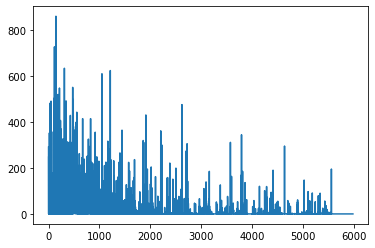

USER
32.0 16.0


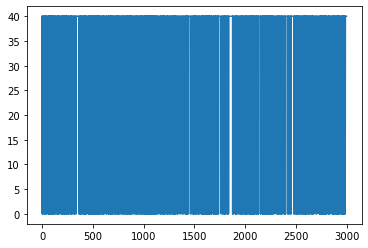

FEATURES


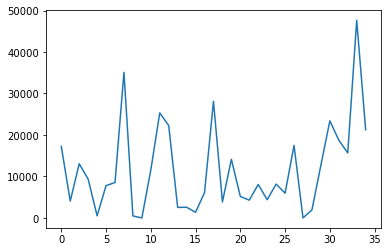

In [25]:
user_hit, item_hit, feature_hit = visualize_hit(user_interaction = train_user_interaction, review=train_review)

ITEM
2.008704385671242 7.145359889919393


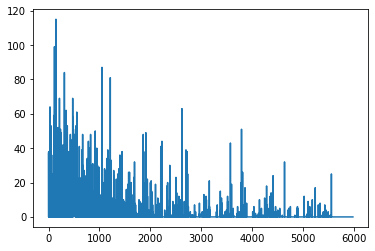

USER
4.0 12.0


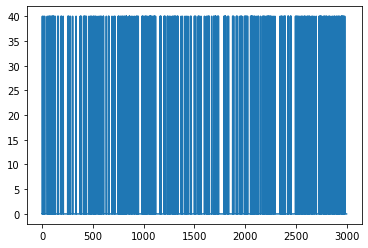

FEATURES


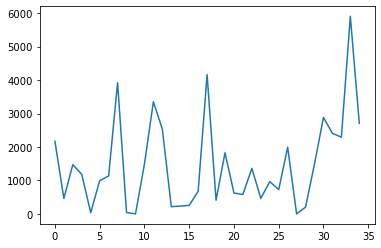

(array([ 0,  0, 40, ...,  0,  0,  0]),
 array([37,  6,  0, ...,  0,  0,  0]),
 array([2173,  461, 1474, 1181,   38,  994, 1134, 3922,   43,    0, 1488,
        3354, 2533,  217,  234,  255,  676, 4165,  411, 1827,  625,  581,
        1362,  463,  965,  728, 1994,    0,  203, 1499, 2883, 2408, 2294,
        5908, 2710]))

In [26]:
visualize_hit(user_interaction = test_user_interaction, review=test_review)

In [27]:
def get_item_opinion():
#     op = np.zeros((num_items, num_features))
#     for rid in range(len(train_user_interaction)):
#         _, i = train_user_interaction[rid]
#         features = train_review[rid]!=1
#         op[i, features] += 1
    op = np.zeros((num_items, num_features))

    for i in item_dict:
        features = list(map(int,item_dict[i]['feature_index']))
        op[int(i),features] += 1
#     row_sums = op.sum(axis=1)
#     new_matrix = op / row_sums[:, np.newaxis]
#     new_matrix[np.isnan(new_matrix)] = 0
    return op

train_item_opinion = get_item_opinion()
train_item_opinion

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [28]:
item_opinion.max(), train_item_opinion.max()

(1.0, 1.0)

In [29]:
def loadSUV(i):
    SU = np.load('movie-SU-{}.npy'.format(i))
    V = np.load('movie-V-{}.npy'.format(i))
    return SU, V

def saveSUV(i):
    np.save('movie-SU-{}'.format(i), SU)
    np.save('music-V-{}'.format(i), V)

In [34]:
# saveSUV(i='40')
SU, V = loadSUV(i=1)

SU.shape

(96000, 20)

In [ ]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0)
# SU = model.fit_transform(train_review)
# H = model.components_
# SU.shape
# SU

In [ ]:
# from sklearn.decomposition import NMF
# model = NMF(n_components=40, init='random', random_state=0, max_iter = 200)
# V = model.fit_transform(item_opinion)
# H = model.components_
# V.shape
# V

### Let's calculate sr@1 first

In [36]:
### Let's calculate MR@1 first
def MRR1(SU, V, user_interaction):
    mrr = 0
    success = 0
    count = 0
    for review_id in np.random.choice(len(user_interaction), size = 5000):
        count += 1
        u, i = user_interaction[review_id]
        pred = -SU[review_id].dot(V.T)
#         sur = SU[review_id]
#         pred = np.sum(np.abs((Vr-sur))**2,axis=-1)

        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

    print(mrr/(count), success/(count))


In [37]:
MRR1(SU, V, train_user_interaction)

5.634 0.869
5.626 0.874
5.522666666666667 0.8766666666666667
5.6305 0.87075
5.6184 0.8714
5.6184 0.8714


# Learn SU and V simultaneously

In [ ]:
V.max()

In [ ]:
def get_rating_matrix():
    r = np.zeros((num_users, num_items))
    for u, i in train_user_interaction:
        r[u, i] = 1
    return r
rating_matrix = get_rating_matrix()
rating_matrix.sum()

In [ ]:
np.max(SU), np.max(V)

In [39]:
# sr1(SU = SU, V=V, user_interaction = train_user_interaction)
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

6.143 0.875
6.5755 0.862
6.491333333333333 0.8606666666666667
6.4585 0.86325
6.6136 0.862
6.6136 0.862


In [758]:
SU[0].dot(V[3964]), SU[1].dot(V[3964]), SU[1].dot(V[5907])

(2.7889673614846213, 2.4203447393499578e-18, 0.8162926940228468)

In [60]:
# Learn SU and V simultaneously
lambda_BPR = 0.1

num_SGDUpdate = len(train_user_interaction)

alpha = 0.001
beta = 0.01


ALPHA = 0.01
BETA = 0.01

assert ALPHA >= alpha

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sgd_update_SUV_rating(SU, V, num_iter, num_BPRpairs):
    
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            # Update user and item latent feature matrices
            sig = sigmoid(pred)
            e = 1-sig
        
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]

#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]


            not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
    
            for i in np.random.choice(not_rated_items, num_BPRpairs):
                pred = SU[review_id].dot(V[i].T)
                # Update user and item latent feature matrices
                sig = sigmoid(pred)
                e = 0-sig
                SU[review_id, :] +=  lambda_BPR*(ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:])
                V[i, :] += lambda_BPR*(ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:])
    
    return SU, V

In [819]:
SU, V = sgd_update_SUV_rating(SU, V, num_iter=10, num_BPRpairs = 5)

100%|███████████████████████████████████████████| 10/10 [03:00<00:00, 18.02s/it]


In [861]:
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

7.65 0.84
7.74 0.8385
7.735666666666667 0.8436666666666667
7.867 0.84325
7.7404 0.8472
7.7404 0.8472


In [38]:
def MRR5(model, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
#         print("target:", i, "recommend:", recommend)
#         time.sleep(1)
        rank = np.where(recommend == i)[0][0]
    
        mrr += (rank+1)
        if(rank < topK):
            success += 1

        if((count) % 1000 == 0):
            print(mrr/(count), success/(count))

In [534]:
# SUold = copy.deepcopy(SU)

In [612]:
# SU, V = loadSUV(i  = 0)

In [765]:
depth = 5

dt = DT(max_depth = depth)
dt.fit(train_review, SU)

DecisionTreeRegressor(max_depth=5)

In [766]:
# MRR5(model = dt, V = V, user_interaction=train_user_interaction, reviews=train_review)

In [785]:
MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)

171.685 0.163
159.4795 0.1645
163.25466666666668 0.164
162.7585 0.1615
161.2066 0.1608
161.58116666666666 0.16466666666666666
162.47742857142856 0.16414285714285715
163.82775 0.163125
162.58755555555555 0.16333333333333333
161.6224 0.163
163.38963636363636 0.16172727272727272
163.35533333333333 0.15975


# --------------------- Personalization -------------------------------------------

In [39]:
def sgd_update_SU(SU, V, num_iter):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_SGDUpdate):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1-sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
            SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
#             V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  SU

In [40]:
def sgd_update_V(SU, V, num_iter, num_review):
    from tqdm import tqdm
    for _ in tqdm(range(num_iter)):
        for review_id in np.random.choice(len(train_user_interaction), size = num_review):
            u, i = train_user_interaction[review_id]
            pred = SU[review_id].dot(V[i].T)
            e = 1 - sigmoid(pred) ## note review_id being used in prediction
            # Update user and item latent feature matrices
#             SU[review_id, :] +=  ALPHA *  e * V[i, :] - ALPHA * BETA * SU[review_id,:]
            V[i, :] += ALPHA * e * SU[review_id] - ALPHA * BETA * V[i,:]
    
    return  V

In [41]:
def personalize(model, num_iter, num_review):
    SU_copy = copy.deepcopy(SU)
    
    V_predict = model.predict(item_opinion)
    V_predict= sgd_update_V(SU = SU_copy, V = V_predict, num_iter = num_iter, num_review = num_review)

#     SU_predict, V_copy = sgd_update_SUV_rating(SU = SU_predict, V = V_copy, num_iter = num_iter)
    
#     bpr_update_SUV_rating(SU = SU_predict, V = V_copy, num_BPRpairs = 10000)
    
    return SU_copy, V_predict



In [897]:
Vold = copy.deepcopy(V)

In [898]:
from sklearn.ensemble import RandomForestRegressor as RF

In [899]:
dtitem = RF(max_depth = 10)

In [900]:
dtitem.fit(item_opinion, V)

RandomForestRegressor(max_depth=10)

In [901]:
_, V = personalize(dtitem, 150, len(train_user_interaction))

100%|█████████████████████████████████████████| 150/150 [05:07<00:00,  2.05s/it]


In [902]:
SU, V = sgd_update_SUV_rating(SU, V, num_iter=20, num_BPRpairs = 5)

100%|███████████████████████████████████████████| 20/20 [06:36<00:00, 19.83s/it]


In [903]:
((V-Vold)**2).sum()

46.48602957011337

In [904]:
# SU = sgd_update_SU(SU = SU, V = V, num_iter = 50)

In [905]:
depth = 5

from sklearn.tree import DecisionTreeRegressor as DT
dt = DT(max_depth = depth)
dt.fit(train_review, SU)
MRR5(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)

# rf = RF(max_depth = depth)
# rf.fit(train_review, SU)
# MRR5(model = rf, V = V, user_interaction=test_user_interaction, reviews=test_review)

118.141 0.199
110.7315 0.1945
108.39133333333334 0.196
110.49225 0.19675
110.9956 0.1984
109.58216666666667 0.20116666666666666
110.11385714285714 0.20585714285714285
110.9695 0.204875
110.27711111111111 0.20377777777777778
110.2635 0.2038
111.25081818181818 0.20163636363636364
111.61075 0.20066666666666666


In [906]:
MRR1(SU = SU, V=V, user_interaction = train_user_interaction)

6.855 0.848
6.5395 0.856
6.292333333333334 0.8593333333333333
6.266 0.859
6.2654 0.8618
6.2654 0.8618


In [42]:

def DTCRS(model, V, user_interaction, reviews):
    tc = 0
    success = 0
    count = 0
    mrr = 0
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        su = model.predict(reviews[review_id].reshape(1,-1))
        pred = -su.dot(V.T)[0]
        recommend = np.argsort(pred)
    #         print("target:", i, "recommend:", recommend)
    #         time.sleep(1)
        rank = np.where(recommend == i)[0][0]

        mrr += (rank+1)

        if ( rank < (T - depth)*10): # success
            tc += depth + (rank //10)  + 1
            success += 1
        else: # failed
            tc += T

        if((count) % 1000 == 0):
            print(mrr/(count), tc/count, success/(count))

DTCRS(model = dt, V = V, user_interaction=val_user_interaction, reviews=val_review)


NameError: name 'dt' is not defined

# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------
# Super User FacT

In [44]:
train_review.shape

(96000, 35)

In [45]:
class Node:
    def __init__(self, parent, vector, members, used_features):
        self.parent = parent
        self.vector = vector
        self.members = members        
        self.used_features = used_features
        
        self.feature = None
        self.pos_node = None
        self.neg_node = None
#         self.unknown_node = None
        
        self.error = np.inf
        

In [429]:
PARTIAL = 0.9





class Tree:
    def __init__(self, tree_type):
        assert tree_type in ["review", "item"]
        self.tree_type = tree_type
        if(self.tree_type == "review"):
            root_error, root_vector = fit(idx = np.array(range(len(train_user_interaction))), 
                                          training_type = tree_type,
                                          node_vector = np.mean(SU, axis=0), 
                                          SU = SU, V = V, num_iter=num_FIT, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.random.choice(len(train_user_interaction), int(PARTIAL * len(train_user_interaction))), used_features = [])
            self.root.error = root_error

        elif(self.tree_type == "item"):
            root_error, root_vector = fit(idx = np.array(range(num_items)), 
                                          training_type = tree_type,
                                          node_vector = np.mean(V, axis=0), 
                                          SU = SU, V = V, num_iter=0, num_BPRpairs=0)
            self.root = Node(parent = None, vector = root_vector, members = np.array(range(num_items)), used_features = [])
            self.root.error = root_error
        else:
            raise ValueError("Invalid tree type")
        
#         review_tree_condition = (tree_type == "review" and len(self.root.members) == len(train_user_interaction))
#         item_tree_condition = (tree_type == "item" and len(self.root.members) == num_items)
        
#         assert review_tree_condition or item_tree_condition        

In [136]:
def squared_error_and_mse(true, pred):
    '''I am assuming true and pred both to be 1-D array'''
    assert pred.ndim == 1
    error = ((true - pred)**2).sum()
    return error, error/len(pred)

In [137]:
def sgd_update_review_vector(single_vector, V, review_indices, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in (review_indices):
            u, i = train_user_interaction[review_id]
            pred = sigmoid(single_vector.dot(V[i].T))
            e = 1 - pred ## note single vector being used in prediction
            single_vector += ALPHA *  (e * V[i, :] -  BETA * single_vector)
            
            error += np.log(e)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR * ALPHA *  (e * V[i, :] -  BETA * single_vector)
#                 error += e

                
    return single_vector, error/num_iter

In [138]:
def sgd_update_item_vector(SU, single_vector, item_indices, review_idx, num_iter, num_BPRpairs):
    
    error = 0
    for _ in range(num_iter):
        for review_id in review_idx:
            u, i = train_user_interaction[review_id]
            pred = sigmoid(SU[review_id].dot(single_vector.T))
            e = 1 - pred ## note review_id being used in prediction
            
            error += e
            # Update user and item latent feature matrices
            single_vector += ALPHA * (e * SU[review_id] - BETA * single_vector)
            
#             not_rated_items = np.where(rating_matrix[u, :] == 0)[0]
#             for i in np.random.choice(not_rated_items, num_BPRpairs):
#                 pred = SU[review_id].dot(V[i].T)
#                 # Update user and item latent feature matrices
#                 sig = sigmoid(pred)
#                 e = 0-sig
#                 single_vector += lambda_BPR*ALPHA * (e * SU[review_id] - BETA * single_vector)
#                 error += e
                
    return single_vector, error

In [139]:
def fit(idx, training_type, node_vector, SU, V, num_iter, num_BPRpairs):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if idx is None or (len(idx) == 0):
        return 0, None
    
    single_vector = copy.deepcopy(node_vector) ## we don't want to change node vector yet
    
    if training_type == "review":
        single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
        single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    return error, single_vector

In [140]:

# SUmean = np.zeros_like(SU)
# e, su = fit(idx = np.array(range(len(train_user_interaction))), 
#                                           training_type = "review",
#                                           node_vector = np.mean(SU, axis=0), 
#                                           SU = SU, V = V, num_iter = 5, num_BPRpairs=1)
# SUmean = SUmean + su
# SUmean, e

In [141]:
# MRR1(SU = SUmean, V=V, user_interaction = train_user_interaction)

# -----------------------------------------------------------------------------------------

In [53]:
# @nb.njit(parallel=True)
# def var_nb(a, ddof=0):
#     n = len(a)
#     s = a.sum()
#     m = s / (n - ddof)
#     v = 0
#     for i in nb.prange(n):
#         v += (a[i] - m) ** 2
#     return v / (n - ddof)

In [54]:
def get_error(idx, training_type):
    '''
    I am assuming idx is an array of indices and NOT bool indices
    if training_type == review => we are updating SU, keeping V fixed
    if training_type == item => we are updating V, keeping SU fixed
    '''
    assert training_type in ["review", "item"]
    
    if (len(idx) == 0):
        return 0
    
    
    if training_type == "review":
#         single_vector, error = sgd_update_review_vector(single_vector = single_vector, V = V, review_indices = idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
        review_idx = idx
        
    elif training_type == "item":
        review_idx = np.array([i for i in range(len(train_user_interaction)) if train_user_interaction[i, 1] in idx ])
#         single_vector, error = sgd_update_item_vector(SU = SU, single_vector = single_vector, item_indices = idx, review_idx = review_idx, num_iter = num_iter, num_BPRpairs = num_BPRpairs)
    
    error = ((SU[review_idx, :] - SU[review_idx, :].mean(axis = 0))**2).sum()
#     error = SU[review_idx, :].var()

    return error

# -----------------------------------------------------------------------------------------

In [61]:
VERBOSE = 0.4

def find_best_split(node, training_type, flist):    
    '''
    I will assume node.members is non-empty
    if training_type == review => we are updating SU keeping V fixed
    if training_type == item => we are updating V keeping SU fixed
    '''
    if node.members is None or len(node.members) == 0:
        node = None
        return None
    members = node.members
    
    assert training_type in ["review", "item"]
    if(training_type == "review"):
        opinion_matrix = train_review
    elif(training_type == "item"):
        opinion_matrix = train_item_opinion
        
    
    
    
    best_feature = None
    lowest_avg_error = np.inf
    lowest_pos_error = np.inf
    lowest_neg_error = np.inf

    best_pos_members = None
    best_neg_members = None
    
    best_pos_single_vector = None
    best_neg_single_vector = None
    
    
    for feature in flist:
        
        if (feature in node.used_features):
            continue
            
        pos_idx = []
        neg_idx = []
        
        for r in node.members:
            val = opinion_matrix[r, feature]
            if(val > 0):
                pos_idx.append(r)
            else:
                neg_idx.append(r)

        pos_idx = np.array(pos_idx)
        neg_idx = np.array(neg_idx)
        
        assert len(pos_idx) + len(neg_idx)  == len(node.members)
        
        pos_error, pos_single_vector  = fit(idx = pos_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        neg_error, neg_single_vector = fit(idx = neg_idx, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_iter_review, num_BPRpairs=0)
        
#         pos_error = get_error(idx = pos_idx, training_type = training_type)  #must use the fit method to get error
#         neg_error = get_error(idx = neg_idx, training_type = training_type)
        
        w_pos = 1 #len(pos_idx)/len(members)
        w_neg = 1 #len(neg_idx)/len(members)
        
        
        avg_error = w_pos*pos_error + w_neg*neg_error
        
        if (random.random() < VERBOSE):
            print("feature {} avg. error: {}, ratio: {}, pos:{}, neg: {}".format(feature,  avg_error, len(pos_idx)/len(members), len(pos_idx), len(neg_idx)))
        
        ## Update carefully:
        if(avg_error < lowest_avg_error):
            
            lowest_avg_error = avg_error
            best_feature = feature
            
            lowest_pos_error = pos_error
            lowest_neg_error = neg_error
            
            best_pos_members = pos_idx
            best_neg_members = neg_idx

    node.used_features.extend([best_feature])
    
    lowest_pos_error, best_pos_single_vector  = fit(idx = best_pos_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    lowest_neg_error, best_neg_single_vector = fit(idx = best_neg_members, training_type = training_type, node_vector = node.vector, SU = SU, V = V, num_iter = num_FIT, num_BPRpairs=0)
    
    
    return (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector)

In [62]:
num_iter_review = 1
num_iter_item = 1

num_FIT = 20


review_tree = Tree(tree_type = "review")
review_tree.root.vector

array([1.27980267, 0.51885114, 0.65828284, 0.12335541, 0.34224955,
       0.56428573, 0.50349001, 0.55650195, 0.55625039, 0.55541193,
       0.43501531, 0.46730412, 0.12947001, 0.59556577, 0.65706901,
       0.49609469, 0.38004455, 0.82275388, 1.02610033, 0.30206924])

In [63]:
review_tree.root.feature

In [64]:
# itmset = set(train_user_interaction[review_tree.root.members,1])
# GINI = 1
# if(len(review_tree.root.members) > 0):
#     GINI -= (len(itmset)/len(review_tree.root.members))**2
#     print(GINI)

# -----------------------------------------------------------------------------------------

In [105]:
def create_tree(tree_type, node, depth, flist):
    if (depth > MAX_DEPTH):
        print("MAX DEPTH REACHED: {}".format(MAX_DEPTH))
        return
    
    if (node.feature is None):
        best = find_best_split(node = node, training_type = tree_type, flist = flist)
        
#         print(best)
        
        if best is None:
            print("best is none")
            return
        
        
        ## early stopping GINI Index
#         itmset = set(train_user_interaction[node.members,1])
#         GINI = 1
#         if(len(node.members) > 0):
#             GINI -= (len(itmset)/len(node.members))**2
#         if (GINI > 0.9967):
#             return
            
        
        
        
        (lowest_avg_error, 
            lowest_pos_error,
            lowest_neg_error,
            best_feature, 
            best_pos_members,
            best_neg_members,
            best_pos_single_vector, 
            best_neg_single_vector) = best
        node.feature = best_feature
        
        
        
        
        node.error = lowest_pos_error + lowest_neg_error #lowest_avg_error
        
        node.pos_node = Node(parent = node, vector = best_pos_single_vector, members = best_pos_members, used_features = node.used_features.copy())
        node.neg_node = Node(parent = node, vector = best_neg_single_vector, members = best_neg_members, used_features = node.used_features.copy())

    else:
        print("CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................")
    
    
    print("depth: {}, best feature id:{}, error:{}".format(depth, node.feature, node.error))    

    print("# of pos members: ", 0 if node.pos_node.members is None else len(node.pos_node.members))
    print('# of neg members: ', 0 if node.neg_node.members is None else len(node.neg_node.members))

    create_tree(tree_type = tree_type, node = node.pos_node, depth = depth +1, flist = flist)

    create_tree(tree_type = tree_type, node = node.neg_node, depth = depth +1, flist = flist)


In [106]:
MAX_DEPTH = 7

In [107]:
create_tree(tree_type = 'review', node = review_tree.root, depth=0, flist = list(range(num_features)))


# np.save('movie_review_tree-40.npy', review_tree)

CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 0, best feature id:33, error:-203983.8418242851
# of pos members:  33349
# of neg members:  33851
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 1, best feature id:7, error:-126516.84920600345
# of pos members:  12911
# of neg members:  20438
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 2, best feature id:12, error:-53501.33582540752
# of pos members:  3804
# of neg members:  9107
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 3, best feature id:11, error:-16404.4258991714
# of pos members:  1389
# of neg members:  2415
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 4, best feature id:30, error:-6101.505899228416
# of pos members:  145
# of neg members:  1244
CONTINUING BUILDING TREE FROM WHERE WE LEFT OFF.................
depth: 5, best feature id:20, error:-669.3575105857686
# of pos members:  15
# of neg members

In [108]:
print("Done!!")

Done!!


In [109]:

prob = 0.9

N_TREE = 10



def sub_features():
    f = []
    for _ in range(N_TREE):
        l = []
        for i in range(num_features):
            if(random.random() < prob):
                l.append(i)
        
        f.append(l)
        
    return f


# subflist = sub_features()
subflist

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  30,
  31,
  32,
  34],
 [0,
  1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  31,
  32],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  32,
  34],
 [0,
  1,
  2,
  4,
  6,
  7,
  9,
  10,
  12,
  14,
  15,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  28,
  30,
  32,
  33,
  34],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,


In [142]:
# forest = [ Tree(tree_type = "review") for _ in range(N_TREE)] ## don't overwrite the forest

In [143]:
# MAX_DEPTH = 5

    
# [par_forest(i) for i in range(N_TREE)]
# @nb.jit(parallel=True)
# def par_forest(i):
# #     for i in nb.prange(N_TREE):

    

#     return None

# par_forest()

# Parallel(n_jobs=10)(delayed (par_forest)(i) for i in range(N_TREE))

for i in range(N_TREE):
    print("===============================")
    print("Starting building Tree", i)
    print("===============================")

    create_tree(tree_type="review", node=forest[i].root, depth=0, flist = subflist[i])
    print("===============================")
    print("Finished building Tree", i)
    print("===============================")


Starting building Tree 0
feature 0 avg. error: -211097.31717620732, ratio: 0.17953703703703705, pos:15512, neg: 70888
feature 3 avg. error: -200554.68886339467, ratio: 0.09612268518518519, pos:8305, neg: 78095
feature 5 avg. error: -199444.30370720976, ratio: 0.0817361111111111, pos:7062, neg: 79338
feature 9 avg. error: -190691.27698781822, ratio: 2.3148148148148147e-05, pos:2, neg: 86398
feature 12 avg. error: -217792.3224587814, ratio: 0.23159722222222223, pos:20010, neg: 66390
feature 14 avg. error: -194635.52669986512, ratio: 0.026331018518518517, pos:2275, neg: 84125
feature 17 avg. error: -223366.82425005705, ratio: 0.2910300925925926, pos:25145, neg: 61255
feature 18 avg. error: -197996.77903542772, ratio: 0.03991898148148148, pos:3449, neg: 82951
feature 22 avg. error: -200292.8232851301, ratio: 0.08168981481481481, pos:7058, neg: 79342
feature 24 avg. error: -204959.23816038764, ratio: 0.08581018518518518, pos:7414, neg: 78986
feature 25 avg. error: -198454.1316900275, ratio:

feature 8 avg. error: -2955.3781843053353, ratio: 0.0061162079510703364, pos:4, neg: 650
feature 13 avg. error: -2954.6940763314938, ratio: 0.013761467889908258, pos:9, neg: 645
feature 14 avg. error: -2955.5353702046, ratio: 0.0, pos:0, neg: 654
feature 15 avg. error: -2955.5353702046, ratio: 0.0, pos:0, neg: 654
feature 23 avg. error: -2955.5353702046, ratio: 0.0, pos:0, neg: 654
feature 24 avg. error: -2955.5187345272784, ratio: 0.03211009174311927, pos:21, neg: 633
feature 31 avg. error: -2955.5223001308805, ratio: 0.016819571865443424, pos:11, neg: 643
depth: 5, best feature id:20, error:-2957.88516636126
# of pos members:  116
# of neg members:  538
feature 0 avg. error: -529.7320519227321, ratio: 0.0603448275862069, pos:7, neg: 109
feature 4 avg. error: -529.7286423433527, ratio: 0.0, pos:0, neg: 116
feature 6 avg. error: -529.7558912394649, ratio: 0.0603448275862069, pos:7, neg: 109
feature 10 avg. error: -529.7286423433527, ratio: 0.0, pos:0, neg: 116
feature 16 avg. error: -5

depth: 5, best feature id:6, error:-2651.562551524165
# of pos members:  28
# of neg members:  573
feature 0 avg. error: -135.1933011459177, ratio: 0.07142857142857142, pos:2, neg: 26
feature 1 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 2 avg. error: -135.18997340063635, ratio: 0.07142857142857142, pos:2, neg: 26
feature 3 avg. error: -135.2056027879569, ratio: 0.32142857142857145, pos:9, neg: 19
feature 5 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 9 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 20 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 21 avg. error: -135.19733736331673, ratio: 0.14285714285714285, pos:4, neg: 24
feature 22 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 24 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
feature 28 avg. error: -135.1882682393893, ratio: 0.0, pos:0, neg: 28
depth: 6, best feature id:17, error:-134.93359690761025
# of pos member

feature 32 avg. error: -2636.0715131482984, ratio: 0.09015025041736227, pos:54, neg: 545
depth: 7, best feature id:17, error:-2640.190276791918
# of pos members:  81
# of neg members:  518
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -11712.19455038065, ratio: 0.024354780079970918, pos:67, neg: 2684
feature 3 avg. error: -11720.771018228716, ratio: 0.09123954925481643, pos:251, neg: 2500
feature 4 avg. error: -11720.494608030158, ratio: 0.0014540167211922936, pos:4, neg: 2747
feature 5 avg. error: -11714.363945312723, ratio: 0.05270810614322065, pos:145, neg: 2606
feature 13 avg. error: -11714.850428678848, ratio: 0.03744093057070156, pos:103, neg: 2648
feature 15 avg. error: -11719.15135128116, ratio: 0.0069065794256633955, pos:19, neg: 2732
feature 16 avg. error: -11711.512973603014, ratio: 0.0752453653217012, pos:207, neg: 2544
feature 17 avg. error: -11710.947825062416, ratio: 0.11959287531806616, pos:329, neg: 2422
feature 18 avg. error: -11720.303950060781, rat

feature 15 avg. error: -2619.363318454823, ratio: 0.0, pos:0, neg: 594
feature 24 avg. error: -2619.325366359709, ratio: 0.003367003367003367, pos:2, neg: 592
feature 26 avg. error: -2619.1757944465317, ratio: 0.04377104377104377, pos:26, neg: 568
feature 28 avg. error: -2619.363318454823, ratio: 0.0, pos:0, neg: 594
feature 32 avg. error: -2619.1772598492053, ratio: 0.05723905723905724, pos:34, neg: 560
feature 34 avg. error: -2619.1712483558554, ratio: 0.03872053872053872, pos:23, neg: 571
depth: 6, best feature id:22, error:-2620.4509545940787
# of pos members:  13
# of neg members:  581
feature 0 avg. error: -59.448543028867164, ratio: 0.0, pos:0, neg: 13
feature 1 avg. error: -59.448543028867164, ratio: 0.0, pos:0, neg: 13
feature 5 avg. error: -59.44765714088569, ratio: 0.07692307692307693, pos:1, neg: 12
feature 6 avg. error: -59.44901244575314, ratio: 0.07692307692307693, pos:1, neg: 12
feature 10 avg. error: -59.448543028867164, ratio: 0.0, pos:0, neg: 13
feature 15 avg. error

feature 6 avg. error: -36772.36079488713, ratio: 0.06119270137961727, pos:550, neg: 8438
feature 9 avg. error: -36769.324499288465, ratio: 0.0, pos:0, neg: 8988
feature 17 avg. error: -36989.62147906794, ratio: 0.29817534490431685, pos:2680, neg: 6308
feature 20 avg. error: -36825.768551686364, ratio: 0.07543391188251002, pos:678, neg: 8310
feature 31 avg. error: -36781.66403599288, ratio: 0.13662661326212727, pos:1228, neg: 7760
feature 34 avg. error: -36999.030844498666, ratio: 0.14196706720071206, pos:1276, neg: 7712
depth: 4, best feature id:34, error:-37395.08886948739
# of pos members:  1276
# of neg members:  7712
feature 1 avg. error: -5495.8751704702145, ratio: 0.01567398119122257, pos:20, neg: 1256
feature 3 avg. error: -5499.175828526181, ratio: 0.07601880877742946, pos:97, neg: 1179
feature 10 avg. error: -5507.118353266743, ratio: 0.1920062695924765, pos:245, neg: 1031
feature 16 avg. error: -5499.629690219485, ratio: 0.008620689655172414, pos:11, neg: 1265
feature 25 avg.

feature 22 avg. error: -10483.965009682299, ratio: 0.015990159901599015, pos:39, neg: 2400
feature 23 avg. error: -10481.909375226827, ratio: 0.035260352603526036, pos:86, neg: 2353
feature 26 avg. error: -10498.239812256983, ratio: 0.06150061500615006, pos:150, neg: 2289
feature 29 avg. error: -10507.80588502823, ratio: 0.16810168101681017, pos:410, neg: 2029
feature 32 avg. error: -10484.539925800342, ratio: 0.14309143091430915, pos:349, neg: 2090
depth: 6, best feature id:29, error:-10541.285819381474
# of pos members:  410
# of neg members:  2029
feature 3 avg. error: -1834.3316829275327, ratio: 0.03902439024390244, pos:16, neg: 394
feature 6 avg. error: -1833.8286542267472, ratio: 0.041463414634146344, pos:17, neg: 393
feature 9 avg. error: -1834.1783863522626, ratio: 0.0, pos:0, neg: 410
feature 14 avg. error: -1834.1783863522626, ratio: 0.0, pos:0, neg: 410
feature 15 avg. error: -1834.1783863522626, ratio: 0.0, pos:0, neg: 410
feature 16 avg. error: -1833.3968682268594, ratio: 

feature 28 avg. error: -24624.494034525203, ratio: 0.0020161290322580645, pos:12, neg: 5940
feature 29 avg. error: -24624.53225888638, ratio: 0.03696236559139785, pos:220, neg: 5732
feature 30 avg. error: -24605.560495740916, ratio: 0.07258064516129033, pos:432, neg: 5520
depth: 3, best feature id:34, error:-25123.814268726266
# of pos members:  1999
# of neg members:  3953
feature 1 avg. error: -8902.936095502533, ratio: 0.0005002501250625312, pos:1, neg: 1998
feature 8 avg. error: -8902.992210559378, ratio: 0.0, pos:0, neg: 1999
feature 9 avg. error: -8902.992210559378, ratio: 0.0, pos:0, neg: 1999
feature 10 avg. error: -8910.007668045833, ratio: 0.25362681340670334, pos:507, neg: 1492
feature 15 avg. error: -8903.594153810962, ratio: 0.0065032516258129065, pos:13, neg: 1986
feature 16 avg. error: -8902.866687076765, ratio: 0.03401700850425213, pos:68, neg: 1931
feature 17 avg. error: -8928.903407594582, ratio: 0.375687843921961, pos:751, neg: 1248
feature 18 avg. error: -8905.41736

depth: 5, best feature id:10, error:-5535.138132519153
# of pos members:  432
# of neg members:  816
feature 5 avg. error: -1933.2259869255925, ratio: 0.020833333333333332, pos:9, neg: 423
feature 6 avg. error: -1933.4364764303075, ratio: 0.018518518518518517, pos:8, neg: 424
feature 9 avg. error: -1933.4951858848274, ratio: 0.0, pos:0, neg: 432
feature 15 avg. error: -1933.6725098245, ratio: 0.009259259259259259, pos:4, neg: 428
feature 18 avg. error: -1933.9647083572643, ratio: 0.032407407407407406, pos:14, neg: 418
feature 20 avg. error: -1933.4521436838252, ratio: 0.023148148148148147, pos:10, neg: 422
feature 23 avg. error: -1933.4951858848274, ratio: 0.0, pos:0, neg: 432
feature 24 avg. error: -1933.0669442498836, ratio: 0.034722222222222224, pos:15, neg: 417
feature 26 avg. error: -1933.0909864772311, ratio: 0.07175925925925926, pos:31, neg: 401
depth: 6, best feature id:18, error:-1932.865379959368
# of pos members:  14
# of neg members:  418
feature 3 avg. error: -67.498944931

feature 8 avg. error: -4311.9664407951805, ratio: 0.0030643513789581204, pos:3, neg: 976
feature 12 avg. error: -4307.465717051765, ratio: 0.04800817160367722, pos:47, neg: 932
feature 14 avg. error: -4311.7333104837535, ratio: 0.0040858018386108275, pos:4, neg: 975
feature 15 avg. error: -4311.9905961246295, ratio: 0.008171603677221655, pos:8, neg: 971
feature 18 avg. error: -4311.236642600589, ratio: 0.020429009193054137, pos:20, neg: 959
feature 21 avg. error: -4311.895334890275, ratio: 0.02247191011235955, pos:22, neg: 957
feature 22 avg. error: -4310.645108895554, ratio: 0.03575076608784474, pos:35, neg: 944
feature 23 avg. error: -4311.051030823826, ratio: 0.010214504596527068, pos:10, neg: 969
feature 31 avg. error: -4313.499260790433, ratio: 0.09397344228804903, pos:92, neg: 887
depth: 6, best feature id:25, error:-4320.144629768098
# of pos members:  135
# of neg members:  844
feature 0 avg. error: -615.678276733229, ratio: 0.014814814814814815, pos:2, neg: 133
feature 2 avg. 

depth: 7, best feature id:25, error:-1290.201445685461
# of pos members:  33
# of neg members:  258
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -7412.951751987023, ratio: 0.09580838323353294, pos:176, neg: 1661
feature 2 avg. error: -7412.42307327273, ratio: 0.12574850299401197, pos:231, neg: 1606
feature 4 avg. error: -7405.247420885054, ratio: 0.003810560696788242, pos:7, neg: 1830
feature 8 avg. error: -7406.067577416635, ratio: 0.004354926510615134, pos:8, neg: 1829
feature 10 avg. error: -7407.5414723159865, ratio: 0.08600979858464888, pos:158, neg: 1679
feature 13 avg. error: -7406.208620492326, ratio: 0.03973870440936309, pos:73, neg: 1764
feature 14 avg. error: -7403.796845263553, ratio: 0.02231899836690256, pos:41, neg: 1796
feature 16 avg. error: -7409.76327194004, ratio: 0.038649972781709306, pos:71, neg: 1766
feature 22 avg. error: -7409.634443761419, ratio: 0.09471965160587915, pos:174, neg: 1663
feature 23 avg. error: -7405.803652046734, ratio: 0.03647

feature 13 avg. error: -4809.792336561998, ratio: 0.007428040854224698, pos:8, neg: 1069
feature 14 avg. error: -4810.32107960656, ratio: 0.007428040854224698, pos:8, neg: 1069
feature 15 avg. error: -4811.1011943879475, ratio: 0.007428040854224698, pos:8, neg: 1069
feature 18 avg. error: -4810.060934346658, ratio: 0.035283194057567316, pos:38, neg: 1039
feature 20 avg. error: -4812.208157108616, ratio: 0.02692664809656453, pos:29, neg: 1048
feature 22 avg. error: -4809.933154089468, ratio: 0.035283194057567316, pos:38, neg: 1039
feature 23 avg. error: -4810.974236524932, ratio: 0.0, pos:0, neg: 1077
feature 25 avg. error: -4809.574971777671, ratio: 0.09842154131847725, pos:106, neg: 971
feature 31 avg. error: -4807.12588813455, ratio: 0.03899721448467967, pos:42, neg: 1035
depth: 7, best feature id:20, error:-4815.491172425542
# of pos members:  29
# of neg members:  1048
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -9480.35998388523, ratio: 0.07192982456140351, pos

feature 6 avg. error: -19608.152633198526, ratio: 0.08560066973629134, pos:409, neg: 4369
feature 9 avg. error: -19555.355732430617, ratio: 0.0, pos:0, neg: 4778
feature 20 avg. error: -19578.30118767499, ratio: 0.058183340309753036, pos:278, neg: 4500
feature 21 avg. error: -19539.763030524984, ratio: 0.026161573880284637, pos:125, neg: 4653
feature 30 avg. error: -19603.836121568052, ratio: 0.13917957304311426, pos:665, neg: 4113
feature 31 avg. error: -19631.2097046823, ratio: 0.20510673922143155, pos:980, neg: 3798
depth: 5, best feature id:31, error:-19636.068550202788
# of pos members:  980
# of neg members:  3798
feature 0 avg. error: -4171.0255010638275, ratio: 0.08877551020408163, pos:87, neg: 893
feature 1 avg. error: -4170.540541010136, ratio: 0.025510204081632654, pos:25, neg: 955
feature 3 avg. error: -4170.293481818464, ratio: 0.03877551020408163, pos:38, neg: 942
feature 8 avg. error: -4170.273219761681, ratio: 0.0, pos:0, neg: 980
feature 13 avg. error: -4166.9556375701

feature 31 avg. error: -12233.660959611118, ratio: 0.15560640732265446, pos:476, neg: 2583
depth: 6, best feature id:29, error:-12290.064770434512
# of pos members:  482
# of neg members:  2577
feature 0 avg. error: -2045.3208006360696, ratio: 0.06224066390041494, pos:30, neg: 452
feature 1 avg. error: -2046.1919011739105, ratio: 0.07468879668049792, pos:36, neg: 446
feature 2 avg. error: -2045.1776166082634, ratio: 0.06224066390041494, pos:30, neg: 452
feature 4 avg. error: -2045.4079377447151, ratio: 0.0, pos:0, neg: 482
feature 5 avg. error: -2044.792716871578, ratio: 0.026970954356846474, pos:13, neg: 469
feature 8 avg. error: -2045.4079377447151, ratio: 0.0, pos:0, neg: 482
feature 9 avg. error: -2045.4079377447151, ratio: 0.0, pos:0, neg: 482
feature 13 avg. error: -2045.5151493024237, ratio: 0.026970954356846474, pos:13, neg: 469
feature 16 avg. error: -2045.0962941176824, ratio: 0.01037344398340249, pos:5, neg: 477
feature 18 avg. error: -2045.254389795532, ratio: 0.02489626556

depth: 3, best feature id:17, error:-9570.158097675765
# of pos members:  608
# of neg members:  1635
feature 4 avg. error: -2670.4239331228896, ratio: 0.0, pos:0, neg: 608
feature 8 avg. error: -2670.4239331228896, ratio: 0.0, pos:0, neg: 608
feature 10 avg. error: -2671.2076424473626, ratio: 0.13157894736842105, pos:80, neg: 528
feature 15 avg. error: -2670.4239331228896, ratio: 0.0, pos:0, neg: 608
feature 18 avg. error: -2670.4239331228896, ratio: 0.0, pos:0, neg: 608
feature 20 avg. error: -2670.704796306832, ratio: 0.046052631578947366, pos:28, neg: 580
feature 21 avg. error: -2670.0276583188615, ratio: 0.013157894736842105, pos:8, neg: 600
feature 24 avg. error: -2669.963644197103, ratio: 0.03125, pos:19, neg: 589
feature 26 avg. error: -2672.6396436878063, ratio: 0.21217105263157895, pos:129, neg: 479
feature 31 avg. error: -2669.9374886649384, ratio: 0.06743421052631579, pos:41, neg: 567
depth: 4, best feature id:26, error:-2681.8686506298827
# of pos members:  129
# of neg me

feature 23 avg. error: -444.84832287570123, ratio: 0.019801980198019802, pos:2, neg: 99
feature 25 avg. error: -444.838948175466, ratio: 0.21782178217821782, pos:22, neg: 79
depth: 7, best feature id:30, error:-446.9194930768695
# of pos members:  15
# of neg members:  86
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -1608.3903367231292, ratio: 0.005449591280653951, pos:2, neg: 365
feature 4 avg. error: -1608.4396190989075, ratio: 0.0, pos:0, neg: 367
feature 5 avg. error: -1608.42130417445, ratio: 0.005449591280653951, pos:2, neg: 365
feature 6 avg. error: -1608.6544738702978, ratio: 0.021798365122615803, pos:8, neg: 359
feature 8 avg. error: -1608.4396190989075, ratio: 0.0, pos:0, neg: 367
feature 9 avg. error: -1608.4396190989075, ratio: 0.0, pos:0, neg: 367
feature 13 avg. error: -1608.0105481879427, ratio: 0.01634877384196185, pos:6, neg: 361
feature 22 avg. error: -1608.5885672122827, ratio: 0.07629427792915532, pos:28, neg: 339
feature 23 avg. error: -1608.5772

feature 5 avg. error: -5781.0037019299925, ratio: 0.024817518248175182, pos:34, neg: 1336
feature 10 avg. error: -5788.3969577936095, ratio: 0.31605839416058396, pos:433, neg: 937
feature 16 avg. error: -5778.816936924542, ratio: 0.04744525547445255, pos:65, neg: 1305
feature 18 avg. error: -5782.377212169216, ratio: 0.01167883211678832, pos:16, neg: 1354
feature 25 avg. error: -5783.074866828434, ratio: 0.07153284671532846, pos:98, neg: 1272
feature 26 avg. error: -5785.8308738077585, ratio: 0.1335766423357664, pos:183, neg: 1187
feature 28 avg. error: -5782.890438997045, ratio: 0.00291970802919708, pos:4, neg: 1366
feature 29 avg. error: -5784.034890117331, ratio: 0.12116788321167883, pos:166, neg: 1204
feature 31 avg. error: -5781.014859937976, ratio: 0.040145985401459854, pos:55, neg: 1315
feature 32 avg. error: -5785.563738500348, ratio: 0.1854014598540146, pos:254, neg: 1116
depth: 5, best feature id:10, error:-5791.491837543949
# of pos members:  433
# of neg members:  937
featu

feature 22 avg. error: -15172.201040536005, ratio: 0.06942889137737962, pos:248, neg: 3324
feature 23 avg. error: -15156.45540428104, ratio: 0.05431131019036954, pos:194, neg: 3378
feature 25 avg. error: -15157.212387128817, ratio: 0.015957446808510637, pos:57, neg: 3515
feature 26 avg. error: -15200.096919196629, ratio: 0.20884658454647256, pos:746, neg: 2826
feature 31 avg. error: -15158.532284131357, ratio: 0.13745800671892497, pos:491, neg: 3081
depth: 4, best feature id:30, error:-15228.546749842124
# of pos members:  977
# of neg members:  2595
feature 3 avg. error: -4342.815353170571, ratio: 0.02968270214943705, pos:29, neg: 948
feature 5 avg. error: -4343.801484085116, ratio: 0.06755373592630501, pos:66, neg: 911
feature 6 avg. error: -4344.140616293319, ratio: 0.08290685772773797, pos:81, neg: 896
feature 13 avg. error: -4341.6904879741, ratio: 0.007164790174002047, pos:7, neg: 970
feature 14 avg. error: -4343.008584166334, ratio: 0.0, pos:0, neg: 977
feature 22 avg. error: -4

depth: 5, best feature id:26, error:-10947.632703093805
# of pos members:  462
# of neg members:  2133
feature 0 avg. error: -2044.0330199306695, ratio: 0.31385281385281383, pos:145, neg: 317
feature 1 avg. error: -2043.1452111086535, ratio: 0.006493506493506494, pos:3, neg: 459
feature 2 avg. error: -2043.6809761478012, ratio: 0.170995670995671, pos:79, neg: 383
feature 3 avg. error: -2043.0173660988298, ratio: 0.004329004329004329, pos:2, neg: 460
feature 4 avg. error: -2043.0776733746388, ratio: 0.0021645021645021645, pos:1, neg: 461
feature 5 avg. error: -2043.5201748045483, ratio: 0.0735930735930736, pos:34, neg: 428
feature 10 avg. error: -2042.926918481768, ratio: 0.004329004329004329, pos:2, neg: 460
feature 14 avg. error: -2043.0369058937163, ratio: 0.006493506493506494, pos:3, neg: 459
feature 15 avg. error: -2043.1696055312827, ratio: 0.012987012987012988, pos:6, neg: 456
feature 20 avg. error: -2043.999412354664, ratio: 0.17532467532467533, pos:81, neg: 381
feature 21 avg. 

feature 14 avg. error: -4244.413733084217, ratio: 0.0, pos:0, neg: 962
feature 16 avg. error: -4245.254406361978, ratio: 0.059251559251559255, pos:57, neg: 905
feature 20 avg. error: -4245.342551960409, ratio: 0.05301455301455302, pos:51, neg: 911
feature 24 avg. error: -4246.176484658068, ratio: 0.13513513513513514, pos:130, neg: 832
feature 28 avg. error: -4244.632066767441, ratio: 0.006237006237006237, pos:6, neg: 956
feature 29 avg. error: -4245.671364956982, ratio: 0.12266112266112267, pos:118, neg: 844
depth: 6, best feature id:17, error:-4255.831042594624
# of pos members:  274
# of neg members:  688
feature 1 avg. error: -1235.0321065848907, ratio: 0.0036496350364963502, pos:1, neg: 273
feature 3 avg. error: -1235.1004439226433, ratio: 0.0072992700729927005, pos:2, neg: 272
feature 4 avg. error: -1235.037857086833, ratio: 0.0, pos:0, neg: 274
feature 8 avg. error: -1235.037857086833, ratio: 0.0, pos:0, neg: 274
feature 9 avg. error: -1235.037857086833, ratio: 0.0, pos:0, neg: 2

feature 13 avg. error: -7084.137310711471, ratio: 0.011621150493898896, pos:20, neg: 1701
feature 14 avg. error: -7085.407527854705, ratio: 0.002324230098779779, pos:4, neg: 1717
feature 15 avg. error: -7085.89074763574, ratio: 0.002324230098779779, pos:4, neg: 1717
feature 25 avg. error: -7090.2496055589745, ratio: 0.1411969785008716, pos:243, neg: 1478
feature 26 avg. error: -7095.10557411447, ratio: 0.14352120859965137, pos:247, neg: 1474
feature 29 avg. error: -7086.436083660035, ratio: 0.0830912260313771, pos:143, neg: 1578
depth: 7, best feature id:26, error:-7114.758932994357
# of pos members:  247
# of neg members:  1474
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -14236.9503549006, ratio: 0.23189983669025585, pos:852, neg: 2822
feature 2 avg. error: -14250.804253394817, ratio: 0.23353293413173654, pos:858, neg: 2816
feature 3 avg. error: -14226.969893353384, ratio: 0.1390854654327708, pos:511, neg: 3163
feature 13 avg. error: -14199.734370117965, ratio: 0.0

feature 8 avg. error: -677.0276035708997, ratio: 0.0, pos:0, neg: 147
feature 13 avg. error: -677.0276035708997, ratio: 0.0, pos:0, neg: 147
feature 15 avg. error: -677.0276035708997, ratio: 0.0, pos:0, neg: 147
feature 21 avg. error: -677.0276035708997, ratio: 0.0, pos:0, neg: 147
feature 24 avg. error: -677.0344286515549, ratio: 0.013605442176870748, pos:2, neg: 145
feature 25 avg. error: -677.0480191043357, ratio: 0.013605442176870748, pos:2, neg: 145
feature 28 avg. error: -677.0276035708997, ratio: 0.0, pos:0, neg: 147
depth: 7, best feature id:22, error:-677.1226730126987
# of pos members:  9
# of neg members:  138
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -3306.737518100429, ratio: 0.02200825309491059, pos:16, neg: 711
feature 9 avg. error: -3306.3919796517616, ratio: 0.0, pos:0, neg: 727
feature 10 avg. error: -3308.212444708825, ratio: 0.18982118294360384, pos:138, neg: 589
feature 16 avg. error: -3303.9059944409732, ratio: 0.05364511691884457, pos:39, ne

feature 3 avg. error: -4866.924778451343, ratio: 0.0674955595026643, pos:76, neg: 1050
feature 8 avg. error: -4866.951840856348, ratio: 0.0, pos:0, neg: 1126
feature 10 avg. error: -4872.606234770377, ratio: 0.4573712255772647, pos:515, neg: 611
feature 12 avg. error: -4870.531357404964, ratio: 0.1989342806394316, pos:224, neg: 902
feature 15 avg. error: -4867.002974406114, ratio: 0.04085257548845471, pos:46, neg: 1080
feature 18 avg. error: -4870.2646581545905, ratio: 0.0905861456483126, pos:102, neg: 1024
feature 20 avg. error: -4866.433151558983, ratio: 0.010657193605683837, pos:12, neg: 1114
feature 23 avg. error: -4864.842577792601, ratio: 0.013321492007104795, pos:15, neg: 1111
feature 25 avg. error: -4865.717667897821, ratio: 0.0674955595026643, pos:76, neg: 1050
feature 28 avg. error: -4865.788500946814, ratio: 0.003552397868561279, pos:4, neg: 1122
feature 30 avg. error: -4868.476472397052, ratio: 0.10301953818827708, pos:116, neg: 1010
depth: 7, best feature id:10, error:-488

feature 29 avg. error: -4425.563447057923, ratio: 0.015952143569292122, pos:16, neg: 987
feature 31 avg. error: -4425.750227150238, ratio: 0.053838484546360914, pos:54, neg: 949
depth: 7, best feature id:14, error:-4441.438326244388
# of pos members:  87
# of neg members:  916
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -21085.797324924504, ratio: 0.18701453893646683, pos:939, neg: 4082
feature 6 avg. error: -21042.027690713778, ratio: 0.0808603863772157, pos:406, neg: 4615
feature 9 avg. error: -21016.20555262358, ratio: 0.0, pos:0, neg: 5021
feature 12 avg. error: -21163.01130171104, ratio: 0.2439753037243577, pos:1225, neg: 3796
feature 13 avg. error: -21001.289314713944, ratio: 0.0219079864568811, pos:110, neg: 4911
feature 14 avg. error: -21087.47531970227, ratio: 0.06373232423819956, pos:320, neg: 4701
feature 15 avg. error: -21020.9665157843, ratio: 0.04082852021509659, pos:205, neg: 4816
feature 16 avg. error: -20976.333272939228, ratio: 0.11192989444333798,

feature 31 avg. error: -53780.024603041515, ratio: 0.31225484999469943, pos:5891, neg: 12975
depth: 3, best feature id:17, error:-57771.33469846699
# of pos members:  5711
# of neg members:  13155
feature 0 avg. error: -21832.782277530132, ratio: 0.223603572053931, pos:1277, neg: 4434
feature 3 avg. error: -21635.20894367817, ratio: 0.03239362633514271, pos:185, neg: 5526
feature 5 avg. error: -21678.18494614979, ratio: 0.05253020486779898, pos:300, neg: 5411
feature 13 avg. error: -21673.968751721655, ratio: 0.012957450534057082, pos:74, neg: 5637
feature 14 avg. error: -21619.987302025966, ratio: 0.017860269655051653, pos:102, neg: 5609
feature 15 avg. error: -21636.796376784227, ratio: 0.021012081947119593, pos:120, neg: 5591
feature 16 avg. error: -21642.63759082997, ratio: 0.08842584486079495, pos:505, neg: 5206
feature 22 avg. error: -21678.150640195712, ratio: 0.09770618105410611, pos:558, neg: 5153
feature 25 avg. error: -21689.918037566316, ratio: 0.04570127823498512, pos:261,

depth: 7, best feature id:29, error:-5177.091098899755
# of pos members:  286
# of neg members:  918
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -10338.637278376833, ratio: 0.055327868852459015, pos:162, neg: 2766
feature 3 avg. error: -10319.590805769163, ratio: 0.029030054644808744, pos:85, neg: 2843
feature 9 avg. error: -10324.928431508162, ratio: 0.0, pos:0, neg: 2928
feature 15 avg. error: -10331.147757368264, ratio: 0.040983606557377046, pos:120, neg: 2808
feature 16 avg. error: -10335.048446398529, ratio: 0.12807377049180327, pos:375, neg: 2553
feature 21 avg. error: -10327.614622187366, ratio: 0.0194672131147541, pos:57, neg: 2871
feature 24 avg. error: -10351.893486601537, ratio: 0.1284153005464481, pos:376, neg: 2552
feature 25 avg. error: -10355.903954412668, ratio: 0.08333333333333333, pos:244, neg: 2684
feature 26 avg. error: -10389.540409920344, ratio: 0.23633879781420766, pos:692, neg: 2236
feature 28 avg. error: -10336.970337791343, ratio: 0.0314207

feature 21 avg. error: -36582.90059631395, ratio: 0.05534017483846446, pos:728, neg: 12427
feature 23 avg. error: -36651.67780160275, ratio: 0.06309388065374383, pos:830, neg: 12325
feature 29 avg. error: -37734.4726431868, ratio: 0.1361459521094641, pos:1791, neg: 11364
feature 31 avg. error: -37528.614658011546, ratio: 0.3039908779931585, pos:3999, neg: 9156
depth: 4, best feature id:12, error:-40222.84425657081
# of pos members:  3725
# of neg members:  9430
feature 1 avg. error: -13925.430619592165, ratio: 0.04, pos:149, neg: 3576
feature 5 avg. error: -13944.76183167974, ratio: 0.07946308724832214, pos:296, neg: 3429
feature 15 avg. error: -13934.704774621307, ratio: 0.027651006711409395, pos:103, neg: 3622
feature 16 avg. error: -13943.564007548819, ratio: 0.10926174496644295, pos:407, neg: 3318
feature 18 avg. error: -13955.85769957911, ratio: 0.09798657718120805, pos:365, neg: 3360
feature 20 avg. error: -13933.598966792366, ratio: 0.0738255033557047, pos:275, neg: 3450
feature

depth: 5, best feature id:26, error:-28708.500180349358
# of pos members:  3546
# of neg members:  5884
feature 2 avg. error: -13783.183446351635, ratio: 0.07445008460236886, pos:264, neg: 3282
feature 4 avg. error: -13815.552887961843, ratio: 0.005076142131979695, pos:18, neg: 3528
feature 8 avg. error: -13812.507995336982, ratio: 0.001692047377326565, pos:6, neg: 3540
feature 9 avg. error: -13814.621483597311, ratio: 0.0, pos:0, neg: 3546
feature 13 avg. error: -13816.4425866722, ratio: 0.0064861816130851666, pos:23, neg: 3523
feature 15 avg. error: -13807.434090709887, ratio: 0.017766497461928935, pos:63, neg: 3483
feature 20 avg. error: -13805.747920992046, ratio: 0.0583756345177665, pos:207, neg: 3339
feature 23 avg. error: -13799.902379267203, ratio: 0.03722504230118443, pos:132, neg: 3414
feature 29 avg. error: -13799.648662133635, ratio: 0.03976311336717428, pos:141, neg: 3405
depth: 6, best feature id:0, error:-14294.68004183207
# of pos members:  1048
# of neg members:  2498


depth: 1, best feature id:34, error:-126190.39912173516
# of pos members:  3807
# of neg members:  27750
feature 0 avg. error: -15761.088228313676, ratio: 0.12949829261886, pos:493, neg: 3314
feature 1 avg. error: -15733.130858074197, ratio: 0.019175203572366694, pos:73, neg: 3734
feature 4 avg. error: -15747.116987852056, ratio: 0.0018387181507748883, pos:7, neg: 3800
feature 6 avg. error: -15746.326719521401, ratio: 0.025479380089309167, pos:97, neg: 3710
feature 8 avg. error: -15748.470096106008, ratio: 0.0, pos:0, neg: 3807
feature 10 avg. error: -15800.885533921353, ratio: 0.2266876805883898, pos:863, neg: 2944
feature 14 avg. error: -15746.712146312157, ratio: 0.0070921985815602835, pos:27, neg: 3780
feature 19 avg. error: -15761.458532851231, ratio: 0.0643551352771211, pos:245, neg: 3562
feature 22 avg. error: -15743.728651320776, ratio: 0.027318098240084056, pos:104, neg: 3703
feature 24 avg. error: -15737.93543744794, ratio: 0.0112949829261886, pos:43, neg: 3764
feature 31 avg

feature 3 avg. error: -3327.318383324949, ratio: 0.02699228791773779, pos:21, neg: 757
feature 4 avg. error: -3328.1162000809286, ratio: 0.0, pos:0, neg: 778
feature 5 avg. error: -3327.6386853811377, ratio: 0.030848329048843187, pos:24, neg: 754
feature 6 avg. error: -3328.5648538174496, ratio: 0.010282776349614395, pos:8, neg: 770
feature 12 avg. error: -3328.9053477026664, ratio: 0.14781491002570693, pos:115, neg: 663
feature 13 avg. error: -3328.185560089011, ratio: 0.006426735218508998, pos:5, neg: 773
feature 16 avg. error: -3327.4027143133594, ratio: 0.03470437017994859, pos:27, neg: 751
feature 17 avg. error: -3330.338971095918, ratio: 0.21465295629820053, pos:167, neg: 611
feature 19 avg. error: -3328.4127853892037, ratio: 0.05912596401028278, pos:46, neg: 732
feature 21 avg. error: -3328.7196141316776, ratio: 0.03470437017994859, pos:27, neg: 751
feature 24 avg. error: -3328.1162000809286, ratio: 0.0, pos:0, neg: 778
feature 26 avg. error: -3327.76749622126, ratio: 0.06426735

feature 30 avg. error: -2615.0392746370126, ratio: 0.029459901800327332, pos:18, neg: 593
feature 31 avg. error: -2615.7985840660945, ratio: 0.0032733224222585926, pos:2, neg: 609
depth: 5, best feature id:10, error:-2621.781802292324
# of pos members:  100
# of neg members:  511
feature 0 avg. error: -438.77275008856105, ratio: 0.09, pos:9, neg: 91
feature 1 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
feature 3 avg. error: -438.7947869253719, ratio: 0.04, pos:4, neg: 96
feature 9 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
feature 12 avg. error: -438.7936368944453, ratio: 0.05, pos:5, neg: 95
feature 13 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
feature 15 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
feature 18 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
feature 20 avg. error: -438.80884958173743, ratio: 0.01, pos:1, neg: 99
feature 23 avg. error: -438.79487472474415, ratio: 0.0, pos:0, neg: 100
featu

depth: 6, best feature id:30, error:-459.33283764545513
# of pos members:  21
# of neg members:  82
feature 1 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 4 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 5 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 6 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 11 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 14 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 16 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
feature 20 avg. error: -93.67080852402158, ratio: 0.0, pos:0, neg: 21
depth: 7, best feature id:1, error:-94.11139047758408
# of pos members:  0
# of neg members:  21
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -366.36213147062597, ratio: 0.0, pos:0, neg: 82
feature 5 avg. error: -366.3646152667116, ratio: 0.024390243902439025, pos:2, neg: 80
feature 8 avg. error: -366.36213147062597, ratio:

feature 6 avg. error: -8901.41364793814, ratio: 0.033991731740927886, pos:74, neg: 2103
feature 18 avg. error: -8899.788627274593, ratio: 0.0013780431786862655, pos:3, neg: 2174
feature 21 avg. error: -8902.37633031372, ratio: 0.04685346807533303, pos:102, neg: 2075
feature 25 avg. error: -8905.282778775447, ratio: 0.07762976573265962, pos:169, neg: 2008
feature 27 avg. error: -8899.670816769645, ratio: 0.0, pos:0, neg: 2177
feature 31 avg. error: -8902.485482907801, ratio: 0.05787781350482315, pos:126, neg: 2051
depth: 4, best feature id:17, error:-8990.675392495385
# of pos members:  572
# of neg members:  1605
feature 0 avg. error: -2471.2869813154584, ratio: 0.1451048951048951, pos:83, neg: 489
feature 3 avg. error: -2470.3900781626785, ratio: 0.013986013986013986, pos:8, neg: 564
feature 15 avg. error: -2470.520613565582, ratio: 0.0, pos:0, neg: 572
feature 19 avg. error: -2470.9612354651795, ratio: 0.04195804195804196, pos:24, neg: 548
feature 26 avg. error: -2472.244957653058, r

feature 8 avg. error: -6529.371282679219, ratio: 0.0, pos:0, neg: 1605
feature 9 avg. error: -6529.371282679219, ratio: 0.0, pos:0, neg: 1605
feature 12 avg. error: -6538.907959822371, ratio: 0.15638629283489097, pos:251, neg: 1354
feature 14 avg. error: -6528.661326091691, ratio: 0.005607476635514018, pos:9, neg: 1596
feature 19 avg. error: -6535.189743231252, ratio: 0.08598130841121496, pos:138, neg: 1467
feature 21 avg. error: -6530.204302960499, ratio: 0.04423676012461059, pos:71, neg: 1534
feature 23 avg. error: -6524.872705968411, ratio: 0.024299065420560748, pos:39, neg: 1566
feature 24 avg. error: -6527.242750962974, ratio: 0.014330218068535825, pos:23, neg: 1582
feature 25 avg. error: -6535.599925334813, ratio: 0.0853582554517134, pos:137, neg: 1468
feature 26 avg. error: -6530.848381566881, ratio: 0.09532710280373832, pos:153, neg: 1452
feature 27 avg. error: -6529.371282679219, ratio: 0.0, pos:0, neg: 1605
depth: 5, best feature id:11, error:-6586.709078150523
# of pos membe

feature 16 avg. error: -34512.24225934405, ratio: 0.0812819887886912, pos:667, neg: 7539
feature 17 avg. error: -34558.037755161575, ratio: 0.1464781866926639, pos:1202, neg: 7004
feature 18 avg. error: -34497.8624026968, ratio: 0.007311723129417499, pos:60, neg: 8146
feature 22 avg. error: -34502.67891688463, ratio: 0.03850840848159883, pos:316, neg: 7890
feature 24 avg. error: -34525.059456455754, ratio: 0.058371922983183035, pos:479, neg: 7727
feature 28 avg. error: -34515.18518133234, ratio: 0.021325859127467706, pos:175, neg: 8031
depth: 3, best feature id:11, error:-34783.85095880272
# of pos members:  3158
# of neg members:  5048
feature 2 avg. error: -13592.358304131223, ratio: 0.246675110829639, pos:779, neg: 2379
feature 3 avg. error: -13573.364500778518, ratio: 0.049081697276757444, pos:155, neg: 3003
feature 5 avg. error: -13579.839319691231, ratio: 0.03578214059531349, pos:113, neg: 3045
feature 10 avg. error: -13563.277424815502, ratio: 0.013932868904369854, pos:44, neg: 

depth: 7, best feature id:24, error:-2631.066025734808
# of pos members:  52
# of neg members:  550
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -10238.261359786917, ratio: 0.04371584699453552, pos:104, neg: 2275
feature 6 avg. error: -10230.01742733499, ratio: 0.06137032366540563, pos:146, neg: 2233
feature 15 avg. error: -10230.720514597617, ratio: 0.00546448087431694, pos:13, neg: 2366
feature 20 avg. error: -10243.040202864062, ratio: 0.05926860025220681, pos:141, neg: 2238
feature 24 avg. error: -10226.309185106165, ratio: 0.042454812946616224, pos:101, neg: 2278
feature 31 avg. error: -10230.987527499514, ratio: 0.08238755779739386, pos:196, neg: 2183
depth: 5, best feature id:30, error:-10274.372460627588
# of pos members:  371
# of neg members:  2008
feature 0 avg. error: -1663.5172279206886, ratio: 0.07277628032345014, pos:27, neg: 344
feature 3 avg. error: -1664.4251870509825, ratio: 0.04043126684636118, pos:15, neg: 356
feature 8 avg. error: -1664.10369717

depth: 5, best feature id:26, error:-5334.534736897955
# of pos members:  299
# of neg members:  902
feature 0 avg. error: -1341.138529684462, ratio: 0.27424749163879597, pos:82, neg: 217
feature 3 avg. error: -1340.8042180184707, ratio: 0.013377926421404682, pos:4, neg: 295
feature 8 avg. error: -1340.7354371327367, ratio: 0.0033444816053511705, pos:1, neg: 298
feature 13 avg. error: -1340.7803537850953, ratio: 0.0, pos:0, neg: 299
feature 14 avg. error: -1340.7803537850953, ratio: 0.0, pos:0, neg: 299
feature 15 avg. error: -1340.7803537850953, ratio: 0.0, pos:0, neg: 299
feature 17 avg. error: -1340.9944924936913, ratio: 0.12040133779264214, pos:36, neg: 263
feature 18 avg. error: -1340.7803537850953, ratio: 0.0, pos:0, neg: 299
feature 19 avg. error: -1340.9565942295358, ratio: 0.14381270903010032, pos:43, neg: 256
feature 20 avg. error: -1341.0846114068486, ratio: 0.13043478260869565, pos:39, neg: 260
feature 21 avg. error: -1340.7803537850953, ratio: 0.0, pos:0, neg: 299
feature 

depth: 7, best feature id:17, error:-1775.3485315394555
# of pos members:  55
# of neg members:  351
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -13908.122777659366, ratio: 0.03575685339690107, pos:120, neg: 3236
feature 3 avg. error: -13931.909196315251, ratio: 0.1033969010727056, pos:347, neg: 3009
feature 8 avg. error: -13915.027863443383, ratio: 0.0029797377830750892, pos:10, neg: 3346
feature 9 avg. error: -13916.574265596384, ratio: 0.0, pos:0, neg: 3356
feature 15 avg. error: -13913.914499795648, ratio: 0.006257449344457688, pos:21, neg: 3335
feature 16 avg. error: -13904.660795140015, ratio: 0.08224076281287247, pos:276, neg: 3080
feature 17 avg. error: -13921.003134451297, ratio: 0.1367699642431466, pos:459, neg: 2897
feature 18 avg. error: -13911.91799504695, ratio: 0.006555423122765197, pos:22, neg: 3334
feature 27 avg. error: -13916.574265596384, ratio: 0.0, pos:0, neg: 3356
feature 28 avg. error: -13913.203348882615, ratio: 0.017580452920143028, pos:59,

feature 25 avg. error: -1274.6314578339739, ratio: 0.0034965034965034965, pos:1, neg: 285
feature 27 avg. error: -1274.6350582029304, ratio: 0.0, pos:0, neg: 286
feature 28 avg. error: -1274.6922980767843, ratio: 0.01048951048951049, pos:3, neg: 283
depth: 7, best feature id:31, error:-1279.1730400334286
# of pos members:  57
# of neg members:  229
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -4286.834083549989, ratio: 0.009081735620585268, pos:9, neg: 982
feature 3 avg. error: -4284.915610427737, ratio: 0.056508577194752774, pos:56, neg: 935
feature 4 avg. error: -4287.246763527002, ratio: 0.0, pos:0, neg: 991
feature 5 avg. error: -4288.367894140084, ratio: 0.08476286579212916, pos:84, neg: 907
feature 6 avg. error: -4287.043669523763, ratio: 0.05751765893037336, pos:57, neg: 934
feature 8 avg. error: -4287.246763527002, ratio: 0.0, pos:0, neg: 991
feature 9 avg. error: -4287.246763527002, ratio: 0.0, pos:0, neg: 991
feature 11 avg. error: -4290.269962089188, ratio

depth: 6, best feature id:17, error:-11656.462230654279
# of pos members:  934
# of neg members:  1828
feature 2 avg. error: -4011.270176511534, ratio: 0.08886509635974305, pos:83, neg: 851
feature 19 avg. error: -4011.9922098554753, ratio: 0.047109207708779445, pos:44, neg: 890
feature 23 avg. error: -4011.573530024769, ratio: 0.011777301927194861, pos:11, neg: 923
feature 28 avg. error: -4011.214476770219, ratio: 0.014989293361884369, pos:14, neg: 920
feature 31 avg. error: -4016.117376602535, ratio: 0.21627408993576017, pos:202, neg: 732
feature 32 avg. error: -4011.1826938106283, ratio: 0.10599571734475374, pos:99, neg: 835
depth: 7, best feature id:31, error:-4031.1021837454346
# of pos members:  202
# of neg members:  732
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -7633.461903797015, ratio: 0.028446389496717725, pos:52, neg: 1776
feature 3 avg. error: -7649.615815936862, ratio: 0.20295404814004375, pos:371, neg: 1457
feature 6 avg. error: -7634.2136009616515,

depth: 7, best feature id:6, error:-4592.060550989595
# of pos members:  86
# of neg members:  986
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -6295.552570546388, ratio: 0.06204136090727151, pos:93, neg: 1406
feature 4 avg. error: -6296.970417115653, ratio: 0.00333555703802535, pos:5, neg: 1494
feature 6 avg. error: -6300.629141652933, ratio: 0.0913942628418946, pos:137, neg: 1362
feature 9 avg. error: -6297.073678523451, ratio: 0.0, pos:0, neg: 1499
feature 10 avg. error: -6294.156095715668, ratio: 0.04336224149432955, pos:65, neg: 1434
feature 14 avg. error: -6296.312009722711, ratio: 0.0020013342228152103, pos:3, neg: 1496
feature 20 avg. error: -6295.691283584588, ratio: 0.03935957304869913, pos:59, neg: 1440
feature 21 avg. error: -6296.912280565271, ratio: 0.07738492328218813, pos:116, neg: 1383
feature 24 avg. error: -6294.560550467409, ratio: 0.05670446964643095, pos:85, neg: 1414
feature 27 avg. error: -6297.092897884028, ratio: 0.00066711140760507, pos:1, 

feature 6 avg. error: -15921.259897566038, ratio: 0.12716900404088424, pos:535, neg: 3672
feature 9 avg. error: -15911.533081147943, ratio: 0.0, pos:0, neg: 4207
feature 10 avg. error: -15931.084292358139, ratio: 0.09745661991918232, pos:410, neg: 3797
feature 13 avg. error: -15922.736957201974, ratio: 0.04088424055146185, pos:172, neg: 4035
feature 15 avg. error: -15909.323157032599, ratio: 0.0066555740432612314, pos:28, neg: 4179
feature 16 avg. error: -15915.67480510473, ratio: 0.05443308771095793, pos:229, neg: 3978
feature 19 avg. error: -16009.031976106726, ratio: 0.21369146660328026, pos:899, neg: 3308
feature 21 avg. error: -15908.687514908788, ratio: 0.06821963394342762, pos:287, neg: 3920
feature 22 avg. error: -15911.922147041856, ratio: 0.05514618492987877, pos:232, neg: 3975
feature 28 avg. error: -15931.102642967282, ratio: 0.025671499881150462, pos:108, neg: 4099
depth: 7, best feature id:0, error:-16253.281161752107
# of pos members:  1078
# of neg members:  3129
MAX DE

depth: 7, best feature id:12, error:-280.46723116917303
# of pos members:  2
# of neg members:  59
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -6605.286580944704, ratio: 0.0513675783855904, pos:77, neg: 1422
feature 2 avg. error: -6605.689000767622, ratio: 0.01200800533689126, pos:18, neg: 1481
feature 3 avg. error: -6609.085241436428, ratio: 0.016010673782521682, pos:24, neg: 1475
feature 8 avg. error: -6609.365213354939, ratio: 0.0, pos:0, neg: 1499
feature 9 avg. error: -6609.365213354939, ratio: 0.0, pos:0, neg: 1499
feature 13 avg. error: -6609.92705998928, ratio: 0.004669779853235491, pos:7, neg: 1492
feature 14 avg. error: -6609.130134934535, ratio: 0.00333555703802535, pos:5, neg: 1494
feature 15 avg. error: -6609.297439366392, ratio: 0.015343562374916611, pos:23, neg: 1476
feature 19 avg. error: -6605.545083055788, ratio: 0.040693795863909275, pos:61, neg: 1438
feature 28 avg. error: -6609.365213354939, ratio: 0.0, pos:0, neg: 1499
feature 30 avg. error: -6

feature 23 avg. error: -4682.567116124644, ratio: 0.0, pos:0, neg: 1078
feature 27 avg. error: -4682.567116124644, ratio: 0.0, pos:0, neg: 1078
depth: 5, best feature id:22, error:-4698.285372971352
# of pos members:  152
# of neg members:  926
feature 0 avg. error: -681.1231956505412, ratio: 0.125, pos:19, neg: 133
feature 1 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 152
feature 3 avg. error: -681.1218529640561, ratio: 0.02631578947368421, pos:4, neg: 148
feature 8 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 152
feature 11 avg. error: -681.1051265336292, ratio: 0.08552631578947369, pos:13, neg: 139
feature 14 avg. error: -681.140111153006, ratio: 0.013157894736842105, pos:2, neg: 150
feature 16 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 152
feature 21 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 152
feature 23 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 152
feature 28 avg. error: -681.1390250294551, ratio: 0.0, pos:0, neg: 1

feature 30 avg. error: -1497.688806278418, ratio: 0.06489675516224189, pos:22, neg: 317
depth: 7, best feature id:16, error:-1500.0061115337744
# of pos members:  51
# of neg members:  288
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -5828.398983536952, ratio: 0.05172413793103448, pos:72, neg: 1320
feature 6 avg. error: -5833.8649351690365, ratio: 0.10632183908045977, pos:148, neg: 1244
feature 11 avg. error: -5829.51127837589, ratio: 0.14295977011494254, pos:199, neg: 1193
feature 13 avg. error: -5832.484050824552, ratio: 0.02442528735632184, pos:34, neg: 1358
feature 16 avg. error: -5830.482595519184, ratio: 0.08117816091954023, pos:113, neg: 1279
feature 20 avg. error: -5830.826967370039, ratio: 0.010775862068965518, pos:15, neg: 1377
feature 21 avg. error: -5829.543053945582, ratio: 0.09195402298850575, pos:128, neg: 1264
feature 22 avg. error: -5832.274001603409, ratio: 0.10272988505747127, pos:143, neg: 1249
feature 23 avg. error: -5828.640204302436, ratio: 0.0

feature 10 avg. error: -1773.3904152144655, ratio: 0.19602977667493796, pos:79, neg: 324
feature 12 avg. error: -1772.8821757620822, ratio: 0.052109181141439205, pos:21, neg: 382
feature 21 avg. error: -1773.0000551485475, ratio: 0.0, pos:0, neg: 403
feature 27 avg. error: -1773.0000551485475, ratio: 0.0, pos:0, neg: 403
feature 30 avg. error: -1773.5750457166278, ratio: 0.28287841191067, pos:114, neg: 289
depth: 6, best feature id:0, error:-1784.0998513692
# of pos members:  119
# of neg members:  284
feature 1 avg. error: -528.696104995599, ratio: 0.0, pos:0, neg: 119
feature 14 avg. error: -528.6778430566928, ratio: 0.03361344537815126, pos:4, neg: 115
feature 15 avg. error: -528.6965521520627, ratio: 0.008403361344537815, pos:1, neg: 118
feature 16 avg. error: -528.6785454555087, ratio: 0.06722689075630252, pos:8, neg: 111
feature 18 avg. error: -528.6309242137858, ratio: 0.06722689075630252, pos:8, neg: 111
feature 19 avg. error: -528.6916214521673, ratio: 0.06722689075630252, pos

feature 30 avg. error: -9398.413349330973, ratio: 0.07944962272525521, pos:179, neg: 2074
feature 31 avg. error: -9399.620726881161, ratio: 0.08699511762094984, pos:196, neg: 2057
depth: 6, best feature id:0, error:-9466.515084436134
# of pos members:  222
# of neg members:  2031
feature 3 avg. error: -975.6180244408181, ratio: 0.013513513513513514, pos:3, neg: 219
feature 5 avg. error: -975.626358250871, ratio: 0.036036036036036036, pos:8, neg: 214
feature 6 avg. error: -975.6703963794341, ratio: 0.0, pos:0, neg: 222
feature 8 avg. error: -975.6557813576965, ratio: 0.02702702702702703, pos:6, neg: 216
feature 12 avg. error: -975.7057419719386, ratio: 0.22072072072072071, pos:49, neg: 173
feature 15 avg. error: -975.6235979382678, ratio: 0.009009009009009009, pos:2, neg: 220
feature 20 avg. error: -975.6703963794341, ratio: 0.0, pos:0, neg: 222
feature 21 avg. error: -975.6783912430639, ratio: 0.0045045045045045045, pos:1, neg: 221
feature 22 avg. error: -975.5604117928457, ratio: 0.09

feature 31 avg. error: -5775.4020875779825, ratio: 0.037257824143070044, pos:50, neg: 1292
depth: 6, best feature id:10, error:-5786.039731296482
# of pos members:  451
# of neg members:  891
feature 2 avg. error: -2020.04719600685, ratio: 0.0066518847006651885, pos:3, neg: 448
feature 6 avg. error: -2020.1618015574852, ratio: 0.06430155210643015, pos:29, neg: 422
feature 8 avg. error: -2020.422304086294, ratio: 0.0, pos:0, neg: 451
feature 13 avg. error: -2020.392108845259, ratio: 0.011086474501108648, pos:5, neg: 446
feature 19 avg. error: -2020.509143516479, ratio: 0.06873614190687362, pos:31, neg: 420
feature 20 avg. error: -2020.5054247589253, ratio: 0.04212860310421286, pos:19, neg: 432
feature 23 avg. error: -2020.422304086294, ratio: 0.0, pos:0, neg: 451
feature 27 avg. error: -2020.422304086294, ratio: 0.0, pos:0, neg: 451
feature 28 avg. error: -2020.4133456348084, ratio: 0.0066518847006651885, pos:3, neg: 448
feature 30 avg. error: -2020.6245363019677, ratio: 0.0864745011086

feature 8 avg. error: -14215.635788762438, ratio: 0.0022185246810870773, pos:8, neg: 3598
feature 14 avg. error: -14231.639718549492, ratio: 0.023571824736550194, pos:85, neg: 3521
feature 19 avg. error: -14227.265422950506, ratio: 0.10260676650027732, pos:370, neg: 3236
feature 20 avg. error: -14214.163892834675, ratio: 0.017193566278424846, pos:62, neg: 3544
feature 21 avg. error: -14240.638076179619, ratio: 0.07681641708264005, pos:277, neg: 3329
feature 22 avg. error: -14232.913769526664, ratio: 0.10454797559622851, pos:377, neg: 3229
feature 24 avg. error: -14221.045837791668, ratio: 0.079312257348863, pos:286, neg: 3320
feature 27 avg. error: -14217.348129529384, ratio: 0.00027731558513588466, pos:1, neg: 3605
feature 30 avg. error: -14251.227283298958, ratio: 0.14226289517470883, pos:513, neg: 3093
depth: 7, best feature id:11, error:-14480.46370384334
# of pos members:  747
# of neg members:  2859
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -105410.158431826

feature 13 avg. error: -4349.669800318686, ratio: 0.016580310880829015, pos:16, neg: 949
feature 18 avg. error: -4350.273488722983, ratio: 0.0, pos:0, neg: 965
feature 21 avg. error: -4350.7845842986935, ratio: 0.012435233160621761, pos:12, neg: 953
feature 22 avg. error: -4350.276136494409, ratio: 0.07253886010362694, pos:70, neg: 895
feature 28 avg. error: -4350.273488722983, ratio: 0.0, pos:0, neg: 965
depth: 6, best feature id:31, error:-4348.605795600118
# of pos members:  351
# of neg members:  614
feature 0 avg. error: -1662.6045105555004, ratio: 0.07977207977207977, pos:28, neg: 323
feature 10 avg. error: -1663.003264020547, ratio: 0.037037037037037035, pos:13, neg: 338
feature 11 avg. error: -1662.8990144219815, ratio: 0.017094017094017096, pos:6, neg: 345
feature 12 avg. error: -1663.5587051467162, ratio: 0.05698005698005698, pos:20, neg: 331
feature 13 avg. error: -1663.354822218281, ratio: 0.0, pos:0, neg: 351
feature 14 avg. error: -1663.354822218281, ratio: 0.0, pos:0, ne

depth: 7, best feature id:31, error:-995.9144812301375
# of pos members:  105
# of neg members:  125
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -6343.007026769039, ratio: 0.022595222724338282, pos:35, neg: 1514
feature 3 avg. error: -6345.908357942576, ratio: 0.05035506778566817, pos:78, neg: 1471
feature 4 avg. error: -6340.989894743442, ratio: 0.0025823111684958036, pos:4, neg: 1545
feature 5 avg. error: -6342.263790166248, ratio: 0.02130406714009038, pos:33, neg: 1516
feature 9 avg. error: -6342.955256307797, ratio: 0.0, pos:0, neg: 1549
feature 11 avg. error: -6343.92923460093, ratio: 0.10200129115558425, pos:158, neg: 1391
feature 15 avg. error: -6342.955256307797, ratio: 0.0, pos:0, neg: 1549
feature 16 avg. error: -6336.7417613601365, ratio: 0.0329244673983215, pos:51, neg: 1498
feature 23 avg. error: -6339.375877853154, ratio: 0.01872175597159458, pos:29, neg: 1520
feature 27 avg. error: -6342.955256307797, ratio: 0.0, pos:0, neg: 1549
feature 31 avg. error

feature 14 avg. error: -70770.83472144684, ratio: 0.04224181542241815, pos:1169, neg: 26505
feature 15 avg. error: -70293.93115597693, ratio: 0.019512900195129003, pos:540, neg: 27134
feature 18 avg. error: -71242.71090516611, ratio: 0.053552070535520704, pos:1482, neg: 26192
feature 20 avg. error: -69617.0522001638, ratio: 0.05861097058610971, pos:1622, neg: 26052
feature 21 avg. error: -69950.3294553933, ratio: 0.06757245067572451, pos:1870, neg: 25804
feature 22 avg. error: -72326.79319261633, ratio: 0.12148587121485871, pos:3362, neg: 24312
feature 24 avg. error: -73648.56124880344, ratio: 0.12932716629327165, pos:3579, neg: 24095
feature 25 avg. error: -70839.52685800852, ratio: 0.047156175471561756, pos:1305, neg: 26369
feature 31 avg. error: -72934.44146311302, ratio: 0.27354195273541954, pos:7570, neg: 20104
feature 32 avg. error: -76927.18497849956, ratio: 0.15718725157187252, pos:4350, neg: 23324
depth: 3, best feature id:12, error:-78632.19651982773
# of pos members:  7271
#

feature 15 avg. error: -4130.904858878415, ratio: 0.06457925636007827, pos:66, neg: 956
feature 18 avg. error: -4133.042732800007, ratio: 0.13405088062622308, pos:137, neg: 885
feature 23 avg. error: -4133.4943582845335, ratio: 0.025440313111545987, pos:26, neg: 996
feature 32 avg. error: -4128.892047963842, ratio: 0.06653620352250489, pos:68, neg: 954
depth: 7, best feature id:1, error:-4152.2142044123975
# of pos members:  54
# of neg members:  968
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -20347.3649813154, ratio: 0.13117365905469994, pos:741, neg: 4908
feature 6 avg. error: -20262.97462238128, ratio: 0.09807045494777837, pos:554, neg: 5095
feature 10 avg. error: -20328.674564929548, ratio: 0.07700477960701009, pos:435, neg: 5214
feature 13 avg. error: -20305.41093149104, ratio: 0.04655691272791645, pos:263, neg: 5386
feature 14 avg. error: -20287.294523191988, ratio: 0.03168702425208001, pos:179, neg: 5470
feature 15 avg. error: -20317.09189738377, ratio: 0.00

feature 0 avg. error: -56826.94224449177, ratio: 0.20673430377885604, pos:4218, neg: 16185
feature 2 avg. error: -56512.11127749969, ratio: 0.16522080086261826, pos:3371, neg: 17032
feature 4 avg. error: -52837.59993101553, ratio: 0.012400137234720384, pos:253, neg: 20150
feature 10 avg. error: -55049.17304123576, ratio: 0.09351565946184384, pos:1908, neg: 18495
feature 11 avg. error: -55962.18054558084, ratio: 0.2456501494878204, pos:5012, neg: 15391
feature 16 avg. error: -53530.326601144545, ratio: 0.051904131745331566, pos:1059, neg: 19344
feature 18 avg. error: -53964.0964870791, ratio: 0.05170808214478263, pos:1055, neg: 19348
feature 25 avg. error: -53705.83442998227, ratio: 0.061755624172915746, pos:1260, neg: 19143
feature 26 avg. error: -57066.54384153285, ratio: 0.2530020095084056, pos:5162, neg: 15241
feature 27 avg. error: -52568.732136945306, ratio: 4.901240013723472e-05, pos:1, neg: 20402
feature 31 avg. error: -54884.73327333515, ratio: 0.31314022447679263, pos:6389, ne

feature 21 avg. error: -47465.34932510472, ratio: 0.06991150442477877, pos:1185, neg: 15765
feature 22 avg. error: -48737.56708229885, ratio: 0.12318584070796461, pos:2088, neg: 14862
feature 25 avg. error: -47869.60899803712, ratio: 0.055103244837758115, pos:934, neg: 16016
depth: 5, best feature id:30, error:-50982.000473953856
# of pos members:  5945
# of neg members:  11005
feature 0 avg. error: -21364.36875191307, ratio: 0.24205214465937763, pos:1439, neg: 4506
feature 1 avg. error: -21108.367654810718, ratio: 0.08343145500420522, pos:496, neg: 5449
feature 3 avg. error: -21199.308775155754, ratio: 0.1343986543313709, pos:799, neg: 5146
feature 4 avg. error: -21074.95471610557, ratio: 0.007737594617325484, pos:46, neg: 5899
feature 6 avg. error: -21102.780751640206, ratio: 0.11673675357443229, pos:694, neg: 5251
feature 9 avg. error: -21063.7057297099, ratio: 0.0001682085786375105, pos:1, neg: 5944
feature 14 avg. error: -21081.25285572655, ratio: 0.021026072329688814, pos:125, ne

feature 14 avg. error: -196267.563239578, ratio: 0.02679398148148148, pos:2315, neg: 84085
feature 18 avg. error: -198955.04433727014, ratio: 0.039872685185185185, pos:3445, neg: 82955
feature 19 avg. error: -210049.431329559, ratio: 0.1469212962962963, pos:12694, neg: 73706
feature 20 avg. error: -193479.18576638307, ratio: 0.05334490740740741, pos:4609, neg: 81791
feature 21 avg. error: -193392.01759821127, ratio: 0.0446875, pos:3861, neg: 82539
feature 23 avg. error: -197312.54940523775, ratio: 0.04619212962962963, pos:3991, neg: 82409
feature 24 avg. error: -206345.48027195554, ratio: 0.08663194444444444, pos:7485, neg: 78915
feature 27 avg. error: -191526.48346180058, ratio: 3.472222222222222e-05, pos:3, neg: 86397
feature 30 avg. error: -218014.33108334127, ratio: 0.2406712962962963, pos:20794, neg: 65606
feature 31 avg. error: -207572.0691787832, ratio: 0.19572916666666668, pos:16911, neg: 69489
depth: 0, best feature id:7, error:-251541.4272383593
# of pos members:  31667
# of 

feature 6 avg. error: -1779.0445653534339, ratio: 0.07556675062972293, pos:30, neg: 367
feature 8 avg. error: -1778.682114470075, ratio: 0.005037783375314861, pos:2, neg: 395
feature 9 avg. error: -1778.7600043862417, ratio: 0.0, pos:0, neg: 397
feature 13 avg. error: -1778.7307976581842, ratio: 0.010075566750629723, pos:4, neg: 393
feature 15 avg. error: -1778.7600043862417, ratio: 0.0, pos:0, neg: 397
feature 16 avg. error: -1779.1169174326155, ratio: 0.07556675062972293, pos:30, neg: 367
feature 18 avg. error: -1778.7600043862417, ratio: 0.0, pos:0, neg: 397
feature 22 avg. error: -1778.8757725646406, ratio: 0.04030226700251889, pos:16, neg: 381
feature 23 avg. error: -1778.7600043862417, ratio: 0.0, pos:0, neg: 397
feature 25 avg. error: -1778.6883653603609, ratio: 0.007556675062972292, pos:3, neg: 394
feature 27 avg. error: -1778.7600043862417, ratio: 0.0, pos:0, neg: 397
feature 31 avg. error: -1778.9529001976348, ratio: 0.07808564231738035, pos:31, neg: 366
depth: 5, best featur

feature 0 avg. error: -8675.268185337854, ratio: 0.09269249632172634, pos:189, neg: 1850
feature 1 avg. error: -8687.164054819741, ratio: 0.02157920549288867, pos:44, neg: 1995
feature 6 avg. error: -8684.213085321324, ratio: 0.061304561059342816, pos:125, neg: 1914
feature 8 avg. error: -8684.516966581972, ratio: 0.0004904364884747426, pos:1, neg: 2038
feature 15 avg. error: -8683.316588844902, ratio: 0.0034330554193231977, pos:7, neg: 2032
feature 16 avg. error: -8686.030856762536, ratio: 0.11672388425698872, pos:238, neg: 1801
feature 17 avg. error: -8690.707255055278, ratio: 0.17655713585090732, pos:360, neg: 1679
feature 18 avg. error: -8682.788115941443, ratio: 0.008337420304070623, pos:17, neg: 2022
feature 19 avg. error: -8685.315272839398, ratio: 0.10691515448749386, pos:218, neg: 1821
feature 21 avg. error: -8687.257954124298, ratio: 0.029426189308484552, pos:60, neg: 1979
feature 23 avg. error: -8687.222934143798, ratio: 0.04904364884747425, pos:100, neg: 1939
feature 26 avg

feature 24 avg. error: -955.7383255201423, ratio: 0.1722488038277512, pos:36, neg: 173
feature 26 avg. error: -955.8324035695823, ratio: 0.2822966507177033, pos:59, neg: 150
feature 29 avg. error: -955.7172598172684, ratio: 0.0, pos:0, neg: 209
feature 32 avg. error: -955.816589821294, ratio: 0.10047846889952153, pos:21, neg: 188
depth: 6, best feature id:17, error:-957.4927948236284
# of pos members:  46
# of neg members:  163
feature 6 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
feature 8 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
feature 10 avg. error: -215.95669122387105, ratio: 0.043478260869565216, pos:2, neg: 44
feature 13 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
feature 14 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
feature 15 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
feature 21 avg. error: -215.9609923523679, ratio: 0.0, pos:0, neg: 46
depth: 7, best feature id:24, error:-216.11717900753746
# of p

feature 23 avg. error: -17845.717311872493, ratio: 0.04701544134593224, pos:204, neg: 4135
feature 25 avg. error: -17841.189432071533, ratio: 0.007374971191518783, pos:32, neg: 4307
feature 26 avg. error: -17878.383806200265, ratio: 0.11961281401244526, pos:519, neg: 3820
feature 31 avg. error: -17856.94744508467, ratio: 0.13735883844203733, pos:596, neg: 3743
feature 32 avg. error: -17834.029469466317, ratio: 0.09195667204424983, pos:399, neg: 3940
depth: 4, best feature id:29, error:-17957.711232398295
# of pos members:  687
# of neg members:  3652
feature 5 avg. error: -2993.8198058166995, ratio: 0.008733624454148471, pos:6, neg: 681
feature 14 avg. error: -2993.976095788068, ratio: 0.0, pos:0, neg: 687
feature 20 avg. error: -2993.976095788068, ratio: 0.0, pos:0, neg: 687
feature 22 avg. error: -2993.976095788068, ratio: 0.0, pos:0, neg: 687
feature 25 avg. error: -2993.719266704929, ratio: 0.008733624454148471, pos:6, neg: 681
feature 27 avg. error: -2993.976095788068, ratio: 0.0,

depth: 6, best feature id:20, error:-2292.94663780902
# of pos members:  95
# of neg members:  424
feature 1 avg. error: -435.13660337553665, ratio: 0.0, pos:0, neg: 95
feature 2 avg. error: -435.16531877470624, ratio: 0.09473684210526316, pos:9, neg: 86
feature 3 avg. error: -435.14007891249514, ratio: 0.010526315789473684, pos:1, neg: 94
feature 10 avg. error: -435.12500972479114, ratio: 0.021052631578947368, pos:2, neg: 93
feature 14 avg. error: -435.13660337553665, ratio: 0.0, pos:0, neg: 95
feature 19 avg. error: -435.1616941537605, ratio: 0.17894736842105263, pos:17, neg: 78
feature 24 avg. error: -435.1521486070836, ratio: 0.031578947368421054, pos:3, neg: 92
feature 27 avg. error: -435.13660337553665, ratio: 0.0, pos:0, neg: 95
feature 31 avg. error: -435.13660337553665, ratio: 0.0, pos:0, neg: 95
depth: 7, best feature id:16, error:-434.4412810763032
# of pos members:  11
# of neg members:  84
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -1858.0567969076765,

feature 31 avg. error: -7523.18831340572, ratio: 0.12521343198634036, pos:220, neg: 1537
feature 32 avg. error: -7515.8270981987735, ratio: 0.05236198064883324, pos:92, neg: 1665
depth: 4, best feature id:17, error:-7545.330948945457
# of pos members:  493
# of neg members:  1264
feature 3 avg. error: -2143.193869423319, ratio: 0.02028397565922921, pos:10, neg: 483
feature 6 avg. error: -2143.0216620905458, ratio: 0.036511156186612576, pos:18, neg: 475
feature 13 avg. error: -2143.1178933266524, ratio: 0.004056795131845842, pos:2, neg: 491
feature 16 avg. error: -2143.031440927917, ratio: 0.07302231237322515, pos:36, neg: 457
feature 19 avg. error: -2143.0916381052552, ratio: 0.032454361054766734, pos:16, neg: 477
feature 22 avg. error: -2143.0633959383094, ratio: 0.010141987829614604, pos:5, neg: 488
feature 23 avg. error: -2143.03913955082, ratio: 0.07910750507099391, pos:39, neg: 454
feature 24 avg. error: -2142.905943629548, ratio: 0.034482758620689655, pos:17, neg: 476
feature 25 

feature 26 avg. error: -478.16656578519917, ratio: 0.0, pos:0, neg: 106
feature 27 avg. error: -478.16656578519917, ratio: 0.0, pos:0, neg: 106
feature 30 avg. error: -478.15898204862333, ratio: 0.0660377358490566, pos:7, neg: 99
feature 31 avg. error: -478.1938355936795, ratio: 0.20754716981132076, pos:22, neg: 84
depth: 7, best feature id:24, error:-479.09089529639385
# of pos members:  9
# of neg members:  97
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4819.704424908651, ratio: 0.1909814323607427, pos:216, neg: 915
feature 6 avg. error: -4821.276429219695, ratio: 0.07338638373121131, pos:83, neg: 1048
feature 9 avg. error: -4819.270426258046, ratio: 0.0, pos:0, neg: 1131
feature 23 avg. error: -4819.424833007172, ratio: 0.04509283819628647, pos:51, neg: 1080
feature 24 avg. error: -4818.939800092239, ratio: 0.019451812555260833, pos:22, neg: 1109
feature 27 avg. error: -4819.270426258046, ratio: 0.0, pos:0, neg: 1131
depth: 6, best feature id:16, error:-4826.144

depth: 6, best feature id:0, error:-1508.4222205716146
# of pos members:  67
# of neg members:  281
feature 6 avg. error: -299.62725372814, ratio: 0.029850746268656716, pos:2, neg: 65
feature 8 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
feature 9 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
feature 15 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
feature 16 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
feature 18 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
feature 31 avg. error: -299.601690725014, ratio: 0.3582089552238806, pos:24, neg: 43
feature 32 avg. error: -299.6252964860741, ratio: 0.0, pos:0, neg: 67
depth: 7, best feature id:6, error:-300.5454737325152
# of pos members:  2
# of neg members:  65
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1211.0343733398486, ratio: 0.060498220640569395, pos:17, neg: 264
feature 6 avg. error: -1211.213474646484, ratio: 0.010676156583629894, pos:3, neg: 27

feature 24 avg. error: -5227.9505916215385, ratio: 0.06205250596658711, pos:78, neg: 1179
feature 30 avg. error: -5234.208813844004, ratio: 0.19649960222752585, pos:247, neg: 1010
depth: 7, best feature id:31, error:-5240.962242103566
# of pos members:  276
# of neg members:  981
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -71865.03208708011, ratio: 0.02975161987041037, pos:551, neg: 17969
feature 6 avg. error: -71939.43635088747, ratio: 0.07057235421166307, pos:1307, neg: 17213
feature 8 avg. error: -71870.7540601894, ratio: 0.005345572354211663, pos:99, neg: 18421
feature 9 avg. error: -71876.72143855049, ratio: 0.0, pos:0, neg: 18520
feature 11 avg. error: -72686.30102786545, ratio: 0.3360151187904968, pos:6223, neg: 12297
feature 16 avg. error: -71966.26313132783, ratio: 0.05199784017278618, pos:963, neg: 17557
feature 23 avg. error: -71939.90984143582, ratio: 0.05318574514038877, pos:985, neg: 17535
feature 25 avg. error: -72171.83032485413, ratio: 0.1031857451

feature 8 avg. error: -2848.025591224569, ratio: 0.0076103500761035, pos:5, neg: 652
feature 9 avg. error: -2848.3120867578923, ratio: 0.0, pos:0, neg: 657
feature 10 avg. error: -2849.671063726054, ratio: 0.15220700152207, pos:100, neg: 557
feature 11 avg. error: -2848.4787299453938, ratio: 0.2161339421613394, pos:142, neg: 515
feature 15 avg. error: -2848.3120867578923, ratio: 0.0, pos:0, neg: 657
feature 20 avg. error: -2848.7142707976186, ratio: 0.0517503805175038, pos:34, neg: 623
feature 24 avg. error: -2847.9839050140117, ratio: 0.1035007610350076, pos:68, neg: 589
feature 29 avg. error: -2850.1112643506235, ratio: 0.1948249619482496, pos:128, neg: 529
depth: 7, best feature id:29, error:-2859.781744599413
# of pos members:  128
# of neg members:  529
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -14152.744996214955, ratio: 0.05288035450516987, pos:179, neg: 3206
feature 9 avg. error: -14142.329577267883, ratio: 0.0, pos:0, neg: 3385
feature 13 avg. error: -141

feature 14 avg. error: -53273.07118416936, ratio: 0.009544468546637744, pos:132, neg: 13698
feature 17 avg. error: -53812.92523935941, ratio: 0.3302241503976862, pos:4567, neg: 9263
feature 18 avg. error: -53249.013931674766, ratio: 0.00911062906724512, pos:126, neg: 13704
feature 19 avg. error: -53615.90270418506, ratio: 0.1645697758496023, pos:2276, neg: 11554
feature 20 avg. error: -53359.787398100896, ratio: 0.06825741142443963, pos:944, neg: 12886
feature 21 avg. error: -53267.240593631024, ratio: 0.0472885032537961, pos:654, neg: 13176
feature 22 avg. error: -53300.67777029247, ratio: 0.03427331887201735, pos:474, neg: 13356
feature 24 avg. error: -53256.59016638712, ratio: 0.03181489515545915, pos:440, neg: 13390
feature 25 avg. error: -53511.95824925463, ratio: 0.13282718727404194, pos:1837, neg: 11993
feature 31 avg. error: -53559.549381243894, ratio: 0.16963123644251626, pos:2346, neg: 11484
feature 32 avg. error: -53705.858371273775, ratio: 0.14193781634128705, pos:1963, neg

feature 26 avg. error: -11415.176809160463, ratio: 0.07778951073565646, pos:221, neg: 2620
feature 27 avg. error: -11411.670657749928, ratio: 0.0, pos:0, neg: 2841
feature 29 avg. error: -11428.973915685707, ratio: 0.1446673706441394, pos:411, neg: 2430
depth: 7, best feature id:31, error:-11474.122618888052
# of pos members:  486
# of neg members:  2355
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -33624.620646687996, ratio: 0.03554851126457602, pos:314, neg: 8519
feature 5 avg. error: -33706.077683791875, ratio: 0.10268312011774029, pos:907, neg: 7926
feature 6 avg. error: -33635.2143020952, ratio: 0.07924827351975547, pos:700, neg: 8133
feature 9 avg. error: -33626.00312671021, ratio: 0.0, pos:0, neg: 8833
feature 13 avg. error: -33629.08584133351, ratio: 0.025812294803577492, pos:228, neg: 8605
feature 14 avg. error: -33609.93585843297, ratio: 0.011094758292765764, pos:98, neg: 8735
feature 15 avg. error: -33621.60992496691, ratio: 0.008038039171289483, pos:71, n

feature 23 avg. error: -131723.82483911095, ratio: 0.043684797105950704, pos:2391, neg: 52342
feature 24 avg. error: -138016.3604667357, ratio: 0.10980578444448505, pos:6010, neg: 48723
feature 26 avg. error: -142412.09683142538, ratio: 0.20967240969798842, pos:11476, neg: 43257
feature 29 avg. error: -136603.48127997157, ratio: 0.12849651946723184, pos:7033, neg: 47700
feature 30 avg. error: -145930.303705982, ratio: 0.2523523285769097, pos:13812, neg: 40921
feature 31 avg. error: -138501.52963710172, ratio: 0.2142583085158862, pos:11727, neg: 43006
feature 32 avg. error: -146654.10300255465, ratio: 0.19595125427073246, pos:10725, neg: 44008
depth: 1, best feature id:17, error:-149316.58507080592
# of pos members:  16695
# of neg members:  38038
feature 1 avg. error: -59517.73391907593, ratio: 0.02587601078167116, pos:432, neg: 16263
feature 2 avg. error: -59761.71973657808, ratio: 0.06732554657082959, pos:1124, neg: 15571
feature 5 avg. error: -59712.64449067769, ratio: 0.07684935609

feature 23 avg. error: -1045.6474950071654, ratio: 0.013100436681222707, pos:3, neg: 226
depth: 7, best feature id:20, error:-1048.1521038885708
# of pos members:  20
# of neg members:  209
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4892.013946846367, ratio: 0.17, pos:187, neg: 913
feature 1 avg. error: -4890.462270159452, ratio: 0.02, pos:22, neg: 1078
feature 3 avg. error: -4892.599132356234, ratio: 0.031818181818181815, pos:35, neg: 1065
feature 8 avg. error: -4889.907460409463, ratio: 0.0, pos:0, neg: 1100
feature 11 avg. error: -4883.970671386915, ratio: 0.07, pos:77, neg: 1023
feature 14 avg. error: -4889.848075748268, ratio: 0.0027272727272727275, pos:3, neg: 1097
feature 15 avg. error: -4889.907460409463, ratio: 0.0, pos:0, neg: 1100
feature 20 avg. error: -4886.582256071546, ratio: 0.045454545454545456, pos:50, neg: 1050
feature 25 avg. error: -4888.630961767322, ratio: 0.008181818181818182, pos:9, neg: 1091
feature 32 avg. error: -4887.3092597307295, rat

feature 31 avg. error: -10008.623760493683, ratio: 0.4131930392553622, pos:1021, neg: 1450
depth: 4, best feature id:24, error:-10105.030278577005
# of pos members:  378
# of neg members:  2093
feature 2 avg. error: -1687.864704419006, ratio: 0.018518518518518517, pos:7, neg: 371
feature 3 avg. error: -1688.1639311881027, ratio: 0.0, pos:0, neg: 378
feature 5 avg. error: -1687.980349983325, ratio: 0.005291005291005291, pos:2, neg: 376
feature 9 avg. error: -1688.1639311881027, ratio: 0.0, pos:0, neg: 378
feature 10 avg. error: -1688.146301400554, ratio: 0.010582010582010581, pos:4, neg: 374
feature 14 avg. error: -1688.166436856141, ratio: 0.0026455026455026454, pos:1, neg: 377
feature 23 avg. error: -1688.0451829468398, ratio: 0.013227513227513227, pos:5, neg: 373
feature 25 avg. error: -1688.1639311881027, ratio: 0.0, pos:0, neg: 378
feature 27 avg. error: -1688.1639311881027, ratio: 0.0, pos:0, neg: 378
feature 29 avg. error: -1687.9846954292827, ratio: 0.010582010582010581, pos:4, 

feature 27 avg. error: -2066.796043802714, ratio: 0.0, pos:0, neg: 488
feature 31 avg. error: -2068.7321594938835, ratio: 0.45491803278688525, pos:222, neg: 266
feature 32 avg. error: -2066.5742205738156, ratio: 0.03278688524590164, pos:16, neg: 472
depth: 6, best feature id:31, error:-2085.2190300886905
# of pos members:  222
# of neg members:  266
feature 1 avg. error: -988.1667591425385, ratio: 0.02702702702702703, pos:6, neg: 216
feature 2 avg. error: -988.0169788970611, ratio: 0.1036036036036036, pos:23, neg: 199
feature 15 avg. error: -988.1937516939036, ratio: 0.0, pos:0, neg: 222
feature 16 avg. error: -988.1937516939036, ratio: 0.0, pos:0, neg: 222
feature 18 avg. error: -988.1937516939036, ratio: 0.0, pos:0, neg: 222
feature 23 avg. error: -988.1837624699415, ratio: 0.013513513513513514, pos:3, neg: 219
feature 27 avg. error: -988.1937516939036, ratio: 0.0, pos:0, neg: 222
depth: 7, best feature id:19, error:-987.6678175909784
# of pos members:  15
# of neg members:  207
MAX 

feature 21 avg. error: -1881.9218031344317, ratio: 0.0022988505747126436, pos:1, neg: 434
feature 27 avg. error: -1881.9634939554453, ratio: 0.0, pos:0, neg: 435
feature 29 avg. error: -1881.7230146920415, ratio: 0.004597701149425287, pos:2, neg: 433
depth: 6, best feature id:11, error:-1889.3047368330976
# of pos members:  90
# of neg members:  345
feature 1 avg. error: -387.4370353933055, ratio: 0.05555555555555555, pos:5, neg: 85
feature 2 avg. error: -387.47895275916443, ratio: 0.011111111111111112, pos:1, neg: 89
feature 3 avg. error: -387.49299807299496, ratio: 0.0, pos:0, neg: 90
feature 5 avg. error: -387.48044412398434, ratio: 0.011111111111111112, pos:1, neg: 89
feature 6 avg. error: -387.500160857065, ratio: 0.022222222222222223, pos:2, neg: 88
feature 8 avg. error: -387.49299807299496, ratio: 0.0, pos:0, neg: 90
feature 9 avg. error: -387.49299807299496, ratio: 0.0, pos:0, neg: 90
feature 13 avg. error: -387.49299807299496, ratio: 0.0, pos:0, neg: 90
feature 20 avg. error: 

feature 12 avg. error: -35014.76389870416, ratio: 0.13415137141678696, pos:1301, neg: 8397
feature 16 avg. error: -34787.10824898711, ratio: 0.08475974427717055, pos:822, neg: 8876
feature 22 avg. error: -34861.76425584221, ratio: 0.0814600948649206, pos:790, neg: 8908
feature 31 avg. error: -35008.16169096263, ratio: 0.16714786553928646, pos:1621, neg: 8077
depth: 4, best feature id:11, error:-35583.18287850093
# of pos members:  1663
# of neg members:  8035
feature 3 avg. error: -6419.007684288196, ratio: 0.04028863499699339, pos:67, neg: 1596
feature 8 avg. error: -6417.856971502544, ratio: 0.004810583283223091, pos:8, neg: 1655
feature 9 avg. error: -6418.263688439395, ratio: 0.0, pos:0, neg: 1663
feature 10 avg. error: -6418.132322140309, ratio: 0.03307276007215875, pos:55, neg: 1608
feature 12 avg. error: -6432.080817188752, ratio: 0.15273601924233313, pos:254, neg: 1409
feature 14 avg. error: -6417.948117184078, ratio: 0.018641010222489478, pos:31, neg: 1632
feature 19 avg. erro

feature 27 avg. error: -6613.624166335871, ratio: 0.0, pos:0, neg: 1574
depth: 6, best feature id:0, error:-6690.487668798911
# of pos members:  229
# of neg members:  1345
feature 1 avg. error: -1002.5378974891299, ratio: 0.004366812227074236, pos:1, neg: 228
feature 5 avg. error: -1002.5575040232536, ratio: 0.2445414847161572, pos:56, neg: 173
feature 6 avg. error: -1003.0571868564616, ratio: 0.11790393013100436, pos:27, neg: 202
feature 9 avg. error: -1002.6123007075762, ratio: 0.0, pos:0, neg: 229
feature 10 avg. error: -1002.5653743949512, ratio: 0.043668122270742356, pos:10, neg: 219
feature 12 avg. error: -1002.436718669906, ratio: 0.15283842794759825, pos:35, neg: 194
feature 14 avg. error: -1002.5686956677256, ratio: 0.004366812227074236, pos:1, neg: 228
feature 25 avg. error: -1002.7048667236705, ratio: 0.03056768558951965, pos:7, neg: 222
feature 26 avg. error: -1002.7382860457103, ratio: 0.2838427947598253, pos:65, neg: 164
feature 29 avg. error: -1002.6056944847744, ratio:

feature 25 avg. error: -1668.9030221508701, ratio: 0.0, pos:0, neg: 379
feature 27 avg. error: -1668.9030221508701, ratio: 0.0, pos:0, neg: 379
feature 31 avg. error: -1670.1760565880713, ratio: 0.3113456464379947, pos:118, neg: 261
depth: 5, best feature id:31, error:-1675.7556940432225
# of pos members:  118
# of neg members:  261
feature 0 avg. error: -539.0866066216861, ratio: 0.11864406779661017, pos:14, neg: 104
feature 2 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 3 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 8 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 10 avg. error: -539.1646120698612, ratio: 0.06779661016949153, pos:8, neg: 110
feature 13 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 15 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 18 avg. error: -539.0991701062748, ratio: 0.0, pos:0, neg: 118
feature 20 avg. error: -539.1101300902327, ratio: 0.0084745762711864

# of neg members:  131
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -5088.139845086624, ratio: 0.003386960203217612, pos:4, neg: 1177
feature 3 avg. error: -5085.344333760588, ratio: 0.06265876375952582, pos:74, neg: 1107
feature 5 avg. error: -5086.111970301155, ratio: 0.0558848433530906, pos:66, neg: 1115
feature 8 avg. error: -5086.969789627162, ratio: 0.0, pos:0, neg: 1181
feature 12 avg. error: -5087.738536333786, ratio: 0.16003386960203217, pos:189, neg: 992
feature 14 avg. error: -5089.254456715591, ratio: 0.04403048264182896, pos:52, neg: 1129
feature 16 avg. error: -5087.2942969553005, ratio: 0.00846740050804403, pos:10, neg: 1171
feature 21 avg. error: -5086.839883233117, ratio: 0.056731583403895, pos:67, neg: 1114
feature 23 avg. error: -5085.902821590493, ratio: 0.005080440304826418, pos:6, neg: 1175
feature 25 avg. error: -5086.006015722452, ratio: 0.02201524132091448, pos:26, neg: 1155
feature 29 avg. error: -5087.52451983486, ratio: 0.01354784081287044

feature 22 avg. error: -13886.638753132038, ratio: 0.10440456769983687, pos:384, neg: 3294
feature 24 avg. error: -13883.977107334476, ratio: 0.06579662860250136, pos:242, neg: 3436
depth: 6, best feature id:19, error:-14109.977807787174
# of pos members:  625
# of neg members:  3053
feature 1 avg. error: -2576.70544606649, ratio: 0.032, pos:20, neg: 605
feature 5 avg. error: -2578.4052128567428, ratio: 0.3824, pos:239, neg: 386
feature 18 avg. error: -2578.014898858468, ratio: 0.056, pos:35, neg: 590
feature 29 avg. error: -2574.976336063752, ratio: 0.0464, pos:29, neg: 596
depth: 7, best feature id:26, error:-2595.021899192393
# of pos members:  70
# of neg members:  555
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -11564.418780276143, ratio: 0.05142482803799541, pos:157, neg: 2896
feature 5 avg. error: -11564.973949959287, ratio: 0.04487389452997052, pos:137, neg: 2916
feature 6 avg. error: -11568.631599529192, ratio: 0.12741565673108418, pos:389, neg: 2664
featur

feature 2 avg. error: -5905.372506949482, ratio: 0.08344923504867872, pos:120, neg: 1318
feature 9 avg. error: -5906.306512072639, ratio: 0.0, pos:0, neg: 1438
feature 10 avg. error: -5912.274293657917, ratio: 0.1376912378303199, pos:198, neg: 1240
feature 14 avg. error: -5911.519045813637, ratio: 0.10987482614742698, pos:158, neg: 1280
feature 16 avg. error: -5901.12419892093, ratio: 0.0890125173852573, pos:128, neg: 1310
feature 19 avg. error: -5908.876410413362, ratio: 0.11543810848400557, pos:166, neg: 1272
feature 20 avg. error: -5907.793223906465, ratio: 0.04102920723226704, pos:59, neg: 1379
feature 22 avg. error: -5916.014290733403, ratio: 0.15785813630041726, pos:227, neg: 1211
feature 25 avg. error: -5906.161630523537, ratio: 0.002086230876216968, pos:3, neg: 1435
feature 26 avg. error: -5916.05328530923, ratio: 0.1995827538247566, pos:287, neg: 1151
feature 31 avg. error: -5909.771229218433, ratio: 0.12030598052851182, pos:173, neg: 1265
depth: 6, best feature id:26, error:-

depth: 6, best feature id:11, error:-19632.386688210892
# of pos members:  1905
# of neg members:  3302
feature 1 avg. error: -7622.928717539413, ratio: 0.049868766404199474, pos:95, neg: 1810
feature 2 avg. error: -7632.8205778012325, ratio: 0.13070866141732285, pos:249, neg: 1656
feature 3 avg. error: -7626.625380788999, ratio: 0.10288713910761155, pos:196, neg: 1709
feature 6 avg. error: -7624.64658036177, ratio: 0.050918635170603674, pos:97, neg: 1808
feature 8 avg. error: -7619.310920461236, ratio: 0.006299212598425197, pos:12, neg: 1893
feature 9 avg. error: -7621.241936036913, ratio: 0.0, pos:0, neg: 1905
feature 10 avg. error: -7631.517207527834, ratio: 0.11653543307086614, pos:222, neg: 1683
feature 13 avg. error: -7620.080629421678, ratio: 0.05826771653543307, pos:111, neg: 1794
feature 14 avg. error: -7619.46673042803, ratio: 0.03622047244094488, pos:69, neg: 1836
feature 15 avg. error: -7620.947671261172, ratio: 0.004199475065616798, pos:8, neg: 1897
feature 25 avg. error: 

feature 6 avg. error: -16334.858333079985, ratio: 0.12662483191393994, pos:565, neg: 3897
feature 10 avg. error: -16426.031935336676, ratio: 0.1783953384132676, pos:796, neg: 3666
feature 11 avg. error: -16331.899477879066, ratio: 0.15598386373823397, pos:696, neg: 3766
feature 13 avg. error: -16291.228646411546, ratio: 0.00941281936351412, pos:42, neg: 4420
feature 15 avg. error: -16293.483723216585, ratio: 0.016136261766024205, pos:72, neg: 4390
feature 16 avg. error: -16261.120848203169, ratio: 0.038995965934558494, pos:174, neg: 4288
feature 18 avg. error: -16360.539754224954, ratio: 0.13222770058269834, pos:590, neg: 3872
feature 22 avg. error: -16444.36402298189, ratio: 0.25011205737337516, pos:1116, neg: 3346
feature 24 avg. error: -16411.24744488068, ratio: 0.1797400268937696, pos:802, neg: 3660
feature 29 avg. error: -16293.331394936446, ratio: 0.04168534289556253, pos:186, neg: 4276
feature 30 avg. error: -16444.992199121774, ratio: 0.4791573285522187, pos:2138, neg: 2324
dep

feature 16 avg. error: -12308.884305129284, ratio: 0.03245492371705964, pos:117, neg: 3488
feature 22 avg. error: -12351.886108468674, ratio: 0.07406380027739251, pos:267, neg: 3338
feature 25 avg. error: -12321.876311816222, ratio: 0.010540915395284327, pos:38, neg: 3567
feature 31 avg. error: -12385.295648700921, ratio: 0.47406380027739253, pos:1709, neg: 1896
depth: 7, best feature id:24, error:-12850.103705169207
# of pos members:  574
# of neg members:  3031
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -26215.771065705627, ratio: 0.17772135829895272, pos:1680, neg: 7773
feature 1 avg. error: -25142.391569918982, ratio: 0.09076483655982227, pos:858, neg: 8595
feature 2 avg. error: -26454.97403154738, ratio: 0.1676716386332381, pos:1585, neg: 7868
feature 3 avg. error: -25655.536167912913, ratio: 0.2093515286152544, pos:1979, neg: 7474
feature 5 avg. error: -25077.825572844136, ratio: 0.04940230614619697, pos:467, neg: 8986
feature 8 avg. error: -24913.39758746569

feature 5 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 6 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 10 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 20 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 21 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 27 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
feature 30 avg. error: -139.1139245897781, ratio: 0.0, pos:0, neg: 31
depth: 7, best feature id:2, error:-139.13717717404015
# of pos members:  0
# of neg members:  31
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -375.75071372679963, ratio: 0.0, pos:0, neg: 84
feature 1 avg. error: -375.75071372679963, ratio: 0.0, pos:0, neg: 84
feature 6 avg. error: -375.75071372679963, ratio: 0.0, pos:0, neg: 84
feature 11 avg. error: -375.74450907518957, ratio: 0.07142857142857142, pos:6, neg: 78
feature 16 avg. error: -375.75071372679963, ratio: 0.0, pos:0, neg: 84
feat

feature 11 avg. error: -636.3849078995413, ratio: 0.06206896551724138, pos:9, neg: 136
feature 18 avg. error: -636.5341904455728, ratio: 0.0, pos:0, neg: 145
feature 19 avg. error: -636.6041157719488, ratio: 0.08275862068965517, pos:12, neg: 133
feature 22 avg. error: -636.5339019525647, ratio: 0.013793103448275862, pos:2, neg: 143
feature 23 avg. error: -636.5056997456887, ratio: 0.020689655172413793, pos:3, neg: 142
feature 24 avg. error: -636.5341904455728, ratio: 0.0, pos:0, neg: 145
feature 27 avg. error: -636.5341904455728, ratio: 0.0, pos:0, neg: 145
feature 28 avg. error: -636.5341904455728, ratio: 0.0, pos:0, neg: 145
feature 29 avg. error: -636.5341904455728, ratio: 0.0, pos:0, neg: 145
depth: 6, best feature id:26, error:-638.0719109092797
# of pos members:  30
# of neg members:  115
feature 2 avg. error: -135.43413230072701, ratio: 0.0, pos:0, neg: 30
feature 4 avg. error: -135.43413230072701, ratio: 0.0, pos:0, neg: 30
feature 5 avg. error: -135.4243217345715, ratio: 0.133

depth: 7, best feature id:21, error:-1603.6866093824392
# of pos members:  16
# of neg members:  358
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -12294.629261606917, ratio: 0.021848739495798318, pos:65, neg: 2910
feature 2 avg. error: -12289.722079514031, ratio: 0.05142857142857143, pos:153, neg: 2822
feature 3 avg. error: -12309.835611478926, ratio: 0.07798319327731093, pos:232, neg: 2743
feature 4 avg. error: -12304.804174682846, ratio: 0.002689075630252101, pos:8, neg: 2967
feature 10 avg. error: -12340.376440089065, ratio: 0.23831932773109243, pos:709, neg: 2266
feature 12 avg. error: -12321.072229414825, ratio: 0.13983193277310924, pos:416, neg: 2559
feature 17 avg. error: -12334.817181708824, ratio: 0.22487394957983192, pos:669, neg: 2306
feature 18 avg. error: -12306.43118758567, ratio: 0.005042016806722689, pos:15, neg: 2960
feature 19 avg. error: -12311.68868956618, ratio: 0.06823529411764706, pos:203, neg: 2772
feature 20 avg. error: -12317.007975429797, r

feature 28 avg. error: -369.1855856767102, ratio: 0.0, pos:0, neg: 83
feature 30 avg. error: -369.1855856767102, ratio: 0.0, pos:0, neg: 83
depth: 7, best feature id:0, error:-369.6511433049057
# of pos members:  9
# of neg members:  74
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -2529.1181262782566, ratio: 0.006802721088435374, pos:4, neg: 584
feature 5 avg. error: -2528.9973017155394, ratio: 0.017006802721088437, pos:10, neg: 578
feature 17 avg. error: -2530.3139419340077, ratio: 0.16326530612244897, pos:96, neg: 492
feature 20 avg. error: -2529.533125610996, ratio: 0.05952380952380952, pos:35, neg: 553
feature 21 avg. error: -2529.046130303023, ratio: 0.03741496598639456, pos:22, neg: 566
feature 27 avg. error: -2529.1756193090323, ratio: 0.0, pos:0, neg: 588
feature 29 avg. error: -2529.0438190118407, ratio: 0.0782312925170068, pos:46, neg: 542
depth: 5, best feature id:17, error:-2538.905665794946
# of pos members:  96
# of neg members:  492
feature 1 avg. erro

feature 12 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 16 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 19 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 23 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 24 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 25 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
feature 30 avg. error: -24.69366728327104, ratio: 0.0, pos:0, neg: 5
depth: 7, best feature id:0, error:-24.68253601508299
# of pos members:  0
# of neg members:  5
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -409.01909442110946, ratio: 0.2247191011235955, pos:20, neg: 69
feature 3 avg. error: -409.0306824392079, ratio: 0.0, pos:0, neg: 89
feature 5 avg. error: -409.0315367810371, ratio: 0.011235955056179775, pos:1, neg: 88
feature 6 avg. error: -409.04719287870546, ratio: 0.0449438202247191, pos:4, neg: 85
feature 8 avg. error: -409.0306824392079, ratio: 0.0,

feature 5 avg. error: -5646.652812538752, ratio: 0.02964569775849602, pos:41, neg: 1342
feature 6 avg. error: -5650.048924153433, ratio: 0.04483007953723789, pos:62, neg: 1321
feature 18 avg. error: -5649.185872671697, ratio: 0.0028922631959508315, pos:4, neg: 1379
feature 19 avg. error: -5653.315772646691, ratio: 0.1005061460592914, pos:139, neg: 1244
feature 20 avg. error: -5653.537975703789, ratio: 0.05784526391901663, pos:80, neg: 1303
feature 25 avg. error: -5651.729261015067, ratio: 0.07592190889370933, pos:105, neg: 1278
feature 26 avg. error: -5651.532087125161, ratio: 0.1005061460592914, pos:139, neg: 1244
feature 30 avg. error: -5650.296513590996, ratio: 0.10629067245119306, pos:147, neg: 1236
depth: 6, best feature id:11, error:-5694.541263829655
# of pos members:  364
# of neg members:  1019
feature 3 avg. error: -1551.0822089975836, ratio: 0.0, pos:0, neg: 364
feature 4 avg. error: -1551.1071554718933, ratio: 0.005494505494505495, pos:2, neg: 362
feature 5 avg. error: -155

feature 6 avg. error: -1711.3783564868459, ratio: 0.07591623036649214, pos:29, neg: 353
feature 8 avg. error: -1711.3124633312261, ratio: 0.0, pos:0, neg: 382
feature 9 avg. error: -1711.3124633312261, ratio: 0.0, pos:0, neg: 382
feature 10 avg. error: -1711.3124633312261, ratio: 0.0, pos:0, neg: 382
feature 13 avg. error: -1711.1976043390891, ratio: 0.005235602094240838, pos:2, neg: 380
feature 16 avg. error: -1711.6360760704854, ratio: 0.08638743455497382, pos:33, neg: 349
feature 19 avg. error: -1711.196162502282, ratio: 0.05235602094240838, pos:20, neg: 362
feature 21 avg. error: -1711.3637276505463, ratio: 0.015706806282722512, pos:6, neg: 376
feature 22 avg. error: -1711.4240280470874, ratio: 0.034031413612565446, pos:13, neg: 369
feature 25 avg. error: -1711.3068839364057, ratio: 0.002617801047120419, pos:1, neg: 381
feature 28 avg. error: -1711.4157028201969, ratio: 0.015706806282722512, pos:6, neg: 376
feature 29 avg. error: -1711.3759066602074, ratio: 0.02356020942408377, pos

depth: 7, best feature id:20, error:-6905.718911802327
# of pos members:  84
# of neg members:  1524
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -20896.22508634292, ratio: 0.0285140562248996, pos:142, neg: 4838
feature 2 avg. error: -20936.628237291014, ratio: 0.14357429718875503, pos:715, neg: 4265
feature 5 avg. error: -20916.55416148497, ratio: 0.07269076305220884, pos:362, neg: 4618
feature 8 avg. error: -20914.181697629, ratio: 0.003815261044176707, pos:19, neg: 4961
feature 10 avg. error: -20894.112417302385, ratio: 0.013654618473895583, pos:68, neg: 4912
feature 13 avg. error: -20889.36329590642, ratio: 0.023493975903614458, pos:117, neg: 4863
feature 22 avg. error: -20920.161662665643, ratio: 0.04919678714859438, pos:245, neg: 4735
feature 30 avg. error: -21012.70846602679, ratio: 0.22771084337349398, pos:1134, neg: 3846
feature 32 avg. error: -20886.82989083009, ratio: 0.0746987951807229, pos:372, neg: 4608
depth: 4, best feature id:30, error:-20998.4101719

feature 23 avg. error: -15957.715515237951, ratio: 0.04966198647945918, pos:191, neg: 3655
feature 26 avg. error: -15986.1579165548, ratio: 0.12610504420176807, pos:485, neg: 3361
feature 29 avg. error: -16000.698938401798, ratio: 0.16302652106084242, pos:627, neg: 3219
feature 32 avg. error: -15936.224089406664, ratio: 0.08086323452938117, pos:311, neg: 3535
depth: 5, best feature id:29, error:-16056.419994557262
# of pos members:  627
# of neg members:  3219
feature 3 avg. error: -2737.7698223927623, ratio: 0.08133971291866028, pos:51, neg: 576
feature 5 avg. error: -2736.6321155797455, ratio: 0.017543859649122806, pos:11, neg: 616
feature 8 avg. error: -2736.7452561798377, ratio: 0.0, pos:0, neg: 627
feature 10 avg. error: -2736.7452561798377, ratio: 0.0, pos:0, neg: 627
feature 17 avg. error: -2736.716497088118, ratio: 0.06379585326953748, pos:40, neg: 587
feature 19 avg. error: -2736.546136462122, ratio: 0.05741626794258373, pos:36, neg: 591
feature 23 avg. error: -2736.6994597008

feature 27 avg. error: -18093.629590656827, ratio: 0.00023353573096683791, pos:1, neg: 4281
feature 28 avg. error: -18093.244634424304, ratio: 0.017281644091546006, pos:74, neg: 4208
depth: 4, best feature id:17, error:-18173.465040944044
# of pos members:  1160
# of neg members:  3122
feature 3 avg. error: -5000.188187405258, ratio: 0.03017241379310345, pos:35, neg: 1125
feature 8 avg. error: -4999.6340864644135, ratio: 0.00603448275862069, pos:7, neg: 1153
feature 11 avg. error: -5002.011905789783, ratio: 0.4681034482758621, pos:543, neg: 617
feature 16 avg. error: -5000.261856092585, ratio: 0.07241379310344828, pos:84, neg: 1076
feature 20 avg. error: -5000.326708622862, ratio: 0.04913793103448276, pos:57, neg: 1103
feature 21 avg. error: -4999.89777051495, ratio: 0.0008620689655172414, pos:1, neg: 1159
feature 22 avg. error: -4998.677843785587, ratio: 0.032758620689655175, pos:38, neg: 1122
feature 24 avg. error: -5000.381819188867, ratio: 0.021551724137931036, pos:25, neg: 1135
fe

feature 3 avg. error: -4610.741290672955, ratio: 0.0940959409594096, pos:102, neg: 982
feature 8 avg. error: -4609.297261177913, ratio: 0.005535055350553505, pos:6, neg: 1078
feature 9 avg. error: -4609.380459631244, ratio: 0.0, pos:0, neg: 1084
feature 10 avg. error: -4608.96969790608, ratio: 0.00922509225092251, pos:10, neg: 1074
feature 13 avg. error: -4608.257981502434, ratio: 0.03690036900369004, pos:40, neg: 1044
feature 22 avg. error: -4608.92661931203, ratio: 0.03136531365313653, pos:34, neg: 1050
feature 24 avg. error: -4609.952216208013, ratio: 0.03782287822878229, pos:41, neg: 1043
feature 26 avg. error: -4607.193267037392, ratio: 0.0544280442804428, pos:59, neg: 1025
depth: 7, best feature id:16, error:-4614.409884693457
# of pos members:  141
# of neg members:  943
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -8000.457306884084, ratio: 0.2281630492323981, pos:431, neg: 1458
feature 4 avg. error: -7988.466956335361, ratio: 0.004235044997353097, pos:8, neg

feature 21 avg. error: -3702.6925543847674, ratio: 0.02456140350877193, pos:21, neg: 834
feature 25 avg. error: -3702.6365382337062, ratio: 0.0023391812865497076, pos:2, neg: 853
depth: 7, best feature id:26, error:-3718.8227864976525
# of pos members:  300
# of neg members:  555
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -13312.257436122503, ratio: 0.012889028607356178, pos:41, neg: 3140
feature 4 avg. error: -13321.728305646355, ratio: 0.0012574662055957245, pos:4, neg: 3177
feature 6 avg. error: -13316.726761679525, ratio: 0.05658597925180761, pos:180, neg: 3001
feature 9 avg. error: -13321.798587167368, ratio: 0.0, pos:0, neg: 3181
feature 21 avg. error: -13312.471679191138, ratio: 0.02672115686890915, pos:85, neg: 3096
feature 25 avg. error: -13317.678085907994, ratio: 0.019805092738132662, pos:63, neg: 3118
depth: 6, best feature id:17, error:-13396.975180259984
# of pos members:  1049
# of neg members:  2132
feature 3 avg. error: -4526.676785063866, ratio: 0

feature 5 avg. error: -15881.764364986497, ratio: 0.14845804446569447, pos:621, neg: 3562
feature 6 avg. error: -15846.497185018337, ratio: 0.1252689457327277, pos:524, neg: 3659
feature 8 avg. error: -15837.05582730986, ratio: 0.007171886206072197, pos:30, neg: 4153
feature 9 avg. error: -15839.386072621848, ratio: 0.0, pos:0, neg: 4183
feature 10 avg. error: -15869.787192828135, ratio: 0.1054267272292613, pos:441, neg: 3742
feature 13 avg. error: -15865.103954292206, ratio: 0.04231412861582596, pos:177, neg: 4006
feature 20 avg. error: -15842.70291848982, ratio: 0.06932823332536457, pos:290, neg: 3893
feature 21 avg. error: -15845.23475963418, ratio: 0.0767391824049725, pos:321, neg: 3862
feature 22 avg. error: -15849.891103634609, ratio: 0.05187664355725556, pos:217, neg: 3966
feature 26 avg. error: -15904.553306354128, ratio: 0.15515180492469519, pos:649, neg: 3534
feature 27 avg. error: -15839.386072621848, ratio: 0.0, pos:0, neg: 4183
feature 29 avg. error: -15929.625922197627, r

depth: 7, best feature id:0, error:-296.62373455520253
# of pos members:  0
# of neg members:  65
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -6913.99942784631, ratio: 0.05047923322683706, pos:79, neg: 1486
feature 4 avg. error: -6920.549211169193, ratio: 0.0, pos:0, neg: 1565
feature 10 avg. error: -6922.576662547445, ratio: 0.15399361022364216, pos:241, neg: 1324
feature 16 avg. error: -6914.762780402992, ratio: 0.027476038338658148, pos:43, neg: 1522
feature 25 avg. error: -6923.850418704095, ratio: 0.10351437699680512, pos:162, neg: 1403
feature 26 avg. error: -6921.198235327408, ratio: 0.10287539936102237, pos:161, neg: 1404
feature 28 avg. error: -6920.549211169193, ratio: 0.0, pos:0, neg: 1565
feature 29 avg. error: -6920.855005753176, ratio: 0.008306709265175719, pos:13, neg: 1552
depth: 5, best feature id:25, error:-6931.492251841577
# of pos members:  162
# of neg members:  1403
feature 3 avg. error: -737.9473311236692, ratio: 0.0, pos:0, neg: 162
feature 

depth: 5, best feature id:18, error:-4954.996539150312
# of pos members:  53
# of neg members:  1084
feature 2 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 3 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 4 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 6 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 9 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 11 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 12 avg. error: -244.56970563541756, ratio: 0.03773584905660377, pos:2, neg: 51
feature 13 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
feature 16 avg. error: -244.5686554781568, ratio: 0.018867924528301886, pos:1, neg: 52
feature 22 avg. error: -244.56853458103768, ratio: 0.018867924528301886, pos:1, neg: 52
feature 30 avg. error: -244.56788351272922, ratio: 0.0, pos:0, neg: 53
depth: 6, best feature id:26, error:-244.1959607424225
# of pos members:  

depth: 7, best feature id:0, error:-1292.2774624853544
# of pos members:  50
# of neg members:  244
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -5804.448667226065, ratio: 0.07881417208966016, pos:109, neg: 1274
feature 1 avg. error: -5803.926044567933, ratio: 0.01012292118582791, pos:14, neg: 1369
feature 2 avg. error: -5798.866755391259, ratio: 0.04483007953723789, pos:62, neg: 1321
feature 8 avg. error: -5806.166762299553, ratio: 0.0, pos:0, neg: 1383
feature 9 avg. error: -5806.166762299553, ratio: 0.0, pos:0, neg: 1383
feature 11 avg. error: -5803.100163135954, ratio: 0.1279826464208243, pos:177, neg: 1206
feature 13 avg. error: -5807.359558845205, ratio: 0.03109182935647144, pos:43, neg: 1340
feature 16 avg. error: -5808.943668793064, ratio: 0.06290672451193059, pos:87, neg: 1296
feature 19 avg. error: -5805.556225462264, ratio: 0.07809110629067245, pos:108, neg: 1275
feature 22 avg. error: -5804.190722181028, ratio: 0.08821402747650037, pos:122, neg: 1261
feat

feature 27 avg. error: -2678.763202632309, ratio: 0.0, pos:0, neg: 622
feature 29 avg. error: -2679.4102819145482, ratio: 0.11414790996784566, pos:71, neg: 551
depth: 6, best feature id:26, error:-2689.5289033711833
# of pos members:  78
# of neg members:  544
feature 2 avg. error: -344.1517959681215, ratio: 0.02564102564102564, pos:2, neg: 76
feature 4 avg. error: -344.19253825887654, ratio: 0.0, pos:0, neg: 78
feature 11 avg. error: -344.19253825887654, ratio: 0.0, pos:0, neg: 78
feature 12 avg. error: -344.16377984269167, ratio: 0.038461538461538464, pos:3, neg: 75
feature 20 avg. error: -344.19253825887654, ratio: 0.0, pos:0, neg: 78
feature 21 avg. error: -344.19253825887654, ratio: 0.0, pos:0, neg: 78
feature 23 avg. error: -344.19253825887654, ratio: 0.0, pos:0, neg: 78
feature 24 avg. error: -344.1483856917637, ratio: 0.21794871794871795, pos:17, neg: 61
feature 29 avg. error: -344.1834904492471, ratio: 0.02564102564102564, pos:2, neg: 76
depth: 7, best feature id:1, error:-346

feature 30 avg. error: -8173.380333332934, ratio: 0.0824317362184441, pos:160, neg: 1781
depth: 7, best feature id:6, error:-8181.635294810237
# of pos members:  86
# of neg members:  1855
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -31064.360226351673, ratio: 0.17161629434954007, pos:1306, neg: 6304
feature 2 avg. error: -30835.74202971922, ratio: 0.031011826544021025, pos:236, neg: 7374
feature 5 avg. error: -30844.14488142183, ratio: 0.04441524310118265, pos:338, neg: 7272
feature 13 avg. error: -30870.097588078417, ratio: 0.026675427069645204, pos:203, neg: 7407
feature 18 avg. error: -31036.83688729632, ratio: 0.1240473061760841, pos:944, neg: 6666
feature 22 avg. error: -30981.234100177862, ratio: 0.13613666228646518, pos:1036, neg: 6574
feature 23 avg. error: -30785.37164034158, ratio: 0.018134034165571616, pos:138, neg: 7472
feature 24 avg. error: -30852.110393608815, ratio: 0.07818659658344283, pos:595, neg: 7015
feature 28 avg. error: -30854.97169001438, r

feature 30 avg. error: -109361.28418169887, ratio: 0.30509075260106827, pos:12052, neg: 27451
feature 32 avg. error: -109024.99436534988, ratio: 0.16127889021087005, pos:6371, neg: 33132
depth: 2, best feature id:17, error:-112186.55997187576
# of pos members:  11841
# of neg members:  27662
feature 1 avg. error: -42899.18122776668, ratio: 0.0358077865045182, pos:424, neg: 11417
feature 6 avg. error: -42880.08918688888, ratio: 0.06637952875601723, pos:786, neg: 11055
feature 8 avg. error: -42786.34245621604, ratio: 0.00523604425301917, pos:62, neg: 11779
feature 9 avg. error: -42794.44069430787, ratio: 0.0, pos:0, neg: 11841
feature 13 avg. error: -42799.51150964377, ratio: 0.01933958280550629, pos:229, neg: 11612
feature 21 avg. error: -42799.78816969596, ratio: 0.021957604932015876, pos:260, neg: 11581
feature 22 avg. error: -42932.1777037742, ratio: 0.06688624271598682, pos:792, neg: 11049
feature 24 avg. error: -43231.5423739964, ratio: 0.11705092475297695, pos:1386, neg: 10455
fea

feature 13 avg. error: -4207.566220140612, ratio: 0.02145922746781116, pos:20, neg: 912
feature 19 avg. error: -4205.016023204287, ratio: 0.03755364806866953, pos:35, neg: 897
feature 23 avg. error: -4207.651030063263, ratio: 0.013948497854077254, pos:13, neg: 919
feature 29 avg. error: -4206.7692149231425, ratio: 0.016094420600858368, pos:15, neg: 917
feature 32 avg. error: -4205.429427879175, ratio: 0.0815450643776824, pos:76, neg: 856
depth: 7, best feature id:0, error:-4226.293242947841
# of pos members:  136
# of neg members:  796
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -9361.03754681214, ratio: 0.02538293216630197, pos:58, neg: 2227
feature 3 avg. error: -9362.820747920183, ratio: 0.045951859956236324, pos:105, neg: 2180
feature 8 avg. error: -9358.027202860356, ratio: 0.0056892778993435445, pos:13, neg: 2272
feature 10 avg. error: -9358.452384220192, ratio: 0.054266958424507655, pos:124, neg: 2161
feature 12 avg. error: -9358.817709454985, ratio: 0.073960

depth: 6, best feature id:26, error:-1120.4962979722327
# of pos members:  25
# of neg members:  227
feature 0 avg. error: -101.10051754936143, ratio: 0.16, pos:4, neg: 21
feature 1 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 4 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 5 avg. error: -101.10878376106277, ratio: 0.2, pos:5, neg: 20
feature 6 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 8 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 10 avg. error: -101.11042328862912, ratio: 0.08, pos:2, neg: 23
feature 11 avg. error: -101.12086913302385, ratio: 0.04, pos:1, neg: 24
feature 13 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 20 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 22 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 23 avg. error: -101.13126988045514, ratio: 0.0, pos:0, neg: 25
feature 24 avg. error: -101.08957682978193, ratio:

feature 4 avg. error: -19087.1746968375, ratio: 0.004188083000190367, pos:22, neg: 5231
feature 6 avg. error: -19120.5690465422, ratio: 0.08623643632210165, pos:453, neg: 4800
feature 11 avg. error: -19320.94936122051, ratio: 0.19779173805444508, pos:1039, neg: 4214
feature 12 avg. error: -19178.989456815612, ratio: 0.11593375214163336, pos:609, neg: 4644
feature 13 avg. error: -19073.276269949216, ratio: 0.03407576622882163, pos:179, neg: 5074
feature 19 avg. error: -19301.44304418991, ratio: 0.2333904435560632, pos:1226, neg: 4027
feature 27 avg. error: -19080.440282336753, ratio: 0.0, pos:0, neg: 5253
feature 29 avg. error: -19217.117536848487, ratio: 0.14144298496097468, pos:743, neg: 4510
depth: 6, best feature id:11, error:-19570.114049566393
# of pos members:  1039
# of neg members:  4214
feature 4 avg. error: -4036.396926939768, ratio: 0.0028873917228103944, pos:3, neg: 1036
feature 10 avg. error: -4035.3195101113524, ratio: 0.02213666987487969, pos:23, neg: 1016
feature 19 avg

feature 21 avg. error: -1526.2444370261003, ratio: 0.047752808988764044, pos:17, neg: 339
feature 25 avg. error: -1526.2382538993909, ratio: 0.0056179775280898875, pos:2, neg: 354
feature 32 avg. error: -1526.3770540452222, ratio: 0.08707865168539326, pos:31, neg: 325
depth: 7, best feature id:0, error:-1535.2354731023077
# of pos members:  102
# of neg members:  254
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4363.914582833991, ratio: 0.18783542039355994, pos:210, neg: 908
feature 2 avg. error: -4355.688889050973, ratio: 0.10196779964221825, pos:114, neg: 1004
feature 3 avg. error: -4356.389010519434, ratio: 0.04293381037567084, pos:48, neg: 1070
feature 11 avg. error: -4360.602162154821, ratio: 0.27191413237924866, pos:304, neg: 814
feature 13 avg. error: -4359.190159615549, ratio: 0.006261180679785331, pos:7, neg: 1111
feature 16 avg. error: -4357.17373826316, ratio: 0.08318425760286226, pos:93, neg: 1025
feature 25 avg. error: -4357.676502830958, ratio: 0.00089

feature 25 avg. error: -6806.129987025069, ratio: 0.015037593984962405, pos:26, neg: 1703
feature 29 avg. error: -6810.425566614966, ratio: 0.10699826489300174, pos:185, neg: 1544
feature 32 avg. error: -6807.330582422938, ratio: 0.12203585887796414, pos:211, neg: 1518
depth: 7, best feature id:2, error:-6908.668974935879
# of pos members:  295
# of neg members:  1434
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -10107.05812650842, ratio: 0.17218071860547848, pos:484, neg: 2327
feature 9 avg. error: -10042.77631817727, ratio: 0.0, pos:0, neg: 2811
feature 16 avg. error: -10046.664557385602, ratio: 0.09107079331198861, pos:256, neg: 2555
feature 18 avg. error: -10059.109553223685, ratio: 0.06047669868374244, pos:170, neg: 2641
feature 20 avg. error: -10041.962135398839, ratio: 0.06688011383849164, pos:188, neg: 2623
feature 22 avg. error: -10093.49578331641, ratio: 0.1255780860903593, pos:353, neg: 2458
feature 23 avg. error: -10045.128542936754, ratio: 0.055852009960

depth: 7, best feature id:22, error:-7975.4974772481855
# of pos members:  275
# of neg members:  1839
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -49685.88970927023, ratio: 0.17844261810441672, pos:3018, neg: 13895
feature 3 avg. error: -48326.800972214565, ratio: 0.17046059244368236, pos:2883, neg: 14030
feature 5 avg. error: -47772.81682314598, ratio: 0.13173298646011944, pos:2228, neg: 14685
feature 6 avg. error: -47165.758357359286, ratio: 0.15278188375805593, pos:2584, neg: 14329
feature 9 avg. error: -46691.35890825019, ratio: 5.9126116005439605e-05, pos:1, neg: 16912
feature 10 avg. error: -48601.31683405746, ratio: 0.09560692958079584, pos:1617, neg: 15296
feature 13 avg. error: -47132.71933768192, ratio: 0.03216460710695914, pos:544, neg: 16369
feature 18 avg. error: -47962.297512677666, ratio: 0.05522379234908059, pos:934, neg: 15979
feature 22 avg. error: -48130.38187371252, ratio: 0.11866611482291728, pos:2007, neg: 14906
feature 26 avg. error: -50146.5

feature 10 avg. error: -150243.00165778323, ratio: 0.07699482348551975, pos:3302, neg: 39584
feature 14 avg. error: -148967.17318944083, ratio: 0.009513594179918854, pos:408, neg: 42478
feature 15 avg. error: -148942.86809424957, ratio: 0.006482301916709416, pos:278, neg: 42608
feature 23 avg. error: -149492.92358127577, ratio: 0.038357505945996365, pos:1645, neg: 41241
feature 26 avg. error: -149974.78170389048, ratio: 0.08697477032131698, pos:3730, neg: 39156
feature 32 avg. error: -154646.88485626352, ratio: 0.18010539570022852, pos:7724, neg: 35162
depth: 1, best feature id:7, error:-162520.93783517738
# of pos members:  16545
# of neg members:  26341
feature 0 avg. error: -68087.42587253703, ratio: 0.1383499546690843, pos:2289, neg: 14256
feature 2 avg. error: -68509.48236277315, ratio: 0.21087941976427924, pos:3489, neg: 13056
feature 4 avg. error: -67937.29667037108, ratio: 0.004774856452100332, pos:79, neg: 16466
feature 14 avg. error: -67934.58770432905, ratio: 0.0009670595346

feature 18 avg. error: -2820.1103320008738, ratio: 0.0, pos:0, neg: 625
feature 19 avg. error: -2820.1119662422443, ratio: 0.072, pos:45, neg: 580
feature 20 avg. error: -2821.004691800738, ratio: 0.1568, pos:98, neg: 527
feature 21 avg. error: -2820.2654518557383, ratio: 0.0112, pos:7, neg: 618
feature 23 avg. error: -2820.1103320008738, ratio: 0.0, pos:0, neg: 625
feature 26 avg. error: -2820.5447901026255, ratio: 0.0768, pos:48, neg: 577
feature 34 avg. error: -2820.0105424899716, ratio: 0.0256, pos:16, neg: 609
depth: 5, best feature id:20, error:-2823.4543582735864
# of pos members:  98
# of neg members:  527
feature 0 avg. error: -448.718538317874, ratio: 0.061224489795918366, pos:6, neg: 92
feature 4 avg. error: -448.70887852659865, ratio: 0.0, pos:0, neg: 98
feature 18 avg. error: -448.70887852659865, ratio: 0.0, pos:0, neg: 98
feature 21 avg. error: -448.7120761339812, ratio: 0.02040816326530612, pos:2, neg: 96
feature 22 avg. error: -448.70887852659865, ratio: 0.0, pos:0, neg

feature 19 avg. error: -3061.0640555125674, ratio: 0.09051724137931035, pos:63, neg: 633
feature 20 avg. error: -3061.5554775775436, ratio: 0.035919540229885055, pos:25, neg: 671
feature 28 avg. error: -3061.4567569409624, ratio: 0.010057471264367816, pos:7, neg: 689
feature 32 avg. error: -3060.5028024715884, ratio: 0.09051724137931035, pos:63, neg: 633
feature 34 avg. error: -3061.36413089236, ratio: 0.0, pos:0, neg: 696
depth: 6, best feature id:17, error:-3064.901423025348
# of pos members:  91
# of neg members:  605
feature 18 avg. error: -406.7582946755103, ratio: 0.0, pos:0, neg: 91
feature 19 avg. error: -406.76400529594684, ratio: 0.02197802197802198, pos:2, neg: 89
feature 20 avg. error: -406.7582946755103, ratio: 0.0, pos:0, neg: 91
feature 21 avg. error: -406.7582946755103, ratio: 0.0, pos:0, neg: 91
feature 22 avg. error: -406.75365621685734, ratio: 0.01098901098901099, pos:1, neg: 90
feature 27 avg. error: -406.7582946755103, ratio: 0.0, pos:0, neg: 91
feature 28 avg. err

feature 22 avg. error: -2804.9840678823607, ratio: 0.012598425196850394, pos:8, neg: 627
feature 26 avg. error: -2805.184890254327, ratio: 0.07244094488188976, pos:46, neg: 589
feature 28 avg. error: -2804.869151730875, ratio: 0.0, pos:0, neg: 635
feature 32 avg. error: -2804.492023583468, ratio: 0.03937007874015748, pos:25, neg: 610
depth: 5, best feature id:26, error:-2806.2912192138256
# of pos members:  46
# of neg members:  589
feature 0 avg. error: -206.02532916788434, ratio: 0.15217391304347827, pos:7, neg: 39
feature 1 avg. error: -206.0371919235978, ratio: 0.0, pos:0, neg: 46
feature 6 avg. error: -206.0371919235978, ratio: 0.0, pos:0, neg: 46
feature 9 avg. error: -206.0371919235978, ratio: 0.0, pos:0, neg: 46
feature 21 avg. error: -206.0371919235978, ratio: 0.0, pos:0, neg: 46
feature 22 avg. error: -206.0371919235978, ratio: 0.0, pos:0, neg: 46
feature 24 avg. error: -206.02643235664246, ratio: 0.08695652173913043, pos:4, neg: 42
depth: 6, best feature id:20, error:-206.86

depth: 6, best feature id:30, error:-7320.502805694955
# of pos members:  222
# of neg members:  1485
feature 1 avg. error: -989.0136911689218, ratio: 0.02702702702702703, pos:6, neg: 216
feature 4 avg. error: -988.9540495876274, ratio: 0.0, pos:0, neg: 222
feature 6 avg. error: -989.0320046527218, ratio: 0.09009009009009009, pos:20, neg: 202
feature 15 avg. error: -988.9540495876274, ratio: 0.0, pos:0, neg: 222
feature 23 avg. error: -988.9608672414734, ratio: 0.02702702702702703, pos:6, neg: 216
feature 28 avg. error: -988.9540495876274, ratio: 0.0, pos:0, neg: 222
feature 32 avg. error: -988.9600961155743, ratio: 0.018018018018018018, pos:4, neg: 218
depth: 7, best feature id:21, error:-991.6659656335987
# of pos members:  14
# of neg members:  208
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -6339.034828847779, ratio: 0.07003367003367003, pos:104, neg: 1381
feature 9 avg. error: -6336.442693085097, ratio: 0.0, pos:0, neg: 1485
feature 10 avg. error: -6335.4281984

depth: 6, best feature id:32, error:-4588.102634346735
# of pos members:  287
# of neg members:  771
feature 6 avg. error: -1277.1637772087993, ratio: 0.0, pos:0, neg: 287
feature 21 avg. error: -1277.4324871424253, ratio: 0.05226480836236934, pos:15, neg: 272
feature 22 avg. error: -1276.7776098938687, ratio: 0.0313588850174216, pos:9, neg: 278
feature 24 avg. error: -1277.1637772087993, ratio: 0.0, pos:0, neg: 287
feature 26 avg. error: -1277.1637772087993, ratio: 0.0, pos:0, neg: 287
feature 27 avg. error: -1277.1637772087993, ratio: 0.0, pos:0, neg: 287
depth: 7, best feature id:21, error:-1278.8561835513196
# of pos members:  15
# of neg members:  272
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -3318.4210749670046, ratio: 0.0, pos:0, neg: 771
feature 6 avg. error: -3317.783800206612, ratio: 0.0025940337224383916, pos:2, neg: 769
feature 10 avg. error: -3320.7415441977532, ratio: 0.19714656290531776, pos:152, neg: 619
feature 15 avg. error: -3318.4210749670046, 

feature 18 avg. error: -2912.971080619487, ratio: 0.006259780907668232, pos:4, neg: 635
feature 19 avg. error: -2911.622064756442, ratio: 0.02190923317683881, pos:14, neg: 625
feature 20 avg. error: -2912.3498198667085, ratio: 0.006259780907668232, pos:4, neg: 635
feature 23 avg. error: -2912.9155770774632, ratio: 0.0, pos:0, neg: 639
feature 24 avg. error: -2912.668280701993, ratio: 0.012519561815336464, pos:8, neg: 631
feature 26 avg. error: -2911.4837302103783, ratio: 0.018779342723004695, pos:12, neg: 627
depth: 6, best feature id:22, error:-2913.0726283776994
# of pos members:  25
# of neg members:  614
feature 4 avg. error: -113.02742454970303, ratio: 0.0, pos:0, neg: 25
feature 12 avg. error: -113.02742454970303, ratio: 0.0, pos:0, neg: 25
feature 14 avg. error: -113.02742454970303, ratio: 0.0, pos:0, neg: 25
feature 15 avg. error: -113.02742454970303, ratio: 0.0, pos:0, neg: 25
feature 18 avg. error: -113.02742454970303, ratio: 0.0, pos:0, neg: 25
feature 19 avg. error: -113.02

feature 15 avg. error: -5298.148772669815, ratio: 0.0049833887043189366, pos:6, neg: 1198
feature 20 avg. error: -5298.165257087407, ratio: 0.04235880398671096, pos:51, neg: 1153
feature 21 avg. error: -5297.901167395585, ratio: 0.022425249169435217, pos:27, neg: 1177
feature 22 avg. error: -5295.865854172898, ratio: 0.019933554817275746, pos:24, neg: 1180
feature 24 avg. error: -5297.016411428356, ratio: 0.022425249169435217, pos:27, neg: 1177
feature 26 avg. error: -5295.451108200507, ratio: 0.03903654485049834, pos:47, neg: 1157
feature 27 avg. error: -5298.314611468936, ratio: 0.0, pos:0, neg: 1204
depth: 5, best feature id:6, error:-5307.496264702346
# of pos members:  73
# of neg members:  1131
feature 0 avg. error: -338.61703073534846, ratio: 0.0, pos:0, neg: 73
feature 2 avg. error: -338.57300992857336, ratio: 0.0684931506849315, pos:5, neg: 68
feature 10 avg. error: -338.61703073534846, ratio: 0.0, pos:0, neg: 73
feature 15 avg. error: -338.61703073534846, ratio: 0.0, pos:0, n

feature 14 avg. error: -8536.233261595591, ratio: 0.02127659574468085, pos:45, neg: 2070
feature 15 avg. error: -8535.154925632558, ratio: 0.012293144208037825, pos:26, neg: 2089
feature 23 avg. error: -8535.446739198173, ratio: 0.03971631205673759, pos:84, neg: 2031
feature 27 avg. error: -8538.681484655719, ratio: 0.0, pos:0, neg: 2115
feature 28 avg. error: -8538.74872897742, ratio: 0.00425531914893617, pos:9, neg: 2106
depth: 6, best feature id:19, error:-8653.129240359438
# of pos members:  436
# of neg members:  1679
feature 6 avg. error: -1900.4952731174076, ratio: 0.14908256880733944, pos:65, neg: 371
feature 9 avg. error: -1900.4397167242203, ratio: 0.0, pos:0, neg: 436
feature 10 avg. error: -1899.8116263103962, ratio: 0.034403669724770644, pos:15, neg: 421
feature 15 avg. error: -1900.4397167242203, ratio: 0.0, pos:0, neg: 436
feature 22 avg. error: -1900.2289056463192, ratio: 0.05733944954128441, pos:25, neg: 411
feature 24 avg. error: -1900.2490122986296, ratio: 0.01605504

depth: 7, best feature id:20, error:-4969.216237344011
# of pos members:  43
# of neg members:  1069
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -9069.841117617505, ratio: 0.033470884915176524, pos:73, neg: 2108
feature 4 avg. error: -9069.439961578366, ratio: 0.0004585052728106373, pos:1, neg: 2180
feature 6 avg. error: -9076.558419566303, ratio: 0.06556625401192114, pos:143, neg: 2038
feature 10 avg. error: -9089.800605676082, ratio: 0.32737276478679506, pos:714, neg: 1467
feature 19 avg. error: -9077.456813367975, ratio: 0.12242090784044017, pos:267, neg: 1914
feature 21 avg. error: -9076.597291757675, ratio: 0.06006419073819349, pos:131, neg: 2050
feature 22 avg. error: -9064.827407342587, ratio: 0.05639614855570839, pos:123, neg: 2058
feature 23 avg. error: -9066.378927251348, ratio: 0.0041265474552957355, pos:9, neg: 2172
feature 24 avg. error: -9065.882447935202, ratio: 0.0504355800091701, pos:110, neg: 2071
feature 27 avg. error: -9069.415230105073, ratio: 0

feature 14 avg. error: -19765.184306168976, ratio: 0.009134315964293128, pos:44, neg: 4773
feature 15 avg. error: -19764.21783668838, ratio: 0.01307867967614698, pos:63, neg: 4754
feature 18 avg. error: -19763.624173067637, ratio: 0.03695246003736766, pos:178, neg: 4639
feature 20 avg. error: -19786.361354659242, ratio: 0.06061864230849076, pos:292, neg: 4525
feature 22 avg. error: -19750.254308990647, ratio: 0.04567157982146564, pos:220, neg: 4597
feature 23 avg. error: -19733.09223279979, ratio: 0.027610545982976957, pos:133, neg: 4684
feature 27 avg. error: -19766.307499327817, ratio: 0.0, pos:0, neg: 4817
depth: 5, best feature id:19, error:-19990.04611446037
# of pos members:  1090
# of neg members:  3727
feature 0 avg. error: -4860.845208410594, ratio: 0.10642201834862386, pos:116, neg: 974
feature 4 avg. error: -4859.570140992674, ratio: 0.0045871559633027525, pos:5, neg: 1085
feature 12 avg. error: -4857.77178868026, ratio: 0.03944954128440367, pos:43, neg: 1047
feature 21 avg.

feature 28 avg. error: -1922.2652213867952, ratio: 0.0, pos:0, neg: 447
depth: 7, best feature id:1, error:-1926.913346290165
# of pos members:  14
# of neg members:  433
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -10346.22346462263, ratio: 0.1367157242447715, pos:353, neg: 2229
feature 2 avg. error: -10351.994760270149, ratio: 0.1402013942680093, pos:362, neg: 2220
feature 6 avg. error: -10346.533234298673, ratio: 0.11347792408985283, pos:293, neg: 2289
feature 21 avg. error: -10343.040264272775, ratio: 0.048799380325329204, pos:126, neg: 2456
feature 22 avg. error: -10337.105648239494, ratio: 0.06584043377226956, pos:170, neg: 2412
feature 23 avg. error: -10334.651306519661, ratio: 0.033307513555383424, pos:86, neg: 2496
feature 24 avg. error: -10338.854436726222, ratio: 0.07358636715724244, pos:190, neg: 2392
feature 27 avg. error: -10340.853865624847, ratio: 0.0, pos:0, neg: 2582
depth: 7, best feature id:19, error:-10447.274647066957
# of pos members:  354
# o

feature 23 avg. error: -230.75042881241146, ratio: 0.0, pos:0, neg: 50
feature 24 avg. error: -230.74575287847424, ratio: 0.08, pos:4, neg: 46
feature 28 avg. error: -230.75042881241146, ratio: 0.0, pos:0, neg: 50
depth: 7, best feature id:4, error:-231.52959474820878
# of pos members:  0
# of neg members:  50
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -459.1599543151305, ratio: 0.1111111111111111, pos:11, neg: 88
feature 1 avg. error: -459.151063304816, ratio: 0.0, pos:0, neg: 99
feature 2 avg. error: -459.1544480422255, ratio: 0.030303030303030304, pos:3, neg: 96
feature 4 avg. error: -459.151063304816, ratio: 0.0, pos:0, neg: 99
feature 15 avg. error: -459.151063304816, ratio: 0.0, pos:0, neg: 99
feature 18 avg. error: -459.151063304816, ratio: 0.0, pos:0, neg: 99
feature 20 avg. error: -459.16533778726944, ratio: 0.12121212121212122, pos:12, neg: 87
feature 21 avg. error: -459.151063304816, ratio: 0.0, pos:0, neg: 99
feature 22 avg. error: -459.1830120414598, r

feature 21 avg. error: -6985.210777003537, ratio: 0.034275405892964524, pos:57, neg: 1606
feature 26 avg. error: -6992.1433341556985, ratio: 0.11425135297654841, pos:190, neg: 1473
feature 27 avg. error: -6987.897711914518, ratio: 0.0, pos:0, neg: 1663
depth: 4, best feature id:10, error:-6996.854981032052
# of pos members:  499
# of neg members:  1164
feature 0 avg. error: -2163.996958391004, ratio: 0.12224448897795591, pos:61, neg: 438
feature 4 avg. error: -2164.189919639211, ratio: 0.0, pos:0, neg: 499
feature 12 avg. error: -2164.310208946424, ratio: 0.07414829659318638, pos:37, neg: 462
feature 18 avg. error: -2164.2612045967553, ratio: 0.022044088176352707, pos:11, neg: 488
feature 19 avg. error: -2164.112256692922, ratio: 0.028056112224448898, pos:14, neg: 485
feature 20 avg. error: -2164.352630465794, ratio: 0.04809619238476954, pos:24, neg: 475
feature 21 avg. error: -2163.887541093237, ratio: 0.03006012024048096, pos:15, neg: 484
feature 22 avg. error: -2164.2378969449705, r

feature 14 avg. error: -839.982174422743, ratio: 0.0, pos:0, neg: 186
feature 23 avg. error: -839.982174422743, ratio: 0.0, pos:0, neg: 186
feature 24 avg. error: -839.9660655473588, ratio: 0.005376344086021506, pos:1, neg: 185
feature 26 avg. error: -839.982174422743, ratio: 0.0, pos:0, neg: 186
depth: 7, best feature id:0, error:-842.4846908158977
# of pos members:  54
# of neg members:  132
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3896.178520524276, ratio: 0.039112050739957716, pos:37, neg: 909
feature 15 avg. error: -3898.143917140906, ratio: 0.024312896405919663, pos:23, neg: 923
feature 18 avg. error: -3897.076419167907, ratio: 0.009513742071881607, pos:9, neg: 937
feature 19 avg. error: -3897.915462079111, ratio: 0.0708245243128964, pos:67, neg: 879
feature 22 avg. error: -3894.8096168880597, ratio: 0.02959830866807611, pos:28, neg: 918
feature 23 avg. error: -3896.9947373635023, ratio: 0.046511627906976744, pos:44, neg: 902
depth: 6, best feature id:32, 

depth: 7, best feature id:19, error:-1194.963492169522
# of pos members:  50
# of neg members:  217
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -2505.3437774039458, ratio: 0.0035087719298245615, pos:2, neg: 568
feature 15 avg. error: -2505.316799912127, ratio: 0.0, pos:0, neg: 570
feature 19 avg. error: -2505.5057795272437, ratio: 0.0824561403508772, pos:47, neg: 523
feature 20 avg. error: -2505.7354160849277, ratio: 0.11228070175438597, pos:64, neg: 506
feature 21 avg. error: -2505.3955363995897, ratio: 0.015789473684210527, pos:9, neg: 561
feature 23 avg. error: -2505.316799912127, ratio: 0.0, pos:0, neg: 570
feature 28 avg. error: -2505.4026982769874, ratio: 0.02631578947368421, pos:15, neg: 555
feature 32 avg. error: -2505.1250146585985, ratio: 0.031578947368421054, pos:18, neg: 552
depth: 7, best feature id:0, error:-2518.4267175259774
# of pos members:  116
# of neg members:  454
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -10754.7909758139

depth: 6, best feature id:17, error:-4395.710933997697
# of pos members:  289
# of neg members:  706
feature 1 avg. error: -1297.1310911041862, ratio: 0.0034602076124567475, pos:1, neg: 288
feature 4 avg. error: -1297.1266644906425, ratio: 0.0, pos:0, neg: 289
feature 19 avg. error: -1296.92688093601, ratio: 0.03806228373702422, pos:11, neg: 278
depth: 7, best feature id:24, error:-1300.1056037524247
# of pos members:  44
# of neg members:  245
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3092.508018000741, ratio: 0.042492917847025496, pos:30, neg: 676
feature 9 avg. error: -3093.5390942080735, ratio: 0.0, pos:0, neg: 706
feature 15 avg. error: -3093.5390942080735, ratio: 0.0, pos:0, neg: 706
feature 18 avg. error: -3093.7073076522715, ratio: 0.0056657223796034, pos:4, neg: 702
feature 26 avg. error: -3095.6403747268596, ratio: 0.4206798866855524, pos:297, neg: 409
feature 27 avg. error: -3093.5390942080735, ratio: 0.0, pos:0, neg: 706
depth: 7, best feature id:26, 

depth: 7, best feature id:19, error:-3398.7194528409636
# of pos members:  138
# of neg members:  675
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -10728.777424193677, ratio: 0.24254401724757457, pos:675, neg: 2108
feature 1 avg. error: -10687.892497267962, ratio: 0.06791232482932087, pos:189, neg: 2594
feature 6 avg. error: -10704.21711865382, ratio: 0.1372619475386274, pos:382, neg: 2401
feature 9 avg. error: -10687.944830805669, ratio: 0.0, pos:0, neg: 2783
feature 14 avg. error: -10681.836995649739, ratio: 0.022278117139777218, pos:62, neg: 2721
feature 15 avg. error: -10687.201244898906, ratio: 0.010420409629895796, pos:29, neg: 2754
feature 19 avg. error: -10732.74000831889, ratio: 0.1965504850880345, pos:547, neg: 2236
feature 22 avg. error: -10688.24681762664, ratio: 0.07402084081925979, pos:206, neg: 2577
feature 28 avg. error: -10693.180372111845, ratio: 0.05030542579949695, pos:140, neg: 2643
depth: 7, best feature id:19, error:-10861.37512480711
# of pos 

feature 26 avg. error: -2913.088015992362, ratio: 0.1357254290171607, pos:87, neg: 554
feature 28 avg. error: -2911.9277949250763, ratio: 0.0, pos:0, neg: 641
depth: 7, best feature id:26, error:-2923.4560042411067
# of pos members:  87
# of neg members:  554
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -6558.423824772035, ratio: 0.08819628647214854, pos:133, neg: 1375
feature 22 avg. error: -6560.9943096283405, ratio: 0.17639257294429708, pos:266, neg: 1242
feature 23 avg. error: -6549.607690537683, ratio: 0.012599469496021221, pos:19, neg: 1489
depth: 5, best feature id:26, error:-6592.380816172008
# of pos members:  294
# of neg members:  1214
feature 0 avg. error: -1333.4576566773046, ratio: 0.1360544217687075, pos:40, neg: 254
feature 1 avg. error: -1333.3300901978007, ratio: 0.0, pos:0, neg: 294
feature 2 avg. error: -1333.0166065439741, ratio: 0.01020408163265306, pos:3, neg: 291
feature 6 avg. error: -1333.1317197357478, ratio: 0.017006802721088437, pos:5, ne

depth: 6, best feature id:30, error:-1719.9982514836713
# of pos members:  82
# of neg members:  300
feature 6 avg. error: -365.2922143161338, ratio: 0.0, pos:0, neg: 82
feature 9 avg. error: -365.2922143161338, ratio: 0.0, pos:0, neg: 82
feature 18 avg. error: -365.2922143161338, ratio: 0.0, pos:0, neg: 82
feature 28 avg. error: -365.3063695979082, ratio: 0.024390243902439025, pos:2, neg: 80
depth: 7, best feature id:28, error:-368.6120811092996
# of pos members:  2
# of neg members:  80
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1361.8814629201552, ratio: 0.0, pos:0, neg: 300
feature 2 avg. error: -1361.465815987398, ratio: 0.013333333333333334, pos:4, neg: 296
feature 4 avg. error: -1361.8814629201552, ratio: 0.0, pos:0, neg: 300
feature 9 avg. error: -1361.8814629201552, ratio: 0.0, pos:0, neg: 300
feature 10 avg. error: -1362.0874235017122, ratio: 0.2633333333333333, pos:79, neg: 221
feature 14 avg. error: -1362.01883645075, ratio: 0.023333333333333334, pos:7

depth: 7, best feature id:14, error:-6094.636040840844
# of pos members:  300
# of neg members:  1044
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -10859.386317262897, ratio: 0.0343213728549142, pos:88, neg: 2476
feature 6 avg. error: -10894.708466246277, ratio: 0.12870514820592824, pos:330, neg: 2234
feature 9 avg. error: -10875.654339789831, ratio: 0.00078003120124805, pos:2, neg: 2562
feature 10 avg. error: -10869.987137489261, ratio: 0.48673946957878317, pos:1248, neg: 1316
feature 18 avg. error: -10915.816089366717, ratio: 0.17082683307332294, pos:438, neg: 2126
feature 20 avg. error: -10869.792198423154, ratio: 0.0171606864274571, pos:44, neg: 2520
feature 23 avg. error: -10857.848115790386, ratio: 0.0249609984399376, pos:64, neg: 2500
feature 27 avg. error: -10875.316942577003, ratio: 0.000390015600624025, pos:1, neg: 2563
feature 30 avg. error: -10891.854083820048, ratio: 0.19695787831513262, pos:505, neg: 2059
depth: 7, best feature id:18, error:-10894.87353

depth: 7, best feature id:22, error:-3236.678009072598
# of pos members:  228
# of neg members:  541
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -9511.667024493792, ratio: 0.17705927636643573, pos:460, neg: 2138
feature 6 avg. error: -9480.48574234188, ratio: 0.10662047729022325, pos:277, neg: 2321
feature 15 avg. error: -9493.295287837685, ratio: 0.017321016166281754, pos:45, neg: 2553
feature 20 avg. error: -9494.805489416582, ratio: 0.07621247113163972, pos:198, neg: 2400
feature 24 avg. error: -9525.886181299538, ratio: 0.1766743648960739, pos:459, neg: 2139
feature 26 avg. error: -9545.862383602831, ratio: 0.2405696689761355, pos:625, neg: 1973
feature 28 avg. error: -9484.553846960041, ratio: 0.05542725173210162, pos:144, neg: 2454
feature 32 avg. error: -9513.933564741907, ratio: 0.11893764434180139, pos:309, neg: 2289
depth: 6, best feature id:26, error:-9716.335317405192
# of pos members:  625
# of neg members:  1973
feature 1 avg. error: -2574.970146064767

feature 14 avg. error: -195401.99967008262, ratio: 0.02554398148148148, pos:2207, neg: 84193
feature 24 avg. error: -205765.9137829988, ratio: 0.0837037037037037, pos:7232, neg: 79168
feature 29 avg. error: -204049.5833100887, ratio: 0.13405092592592593, pos:11582, neg: 74818
feature 30 avg. error: -218043.84159491127, ratio: 0.24498842592592593, pos:21167, neg: 65233
feature 31 avg. error: -207730.1236558368, ratio: 0.19435185185185186, pos:16792, neg: 69608
feature 32 avg. error: -221555.6587153634, ratio: 0.1618402777777778, pos:13983, neg: 72417
depth: 0, best feature id:33, error:-262434.8663267037
# of pos members:  42950
# of neg members:  43450
feature 2 avg. error: -153281.93252010664, ratio: 0.16847497089639116, pos:7236, neg: 35714
feature 4 avg. error: -148893.45175857033, ratio: 0.005867287543655413, pos:252, neg: 42698
feature 5 avg. error: -149918.7988512525, ratio: 0.08286379511059372, pos:3559, neg: 39391
feature 6 avg. error: -149299.28552764512, ratio: 0.086030267753

# of pos members:  5
# of neg members:  29
feature 4 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 6 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 10 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 14 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 16 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 21 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 24 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 25 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
feature 31 avg. error: -23.747886714171347, ratio: 0.0, pos:0, neg: 5
depth: 7, best feature id:1, error:-23.754150613449262
# of pos members:  0
# of neg members:  5
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -135.33585629988139, ratio: 0.0, pos:0, neg: 29
feature 2 avg. error: -135.33585629988139, ratio: 0.0, pos:0, neg: 29
feature 4 avg. error: -135.33585629988139, ratio: 

feature 26 avg. error: -2194.527552967531, ratio: 0.07392197125256673, pos:36, neg: 451
feature 32 avg. error: -2194.223941737101, ratio: 0.059548254620123205, pos:29, neg: 458
depth: 7, best feature id:3, error:-2197.531942163408
# of pos members:  48
# of neg members:  439
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -17728.599246091773, ratio: 0.17060240963855422, pos:708, neg: 3442
feature 5 avg. error: -17690.20120842434, ratio: 0.039518072289156624, pos:164, neg: 3986
feature 10 avg. error: -17681.098836592926, ratio: 0.020481927710843374, pos:85, neg: 4065
feature 20 avg. error: -17718.078335359984, ratio: 0.06240963855421687, pos:259, neg: 3891
feature 21 avg. error: -17716.986820887923, ratio: 0.0363855421686747, pos:151, neg: 3999
feature 22 avg. error: -17696.09773395956, ratio: 0.016867469879518072, pos:70, neg: 4080
feature 26 avg. error: -17707.344677244557, ratio: 0.05349397590361446, pos:222, neg: 3928
feature 27 avg. error: -17701.426420102733, ratio

feature 2 avg. error: -15176.944113260966, ratio: 0.18846694796061886, pos:670, neg: 2885
feature 3 avg. error: -15156.459417392864, ratio: 0.0880450070323488, pos:313, neg: 3242
feature 5 avg. error: -15141.396563857026, ratio: 0.045288326300984526, pos:161, neg: 3394
feature 9 avg. error: -15150.46198407338, ratio: 0.0, pos:0, neg: 3555
feature 13 avg. error: -15133.481735816758, ratio: 0.04810126582278481, pos:171, neg: 3384
feature 14 avg. error: -15150.46198407338, ratio: 0.0, pos:0, neg: 3555
feature 15 avg. error: -15148.582771846159, ratio: 0.00450070323488045, pos:16, neg: 3539
feature 16 avg. error: -15137.819006628373, ratio: 0.07257383966244725, pos:258, neg: 3297
feature 21 avg. error: -15160.607885392832, ratio: 0.03459915611814346, pos:123, neg: 3432
feature 22 avg. error: -15147.028139757433, ratio: 0.01969057665260197, pos:70, neg: 3485
feature 23 avg. error: -15145.878335820202, ratio: 0.044444444444444446, pos:158, neg: 3397
feature 25 avg. error: -15148.484961513192

feature 20 avg. error: -48307.514619665366, ratio: 0.06696579749407382, pos:791, neg: 11021
feature 23 avg. error: -48198.84407502967, ratio: 0.03852014900101591, pos:455, neg: 11357
feature 24 avg. error: -48212.71713527164, ratio: 0.02302742973247545, pos:272, neg: 11540
feature 26 avg. error: -48265.16133989538, ratio: 0.06925160853369455, pos:818, neg: 10994
feature 28 avg. error: -48230.45595626971, ratio: 0.004825601083643752, pos:57, neg: 11755
feature 32 avg. error: -48379.05833417603, ratio: 0.1210633254317643, pos:1430, neg: 10382
feature 34 avg. error: -48470.93295889584, ratio: 0.1204707077548256, pos:1423, neg: 10389
depth: 3, best feature id:2, error:-48876.21627102879
# of pos members:  2807
# of neg members:  9005
feature 4 avg. error: -12029.222163368953, ratio: 0.005343783398646241, pos:15, neg: 2792
feature 6 avg. error: -12032.161254407645, ratio: 0.055575347345920914, pos:156, neg: 2651
feature 18 avg. error: -12029.470185815842, ratio: 0.0, pos:0, neg: 2807
featur

depth: 6, best feature id:3, error:-1472.7115661875102
# of pos members:  75
# of neg members:  258
feature 1 avg. error: -343.9568830967435, ratio: 0.08, pos:6, neg: 69
feature 14 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 15 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 18 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 20 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 21 avg. error: -343.96602344859923, ratio: 0.12, pos:9, neg: 66
feature 22 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 25 avg. error: -343.95825869136735, ratio: 0.0, pos:0, neg: 75
feature 31 avg. error: -343.9401255200555, ratio: 0.30666666666666664, pos:23, neg: 52
feature 32 avg. error: -343.9565096247406, ratio: 0.02666666666666667, pos:2, neg: 73
feature 34 avg. error: -343.95093068641563, ratio: 0.02666666666666667, pos:2, neg: 73
depth: 7, best feature id:19, error:-344.1114854148136
# of pos members:

feature 34 avg. error: -1494.832805101413, ratio: 0.08630952380952381, pos:29, neg: 307
depth: 7, best feature id:31, error:-1495.9973801221172
# of pos members:  63
# of neg members:  273
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 9 avg. error: -10035.49167954878, ratio: 0.0, pos:0, neg: 2354
feature 16 avg. error: -10022.677053289273, ratio: 0.044180118946474084, pos:104, neg: 2250
feature 22 avg. error: -10028.831590484055, ratio: 0.02506372132540357, pos:59, neg: 2295
feature 27 avg. error: -10035.49167954878, ratio: 0.0, pos:0, neg: 2354
feature 30 avg. error: -10040.592660324253, ratio: 0.14103653355989804, pos:332, neg: 2022
depth: 6, best feature id:25, error:-10068.434682986104
# of pos members:  441
# of neg members:  1913
feature 4 avg. error: -1928.7742936299705, ratio: 0.02040816326530612, pos:9, neg: 432
feature 5 avg. error: -1928.7686991631401, ratio: 0.024943310657596373, pos:11, neg: 430
feature 8 avg. error: -1928.778508040564, ratio: 0.0, pos:0, neg: 441
feat

feature 10 avg. error: -4355.212910955372, ratio: 0.03356367226061204, pos:34, neg: 979
feature 20 avg. error: -4355.854121891312, ratio: 0.09279368213228036, pos:94, neg: 919
feature 23 avg. error: -4354.3349243724515, ratio: 0.024679170779861797, pos:25, neg: 988
feature 24 avg. error: -4356.171574838553, ratio: 0.027640671273445213, pos:28, neg: 985
feature 25 avg. error: -4356.0138430693705, ratio: 0.11154985192497532, pos:113, neg: 900
feature 26 avg. error: -4356.425728204634, ratio: 0.07502467917077986, pos:76, neg: 937
feature 28 avg. error: -4355.854409459507, ratio: 0.0029615004935834156, pos:3, neg: 1010
feature 30 avg. error: -4357.37139773624, ratio: 0.14116485686080948, pos:143, neg: 870
feature 31 avg. error: -4353.854005810383, ratio: 0.1016781836130306, pos:103, neg: 910
depth: 7, best feature id:30, error:-4364.86835454369
# of pos members:  143
# of neg members:  870
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -17054.31958906109, ratio: 0.03067337

feature 16 avg. error: -2986.0021214071817, ratio: 0.016793893129770993, pos:11, neg: 644
feature 18 avg. error: -2985.759819615859, ratio: 0.0030534351145038168, pos:2, neg: 653
feature 20 avg. error: -2985.417312040528, ratio: 0.0061068702290076335, pos:4, neg: 651
feature 21 avg. error: -2985.6111029465455, ratio: 0.024427480916030534, pos:16, neg: 639
feature 23 avg. error: -2985.787619137528, ratio: 0.0, pos:0, neg: 655
depth: 6, best feature id:31, error:-2988.137336108805
# of pos members:  9
# of neg members:  646
feature 9 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 14 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 16 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 19 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 21 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 22 avg. error: -45.22307263232585, ratio: 0.0, pos:0, neg: 9
feature 23 avg. error: -45.22307263232585, ratio: 0.0, pos:

feature 30 avg. error: -2965.2387008213286, ratio: 0.0014858841010401188, pos:1, neg: 672
feature 31 avg. error: -2965.49125319738, ratio: 0.022288261515601784, pos:15, neg: 658
depth: 7, best feature id:25, error:-2972.0533210212557
# of pos members:  70
# of neg members:  603
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -15623.652288143758, ratio: 0.11429322122963742, pos:435, neg: 3371
feature 4 avg. error: -15618.316212630403, ratio: 0.003415659485023647, pos:13, neg: 3793
feature 6 avg. error: -15624.0367260883, ratio: 0.10535995796111403, pos:401, neg: 3405
feature 9 avg. error: -15622.72263028217, ratio: 0.0, pos:0, neg: 3806
feature 10 avg. error: -15604.368289856251, ratio: 0.06621124540199684, pos:252, neg: 3554
feature 12 avg. error: -15666.973070632042, ratio: 0.16841828691539673, pos:641, neg: 3165
feature 13 avg. error: -15606.37012447297, ratio: 0.03152916447714135, pos:120, neg: 3686
feature 15 avg. error: -15616.436839440541, ratio: 0.011297950604308

feature 26 avg. error: -3997.48488659577, ratio: 0.0430939226519337, pos:39, neg: 866
feature 27 avg. error: -4000.271957773287, ratio: 0.0, pos:0, neg: 905
feature 29 avg. error: -3999.703436281716, ratio: 0.02430939226519337, pos:22, neg: 883
depth: 7, best feature id:25, error:-4009.8975696143657
# of pos members:  160
# of neg members:  745
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -10487.36609273069, ratio: 0.14318618042226489, pos:373, neg: 2232
feature 3 avg. error: -10481.10157505157, ratio: 0.08637236084452975, pos:225, neg: 2380
feature 5 avg. error: -10491.715356127039, ratio: 0.09827255278310941, pos:256, neg: 2349
feature 6 avg. error: -10471.022841352242, ratio: 0.11669865642994241, pos:304, neg: 2301
feature 15 avg. error: -10470.425615666389, ratio: 0.012667946257197697, pos:33, neg: 2572
feature 16 avg. error: -10474.218177628958, ratio: 0.039539347408829174, pos:103, neg: 2502
feature 18 avg. error: -10471.319270776197, ratio: 0.02380038387715931

depth: 7, best feature id:2, error:-6369.018354991119
# of pos members:  249
# of neg members:  1315
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 6 avg. error: -74917.06964869447, ratio: 0.10540908648701236, pos:2167, neg: 18391
feature 9 avg. error: -74679.43804482024, ratio: 0.0, pos:0, neg: 20558
feature 15 avg. error: -74682.99606237168, ratio: 0.008853001264714467, pos:182, neg: 20376
feature 16 avg. error: -74697.393422184, ratio: 0.04708629244089892, pos:968, neg: 19590
feature 17 avg. error: -76619.28303083821, ratio: 0.2986185426597918, pos:6139, neg: 14419
feature 22 avg. error: -74863.86895952915, ratio: 0.06192236598890943, pos:1273, neg: 19285
feature 24 avg. error: -74941.71344801871, ratio: 0.07150501021500145, pos:1470, neg: 19088
depth: 3, best feature id:34, error:-77556.55581505677
# of pos members:  3683
# of neg members:  16875
feature 2 avg. error: -15629.27527531712, ratio: 0.04887320119467825, pos:180, neg: 3503
feature 4 avg. error: -15661.59104484222, rat

feature 14 avg. error: -9420.649470650824, ratio: 0.01060070671378092, pos:24, neg: 2240
feature 18 avg. error: -9424.880158338567, ratio: 0.026501766784452298, pos:60, neg: 2204
feature 20 avg. error: -9417.351823993586, ratio: 0.014575971731448763, pos:33, neg: 2231
feature 24 avg. error: -9413.760743901672, ratio: 0.04814487632508834, pos:109, neg: 2155
feature 25 avg. error: -9421.151325006014, ratio: 0.04770318021201413, pos:108, neg: 2156
feature 27 avg. error: -9419.292210358999, ratio: 0.0, pos:0, neg: 2264
depth: 5, best feature id:12, error:-9541.752033188252
# of pos members:  567
# of neg members:  1697
feature 1 avg. error: -2519.729123294891, ratio: 0.02821869488536155, pos:16, neg: 551
feature 2 avg. error: -2519.3614668496616, ratio: 0.015873015873015872, pos:9, neg: 558
feature 3 avg. error: -2521.0573940536856, ratio: 0.09347442680776014, pos:53, neg: 514
feature 6 avg. error: -2519.9225371662224, ratio: 0.029982363315696647, pos:17, neg: 550
feature 10 avg. error: -2

feature 14 avg. error: -19333.18680240737, ratio: 0.009322033898305085, pos:44, neg: 4676
feature 15 avg. error: -19332.25650559416, ratio: 0.009745762711864408, pos:46, neg: 4674
feature 18 avg. error: -19328.825918775678, ratio: 0.04067796610169491, pos:192, neg: 4528
feature 20 avg. error: -19353.319684378494, ratio: 0.056567796610169495, pos:267, neg: 4453
feature 21 avg. error: -19318.09610974978, ratio: 0.025847457627118643, pos:122, neg: 4598
feature 27 avg. error: -19335.814313065675, ratio: 0.0, pos:0, neg: 4720
depth: 5, best feature id:19, error:-19563.537780017065
# of pos members:  1048
# of neg members:  3672
feature 1 avg. error: -4663.379625802512, ratio: 0.03721374045801527, pos:39, neg: 1009
feature 2 avg. error: -4657.523386590716, ratio: 0.03625954198473282, pos:38, neg: 1010
feature 4 avg. error: -4663.534492189133, ratio: 0.004770992366412214, pos:5, neg: 1043
feature 6 avg. error: -4667.997988260211, ratio: 0.09637404580152671, pos:101, neg: 947
feature 8 avg. er

feature 16 avg. error: -12133.029203056263, ratio: 0.07606190319394139, pos:231, neg: 2806
feature 20 avg. error: -12139.03772346423, ratio: 0.07046427395456042, pos:214, neg: 2823
feature 23 avg. error: -12129.539734884991, ratio: 0.040171221600263415, pos:122, neg: 2915
feature 27 avg. error: -12133.91957367643, ratio: 0.0, pos:0, neg: 3037
feature 28 avg. error: -12135.918644663503, ratio: 0.012841620019756339, pos:39, neg: 2998
feature 30 avg. error: -12147.107933819128, ratio: 0.126769838656569, pos:385, neg: 2652
feature 31 avg. error: -12151.166906657072, ratio: 0.1567336187026671, pos:476, neg: 2561
depth: 6, best feature id:29, error:-12218.725688356057
# of pos members:  513
# of neg members:  2524
feature 1 avg. error: -2169.568781252128, ratio: 0.10331384015594541, pos:53, neg: 460
feature 3 avg. error: -2169.997093323604, ratio: 0.11500974658869395, pos:59, neg: 454
feature 4 avg. error: -2169.39259965903, ratio: 0.0, pos:0, neg: 513
feature 6 avg. error: -2169.37592555681

feature 28 avg. error: -59593.360568103846, ratio: 0.036235262772264035, pos:544, neg: 14469
feature 29 avg. error: -59756.64223612791, ratio: 0.11663225204822487, pos:1751, neg: 13262
feature 34 avg. error: -60459.79103722745, ratio: 0.14753879970692066, pos:2215, neg: 12798
depth: 2, best feature id:34, error:-61058.63967008502
# of pos members:  2215
# of neg members:  12798
feature 6 avg. error: -9359.823846936, ratio: 0.04198645598194131, pos:93, neg: 2122
feature 8 avg. error: -9358.531411147722, ratio: 0.0, pos:0, neg: 2215
feature 9 avg. error: -9358.531411147722, ratio: 0.0, pos:0, neg: 2215
feature 13 avg. error: -9352.864784184958, ratio: 0.023927765237020317, pos:53, neg: 2162
feature 14 avg. error: -9357.187625330638, ratio: 0.016704288939051917, pos:37, neg: 2178
feature 16 avg. error: -9356.650278327774, ratio: 0.0672686230248307, pos:149, neg: 2066
feature 18 avg. error: -9356.038501995934, ratio: 0.009029345372460496, pos:20, neg: 2195
feature 25 avg. error: -9357.0833

feature 21 avg. error: -2097.9001511319266, ratio: 0.01867219917012448, pos:9, neg: 473
feature 22 avg. error: -2098.0966964959707, ratio: 0.04149377593360996, pos:20, neg: 462
feature 24 avg. error: -2098.0240790294547, ratio: 0.022821576763485476, pos:11, neg: 471
feature 25 avg. error: -2097.2815169303954, ratio: 0.06224066390041494, pos:30, neg: 452
depth: 5, best feature id:30, error:-2107.8759288042206
# of pos members:  94
# of neg members:  388
feature 1 avg. error: -414.791623444921, ratio: 0.0, pos:0, neg: 94
feature 3 avg. error: -414.791623444921, ratio: 0.0, pos:0, neg: 94
feature 5 avg. error: -414.78156288314784, ratio: 0.05319148936170213, pos:5, neg: 89
feature 8 avg. error: -414.791623444921, ratio: 0.0, pos:0, neg: 94
feature 9 avg. error: -414.791623444921, ratio: 0.0, pos:0, neg: 94
feature 10 avg. error: -414.72188480274076, ratio: 0.10638297872340426, pos:10, neg: 84
feature 15 avg. error: -414.791623444921, ratio: 0.0, pos:0, neg: 94
feature 16 avg. error: -414.

feature 16 avg. error: -1874.0138373031596, ratio: 0.009259259259259259, pos:4, neg: 428
feature 21 avg. error: -1873.533628442907, ratio: 0.027777777777777776, pos:12, neg: 420
feature 29 avg. error: -1874.0291749868993, ratio: 0.07407407407407407, pos:32, neg: 400
feature 30 avg. error: -1873.4738106270106, ratio: 0.05787037037037037, pos:25, neg: 407
feature 31 avg. error: -1873.8026854086754, ratio: 0.011574074074074073, pos:5, neg: 427
depth: 6, best feature id:26, error:-1880.2516761654556
# of pos members:  72
# of neg members:  360
feature 2 avg. error: -321.60131047622116, ratio: 0.0, pos:0, neg: 72
feature 3 avg. error: -321.598861575621, ratio: 0.013888888888888888, pos:1, neg: 71
feature 5 avg. error: -321.57732949035744, ratio: 0.09722222222222222, pos:7, neg: 65
feature 8 avg. error: -321.60131047622116, ratio: 0.0, pos:0, neg: 72
feature 13 avg. error: -321.60131047622116, ratio: 0.0, pos:0, neg: 72
feature 21 avg. error: -321.60131047622116, ratio: 0.0, pos:0, neg: 72
f

depth: 7, best feature id:20, error:-849.6503929670114
# of pos members:  11
# of neg members:  186
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -2881.7324650438627, ratio: 0.10115606936416185, pos:70, neg: 622
feature 6 avg. error: -2882.1462358603235, ratio: 0.07658959537572255, pos:53, neg: 639
feature 13 avg. error: -2880.245310788265, ratio: 0.046242774566473986, pos:32, neg: 660
feature 18 avg. error: -2880.9843680167073, ratio: 0.008670520231213872, pos:6, neg: 686
feature 20 avg. error: -2882.151652575783, ratio: 0.059248554913294796, pos:41, neg: 651
feature 21 avg. error: -2879.9596131271965, ratio: 0.03468208092485549, pos:24, neg: 668
feature 22 avg. error: -2880.51190053236, ratio: 0.031791907514450865, pos:22, neg: 670
feature 29 avg. error: -2881.7032225843977, ratio: 0.12716763005780346, pos:88, neg: 604
depth: 7, best feature id:26, error:-2898.4122923435743
# of pos members:  119
# of neg members:  573
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
featu

depth: 7, best feature id:16, error:-1299.0971752144721
# of pos members:  17
# of neg members:  272
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -2543.3175819356593, ratio: 0.0, pos:0, neg: 578
feature 4 avg. error: -2543.270400910288, ratio: 0.0017301038062283738, pos:1, neg: 577
feature 6 avg. error: -2543.674995221266, ratio: 0.11418685121107267, pos:66, neg: 512
feature 15 avg. error: -2543.3175819356593, ratio: 0.0, pos:0, neg: 578
feature 18 avg. error: -2543.3175819356593, ratio: 0.0, pos:0, neg: 578
feature 21 avg. error: -2543.3498023591737, ratio: 0.010380622837370242, pos:6, neg: 572
feature 25 avg. error: -2543.2524066782757, ratio: 0.00865051903114187, pos:5, neg: 573
feature 27 avg. error: -2543.3175819356593, ratio: 0.0, pos:0, neg: 578
depth: 7, best feature id:16, error:-2549.471270613832
# of pos members:  59
# of neg members:  519
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -11054.484157497503, ratio: 0.029355699580632864, pos:

feature 8 avg. error: -14016.514389099466, ratio: 0.003656307129798903, pos:12, neg: 3270
feature 13 avg. error: -14015.623692860874, ratio: 0.003960999390615478, pos:13, neg: 3269
feature 20 avg. error: -14019.14987115383, ratio: 0.07921998781230957, pos:260, neg: 3022
feature 21 avg. error: -14013.093333964847, ratio: 0.021328458257160267, pos:70, neg: 3212
feature 24 avg. error: -14017.820269263098, ratio: 0.11425959780621572, pos:375, neg: 2907
feature 27 avg. error: -14019.223009963645, ratio: 0.0, pos:0, neg: 3282
feature 32 avg. error: -14012.100270785137, ratio: 0.07495429616087751, pos:246, neg: 3036
depth: 5, best feature id:26, error:-14129.245312908177
# of pos members:  1001
# of neg members:  2281
feature 4 avg. error: -4381.38756619982, ratio: 0.0, pos:0, neg: 1001
feature 5 avg. error: -4379.632777650659, ratio: 0.06893106893106893, pos:69, neg: 932
feature 15 avg. error: -4381.38756619982, ratio: 0.0, pos:0, neg: 1001
feature 16 avg. error: -4382.550885005754, ratio: 0

feature 13 avg. error: -9083.712767879382, ratio: 0.013157894736842105, pos:29, neg: 2175
feature 14 avg. error: -9087.241085320771, ratio: 0.002268602540834846, pos:5, neg: 2199
feature 16 avg. error: -9088.030030292462, ratio: 0.056261343012704176, pos:124, neg: 2080
feature 21 avg. error: -9084.684237752605, ratio: 0.004537205081669692, pos:10, neg: 2194
feature 24 avg. error: -9088.430875587315, ratio: 0.052177858439201454, pos:115, neg: 2089
feature 27 avg. error: -9087.951072587033, ratio: 0.0, pos:0, neg: 2204
feature 28 avg. error: -9093.363889273514, ratio: 0.044918330308529944, pos:99, neg: 2105
depth: 6, best feature id:26, error:-9129.078800897383
# of pos members:  288
# of neg members:  1916
feature 3 avg. error: -1256.0145214407185, ratio: 0.0, pos:0, neg: 288
feature 5 avg. error: -1256.0441990176028, ratio: 0.09722222222222222, pos:28, neg: 260
feature 8 avg. error: -1256.020517801874, ratio: 0.003472222222222222, pos:1, neg: 287
feature 10 avg. error: -1255.8832745288

feature 12 avg. error: -40477.85836167961, ratio: 0.19203576627157412, pos:1847, neg: 7771
feature 13 avg. error: -40150.91991575269, ratio: 0.014660012476606364, pos:141, neg: 9477
feature 17 avg. error: -40559.07313823622, ratio: 0.3001663547515076, pos:2887, neg: 6731
feature 19 avg. error: -40211.18207303969, ratio: 0.07101268454980246, pos:683, neg: 8935
feature 21 avg. error: -40174.16991133738, ratio: 0.03545435641505511, pos:341, neg: 9277
feature 22 avg. error: -40297.94537830176, ratio: 0.15096693699313787, pos:1452, neg: 8166
feature 27 avg. error: -40166.77444321096, ratio: 0.0, pos:0, neg: 9618
feature 32 avg. error: -40829.13086587303, ratio: 0.25129964649615305, pos:2417, neg: 7201
depth: 3, best feature id:32, error:-41122.871206787066
# of pos members:  2417
# of neg members:  7201
feature 1 avg. error: -10660.80016837979, ratio: 0.004137360364087712, pos:10, neg: 2407
feature 2 avg. error: -10653.157494946576, ratio: 0.01696317749275962, pos:41, neg: 2376
feature 13 a

feature 18 avg. error: -2733.8392682377057, ratio: 0.00667779632721202, pos:4, neg: 595
feature 19 avg. error: -2733.601211510422, ratio: 0.02337228714524207, pos:14, neg: 585
feature 21 avg. error: -2733.8824245471064, ratio: 0.005008347245409015, pos:3, neg: 596
feature 24 avg. error: -2733.95960707722, ratio: 0.015025041736227046, pos:9, neg: 590
feature 25 avg. error: -2736.161879242605, ratio: 0.17696160267111852, pos:106, neg: 493
feature 27 avg. error: -2734.2059355794395, ratio: 0.0, pos:0, neg: 599
feature 30 avg. error: -2735.380956026423, ratio: 0.12687813021702837, pos:76, neg: 523
feature 31 avg. error: -2734.250761947516, ratio: 0.03171953255425709, pos:19, neg: 580
depth: 7, best feature id:25, error:-2741.9378852146046
# of pos members:  106
# of neg members:  493
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 18 avg. error: -6702.951827725215, ratio: 0.07217165149544863, pos:111, neg: 1427
feature 19 avg. error: -6699.042601720045, ratio: 0.07867360208062418, pos:12

feature 12 avg. error: -8619.924648813907, ratio: 0.10408366533864542, pos:209, neg: 1799
feature 14 avg. error: -8622.07939314459, ratio: 0.01245019920318725, pos:25, neg: 1983
feature 15 avg. error: -8619.400420429398, ratio: 0.02390438247011952, pos:48, neg: 1960
feature 21 avg. error: -8618.589955635303, ratio: 0.02091633466135458, pos:42, neg: 1966
feature 23 avg. error: -8619.796242012892, ratio: 0.0199203187250996, pos:40, neg: 1968
feature 24 avg. error: -8621.059800958354, ratio: 0.09262948207171315, pos:186, neg: 1822
depth: 5, best feature id:26, error:-8688.5916842738
# of pos members:  436
# of neg members:  1572
feature 1 avg. error: -1939.63660682485, ratio: 0.0, pos:0, neg: 436
feature 4 avg. error: -1939.63660682485, ratio: 0.0, pos:0, neg: 436
feature 5 avg. error: -1939.63660682485, ratio: 0.0, pos:0, neg: 436
feature 8 avg. error: -1939.7779129512298, ratio: 0.016055045871559634, pos:7, neg: 429
feature 9 avg. error: -1939.63660682485, ratio: 0.0, pos:0, neg: 436
fe

depth: 5, best feature id:12, error:-22583.13984269207
# of pos members:  1353
# of neg members:  3840
feature 1 avg. error: -6097.7084827464805, ratio: 0.0066518847006651885, pos:9, neg: 1344
feature 2 avg. error: -6092.640558119836, ratio: 0.012564671101256468, pos:17, neg: 1336
feature 9 avg. error: -6099.959902475224, ratio: 0.0, pos:0, neg: 1353
feature 14 avg. error: -6106.215333676771, ratio: 0.07612712490761271, pos:103, neg: 1250
feature 16 avg. error: -6093.471242466545, ratio: 0.13229859571322986, pos:179, neg: 1174
feature 21 avg. error: -6099.2095221950885, ratio: 0.014781966001478197, pos:20, neg: 1333
feature 24 avg. error: -6099.443201341039, ratio: 0.07612712490761271, pos:103, neg: 1250
feature 28 avg. error: -6099.770507184345, ratio: 0.008869179600886918, pos:12, neg: 1341
feature 31 avg. error: -6099.9123827310605, ratio: 0.024390243902439025, pos:33, neg: 1320
depth: 6, best feature id:18, error:-6112.07999105713
# of pos members:  132
# of neg members:  1221
feat

feature 28 avg. error: -22093.53590401542, ratio: 0.019399141630901288, pos:113, neg: 5712
feature 29 avg. error: -22201.991922042645, ratio: 0.128068669527897, pos:746, neg: 5079
depth: 4, best feature id:30, error:-22811.663148936717
# of pos members:  2775
# of neg members:  3050
feature 1 avg. error: -12050.485238129217, ratio: 0.025225225225225224, pos:70, neg: 2705
feature 3 avg. error: -12055.003016971628, ratio: 0.034594594594594595, pos:96, neg: 2679
feature 4 avg. error: -12049.416598139624, ratio: 0.00036036036036036037, pos:1, neg: 2774
feature 5 avg. error: -12045.650874619685, ratio: 0.013693693693693694, pos:38, neg: 2737
feature 13 avg. error: -12050.57799683772, ratio: 0.012252252252252252, pos:34, neg: 2741
feature 16 avg. error: -12037.365524656292, ratio: 0.04072072072072072, pos:113, neg: 2662
feature 20 avg. error: -12045.999670166259, ratio: 0.03963963963963964, pos:110, neg: 2665
feature 24 avg. error: -12105.895819575819, ratio: 0.2655855855855856, pos:737, neg

depth: 6, best feature id:26, error:-1846.2329843325056
# of pos members:  70
# of neg members:  374
feature 2 avg. error: -317.4828476712436, ratio: 0.014285714285714285, pos:1, neg: 69
feature 3 avg. error: -317.4939359164751, ratio: 0.014285714285714285, pos:1, neg: 69
feature 5 avg. error: -317.4429487111076, ratio: 0.07142857142857142, pos:5, neg: 65
feature 9 avg. error: -317.4931378791781, ratio: 0.0, pos:0, neg: 70
feature 13 avg. error: -317.4931378791781, ratio: 0.0, pos:0, neg: 70
feature 19 avg. error: -317.46647648741214, ratio: 0.22857142857142856, pos:16, neg: 54
feature 22 avg. error: -317.47995351902205, ratio: 0.014285714285714285, pos:1, neg: 69
feature 27 avg. error: -317.4931378791781, ratio: 0.0, pos:0, neg: 70
feature 31 avg. error: -317.53639855919585, ratio: 0.2, pos:14, neg: 56
depth: 7, best feature id:31, error:-318.5561028618389
# of pos members:  14
# of neg members:  56
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -1531.9048341354355, r

feature 29 avg. error: -4593.462872375567, ratio: 0.07985480943738657, pos:88, neg: 1014
feature 31 avg. error: -4600.035777901531, ratio: 0.1823956442831216, pos:201, neg: 901
depth: 6, best feature id:24, error:-4639.20059447494
# of pos members:  253
# of neg members:  849
feature 1 avg. error: -1143.1285455888433, ratio: 0.03162055335968379, pos:8, neg: 245
feature 2 avg. error: -1143.075022451898, ratio: 0.043478260869565216, pos:11, neg: 242
feature 10 avg. error: -1143.0739236515694, ratio: 0.019762845849802372, pos:5, neg: 248
feature 13 avg. error: -1143.128528396367, ratio: 0.003952569169960474, pos:1, neg: 252
feature 16 avg. error: -1143.18187209445, ratio: 0.04743083003952569, pos:12, neg: 241
feature 19 avg. error: -1143.0933724323984, ratio: 0.019762845849802372, pos:5, neg: 248
feature 20 avg. error: -1143.0863082656733, ratio: 0.05138339920948617, pos:13, neg: 240
feature 25 avg. error: -1143.1310971321404, ratio: 0.0, pos:0, neg: 253
feature 26 avg. error: -1143.53966

depth: 6, best feature id:24, error:-13890.776461211115
# of pos members:  885
# of neg members:  2599
feature 1 avg. error: -3935.6501734049107, ratio: 0.03615819209039548, pos:32, neg: 853
feature 2 avg. error: -3932.6271078337054, ratio: 0.04406779661016949, pos:39, neg: 846
feature 4 avg. error: -3935.2236370013784, ratio: 0.004519774011299435, pos:4, neg: 881
feature 6 avg. error: -3937.2071332887467, ratio: 0.09265536723163842, pos:82, neg: 803
feature 14 avg. error: -3934.609503013907, ratio: 0.05310734463276836, pos:47, neg: 838
feature 20 avg. error: -3935.499760586079, ratio: 0.061016949152542375, pos:54, neg: 831
feature 22 avg. error: -3939.426879871114, ratio: 0.17288135593220338, pos:153, neg: 732
feature 23 avg. error: -3934.5359558948135, ratio: 0.01807909604519774, pos:16, neg: 869
depth: 7, best feature id:31, error:-3952.7612648821214
# of pos members:  188
# of neg members:  697
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -9994.792150957064, rati

feature 20 avg. error: -149718.6851928033, ratio: 0.056550248802492674, pos:2432, neg: 40574
feature 23 avg. error: -149942.35928379162, ratio: 0.04008742966097754, pos:1724, neg: 41282
feature 24 avg. error: -150010.359868832, ratio: 0.04841184950937079, pos:2082, neg: 40924
feature 25 avg. error: -150434.01469387166, ratio: 0.07640794307771008, pos:3286, neg: 39720
feature 31 avg. error: -150915.64655028592, ratio: 0.16148909454494723, pos:6945, neg: 36061
feature 32 avg. error: -155207.02311659887, ratio: 0.17555689903734362, pos:7550, neg: 35456
feature 34 avg. error: -154951.84217330004, ratio: 0.1675115100218574, pos:7204, neg: 35802
depth: 1, best feature id:7, error:-163033.18564880153
# of pos members:  16654
# of neg members:  26352
feature 3 avg. error: -68469.35062758958, ratio: 0.10676113846523358, pos:1778, neg: 14876
feature 4 avg. error: -68307.4589637123, ratio: 0.005524198390776991, pos:92, neg: 16562
feature 10 avg. error: -68252.35229591778, ratio: 0.043172811336615

feature 14 avg. error: -7012.507497394814, ratio: 0.0, pos:0, neg: 1606
feature 15 avg. error: -7011.666204578961, ratio: 0.0024906600249066002, pos:4, neg: 1602
feature 16 avg. error: -7008.959764081796, ratio: 0.08281444582814446, pos:133, neg: 1473
feature 19 avg. error: -7014.21651055434, ratio: 0.10772104607721046, pos:173, neg: 1433
feature 22 avg. error: -7011.609375038092, ratio: 0.009962640099626401, pos:16, neg: 1590
feature 24 avg. error: -7010.866679179141, ratio: 0.024906600249066, pos:40, neg: 1566
feature 25 avg. error: -7011.225080949013, ratio: 0.008717310087173101, pos:14, neg: 1592
depth: 5, best feature id:2, error:-7051.644627471402
# of pos members:  384
# of neg members:  1222
feature 1 avg. error: -1710.8499472089245, ratio: 0.046875, pos:18, neg: 366
feature 4 avg. error: -1710.5143983889088, ratio: 0.0, pos:0, neg: 384
feature 5 avg. error: -1710.624682946831, ratio: 0.010416666666666666, pos:4, neg: 380
feature 8 avg. error: -1710.4987879247649, ratio: 0.0104

feature 16 avg. error: -13194.89675269698, ratio: 0.05203252032520325, pos:160, neg: 2915
feature 17 avg. error: -13194.129273883173, ratio: 0.10699186991869919, pos:329, neg: 2746
feature 21 avg. error: -13213.60751754313, ratio: 0.03902439024390244, pos:120, neg: 2955
feature 22 avg. error: -13201.758305656478, ratio: 0.018536585365853658, pos:57, neg: 3018
feature 24 avg. error: -13200.694023295262, ratio: 0.028943089430894308, pos:89, neg: 2986
feature 25 avg. error: -13202.85927618817, ratio: 0.0026016260162601626, pos:8, neg: 3067
feature 28 avg. error: -13203.88386631922, ratio: 0.0013008130081300813, pos:4, neg: 3071
feature 31 avg. error: -13195.883772503397, ratio: 0.09788617886178862, pos:301, neg: 2774
feature 32 avg. error: -13185.498611414365, ratio: 0.09333333333333334, pos:287, neg: 2788
depth: 4, best feature id:30, error:-13245.837549209007
# of pos members:  542
# of neg members:  2533
feature 4 avg. error: -2456.409623172271, ratio: 0.0, pos:0, neg: 542
feature 5 av

feature 6 avg. error: -10777.617518208022, ratio: 0.06316620607974734, pos:160, neg: 2373
feature 9 avg. error: -10777.429348006508, ratio: 0.0, pos:0, neg: 2533
feature 14 avg. error: -10777.429348006508, ratio: 0.0, pos:0, neg: 2533
feature 17 avg. error: -10771.681773112128, ratio: 0.10264508487958941, pos:260, neg: 2273
feature 18 avg. error: -10777.092352755117, ratio: 0.0031583103039873666, pos:8, neg: 2525
feature 19 avg. error: -10785.082411805104, ratio: 0.11251480457954995, pos:285, neg: 2248
feature 29 avg. error: -10803.65305175466, ratio: 0.1934465061192262, pos:490, neg: 2043
feature 32 avg. error: -10766.47074397188, ratio: 0.10106592972759573, pos:256, neg: 2277
feature 34 avg. error: -10758.025789162664, ratio: 0.053691275167785234, pos:136, neg: 2397
depth: 5, best feature id:29, error:-10830.046320037536
# of pos members:  490
# of neg members:  2043
feature 4 avg. error: -2172.1002791005358, ratio: 0.0, pos:0, neg: 490
feature 6 avg. error: -2172.5167089704814, rati

feature 25 avg. error: -48751.84917213911, ratio: 0.11533608143349879, pos:1371, neg: 10516
feature 29 avg. error: -48819.086890776816, ratio: 0.16589551611003617, pos:1972, neg: 9915
feature 31 avg. error: -48676.64666139951, ratio: 0.14789265584251704, pos:1758, neg: 10129
feature 32 avg. error: -48732.59011815946, ratio: 0.11668208967779928, pos:1387, neg: 10500
feature 34 avg. error: -48864.142445816586, ratio: 0.11945823168166905, pos:1420, neg: 10467
depth: 3, best feature id:2, error:-49231.01194338802
# of pos members:  2731
# of neg members:  9156
feature 0 avg. error: -11746.553916933828, ratio: 0.13987550347857927, pos:382, neg: 2349
feature 8 avg. error: -11736.782242708543, ratio: 0.0029293299157817647, pos:8, neg: 2723
feature 9 avg. error: -11738.342361808986, ratio: 0.0, pos:0, neg: 2731
feature 10 avg. error: -11735.158671401785, ratio: 0.031124130355181252, pos:85, neg: 2646
feature 15 avg. error: -11738.342361808986, ratio: 0.0, pos:0, neg: 2731
feature 21 avg. error

feature 22 avg. error: -3289.595641158713, ratio: 0.009210526315789473, pos:7, neg: 753
feature 23 avg. error: -3289.223604792936, ratio: 0.05263157894736842, pos:40, neg: 720
feature 25 avg. error: -3289.250026050119, ratio: 0.05131578947368421, pos:39, neg: 721
feature 26 avg. error: -3289.4591623565802, ratio: 0.030263157894736843, pos:23, neg: 737
feature 30 avg. error: -3289.603584309872, ratio: 0.12368421052631579, pos:94, neg: 666
feature 31 avg. error: -3289.9742042923644, ratio: 0.1118421052631579, pos:85, neg: 675
feature 32 avg. error: -3288.4868364064337, ratio: 0.06184210526315789, pos:47, neg: 713
depth: 7, best feature id:21, error:-3292.706584143382
# of pos members:  31
# of neg members:  729
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -7129.646591539341, ratio: 0.15500603136308805, pos:257, neg: 1401
feature 1 avg. error: -7120.856315815055, ratio: 0.06272617611580217, pos:104, neg: 1554
feature 3 avg. error: -7127.390822207267, ratio: 0.1899879372

feature 11 avg. error: -37752.8443564121, ratio: 0.33726518130187855, pos:3088, neg: 6068
feature 13 avg. error: -37441.86513708729, ratio: 0.028615115771079072, pos:262, neg: 8894
feature 15 avg. error: -37474.9424979905, ratio: 0.002075141983398864, pos:19, neg: 9137
feature 18 avg. error: -37482.42876371877, ratio: 0.001856705985146352, pos:17, neg: 9139
feature 19 avg. error: -37602.931472013246, ratio: 0.14733508082131935, pos:1349, neg: 7807
feature 26 avg. error: -37519.17343310518, ratio: 0.08038444735692442, pos:736, neg: 8420
feature 29 avg. error: -37643.618190323425, ratio: 0.16819571865443425, pos:1540, neg: 7616
feature 30 avg. error: -37599.35554490409, ratio: 0.1683049366535605, pos:1541, neg: 7615
feature 34 avg. error: -37704.37062756665, ratio: 0.14438619484491044, pos:1322, neg: 7834
depth: 4, best feature id:11, error:-37843.37015840877
# of pos members:  3088
# of neg members:  6068
feature 0 avg. error: -13140.495770440564, ratio: 0.08063471502590673, pos:249, ne

depth: 7, best feature id:25, error:-7833.260126642053
# of pos members:  272
# of neg members:  1582
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -24767.165868342305, ratio: 0.19083717864205668, pos:1158, neg: 4910
feature 16 avg. error: -24667.112784138804, ratio: 0.04103493737640079, pos:249, neg: 5819
feature 17 avg. error: -24825.96127233262, ratio: 0.31196440342781806, pos:1893, neg: 4175
feature 19 avg. error: -24748.553538251854, ratio: 0.14733025708635464, pos:894, neg: 5174
feature 22 avg. error: -24655.47503637762, ratio: 0.02010547132498352, pos:122, neg: 5946
feature 24 avg. error: -24664.560989581063, ratio: 0.024719841793012523, pos:150, neg: 5918
feature 28 avg. error: -24680.64422817031, ratio: 0.0036255767963085037, pos:22, neg: 6046
feature 34 avg. error: -24852.0059596779, ratio: 0.17501647989452868, pos:1062, neg: 5006
depth: 5, best feature id:34, error:-25178.875760193798
# of pos members:  1062
# of neg members:  5006
feature 1 avg. error: -45

feature 1 avg. error: -94982.76759047213, ratio: 0.04648603521554341, pos:1225, neg: 25127
feature 9 avg. error: -94786.04349466084, ratio: 0.0, pos:0, neg: 26352
feature 10 avg. error: -95425.67703531797, ratio: 0.09828476017000608, pos:2590, neg: 23762
feature 11 avg. error: -96597.28355981162, ratio: 0.2185792349726776, pos:5760, neg: 20592
feature 13 avg. error: -94927.17833761191, ratio: 0.035860655737704916, pos:945, neg: 25407
feature 23 avg. error: -95015.42118748746, ratio: 0.041476927747419554, pos:1093, neg: 25259
feature 25 avg. error: -95339.40228990385, ratio: 0.07183515482695811, pos:1893, neg: 24459
feature 26 avg. error: -95323.10160417462, ratio: 0.09801912568306011, pos:2583, neg: 23769
feature 28 avg. error: -94858.51558389995, ratio: 0.01176381299332119, pos:310, neg: 26042
feature 30 avg. error: -95863.44787418487, ratio: 0.15224650880388585, pos:4012, neg: 22340
feature 34 avg. error: -97911.62202421467, ratio: 0.21216605950212508, pos:5591, neg: 20761
depth: 2, 

depth: 6, best feature id:31, error:-2923.6737759333223
# of pos members:  12
# of neg members:  628
feature 2 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 8 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 12 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 13 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 19 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 21 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 22 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 23 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 29 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
feature 30 avg. error: -60.25730712509746, ratio: 0.0, pos:0, neg: 12
depth: 7, best feature id:0, error:-60.0911182722517
# of pos members:  0
# of neg members:  12
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -2862.1310890745585, ratio: 0.03980891719

depth: 7, best feature id:13, error:-988.8402476900387
# of pos members:  3
# of neg members:  214
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -2958.465987448078, ratio: 0.03576751117734724, pos:24, neg: 647
feature 9 avg. error: -2959.08339025897, ratio: 0.0, pos:0, neg: 671
feature 13 avg. error: -2959.6249151572924, ratio: 0.038748137108792845, pos:26, neg: 645
feature 15 avg. error: -2959.162152118014, ratio: 0.004470938897168405, pos:3, neg: 668
feature 22 avg. error: -2958.7572892649478, ratio: 0.05067064083457526, pos:34, neg: 637
feature 24 avg. error: -2958.037608053034, ratio: 0.028315946348733235, pos:19, neg: 652
feature 25 avg. error: -2959.232215830157, ratio: 0.08047690014903129, pos:54, neg: 617
feature 28 avg. error: -2959.08339025897, ratio: 0.0, pos:0, neg: 671
feature 30 avg. error: -2958.895099759468, ratio: 0.004470938897168405, pos:3, neg: 668
depth: 7, best feature id:6, error:-2961.808754256629
# of pos members:  69
# of neg members:  602
MA

feature 26 avg. error: -3620.5210551745395, ratio: 0.04854368932038835, pos:40, neg: 784
feature 28 avg. error: -3621.9407196473176, ratio: 0.0, pos:0, neg: 824
feature 29 avg. error: -3621.576776344709, ratio: 0.01820388349514563, pos:15, neg: 809
feature 30 avg. error: -3622.4812451465195, ratio: 0.13470873786407767, pos:111, neg: 713
depth: 7, best feature id:31, error:-3627.994872047937
# of pos members:  66
# of neg members:  758
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -10380.026968756178, ratio: 0.0038729666924864447, pos:10, neg: 2572
feature 5 avg. error: -10403.938024209561, ratio: 0.11192873741285825, pos:289, neg: 2293
feature 6 avg. error: -10385.077606336374, ratio: 0.11154144074360961, pos:288, neg: 2294
feature 8 avg. error: -10384.99005214556, ratio: 0.0023237800154918666, pos:6, neg: 2576
feature 14 avg. error: -10382.979908118848, ratio: 0.010844306738962044, pos:28, neg: 2554
feature 18 avg. error: -10384.21474031693, ratio: 0.0166537567776917

feature 22 avg. error: -75117.96520989407, ratio: 0.06198427337151733, pos:1277, neg: 19325
feature 24 avg. error: -75138.34814699921, ratio: 0.07309969905834385, pos:1506, neg: 19096
feature 25 avg. error: -75266.65698802336, ratio: 0.06552761867779827, pos:1350, neg: 19252
feature 28 avg. error: -74960.02713624343, ratio: 0.014561693039510727, pos:300, neg: 20302
depth: 3, best feature id:34, error:-77754.55599273599
# of pos members:  3636
# of neg members:  16966
feature 3 avg. error: -15478.160061526482, ratio: 0.10891089108910891, pos:396, neg: 3240
feature 6 avg. error: -15476.160553891192, ratio: 0.05748074807480748, pos:209, neg: 3427
feature 8 avg. error: -15473.288832586264, ratio: 0.00055005500550055, pos:2, neg: 3634
feature 9 avg. error: -15473.751116218285, ratio: 0.0, pos:0, neg: 3636
feature 12 avg. error: -15525.92314104313, ratio: 0.18866886688668866, pos:686, neg: 2950
feature 13 avg. error: -15460.78868762315, ratio: 0.028877887788778877, pos:105, neg: 3531
feature

feature 20 avg. error: -9450.142628782793, ratio: 0.01147396293027361, pos:26, neg: 2240
feature 22 avg. error: -9450.897913733448, ratio: 0.05825242718446602, pos:132, neg: 2134
feature 25 avg. error: -9459.508083987774, ratio: 0.04060017652250662, pos:92, neg: 2174
feature 26 avg. error: -9448.861978544028, ratio: 0.0410414827890556, pos:93, neg: 2173
feature 28 avg. error: -9459.6338055826, ratio: 0.0, pos:0, neg: 2266
feature 30 avg. error: -9445.175324212623, ratio: 0.0617828773168579, pos:140, neg: 2126
depth: 5, best feature id:12, error:-9593.350849513285
# of pos members:  595
# of neg members:  1671
feature 0 avg. error: -2651.7392717609223, ratio: 0.08235294117647059, pos:49, neg: 546
feature 1 avg. error: -2653.2453441863645, ratio: 0.03697478991596639, pos:22, neg: 573
feature 2 avg. error: -2653.41344801834, ratio: 0.013445378151260505, pos:8, neg: 587
feature 3 avg. error: -2655.168291910657, ratio: 0.08571428571428572, pos:51, neg: 544
feature 6 avg. error: -2653.785702

feature 12 avg. error: -63620.7439949337, ratio: 0.20635388423906637, pos:3501, neg: 13465
feature 13 avg. error: -62391.762028694335, ratio: 0.04249675822232701, pos:721, neg: 16245
feature 16 avg. error: -62322.52307545143, ratio: 0.04656371566662737, pos:790, neg: 16176
feature 17 avg. error: -63685.961569385865, ratio: 0.28433337262760816, pos:4824, neg: 12142
feature 22 avg. error: -62477.33394424756, ratio: 0.06395143227631735, pos:1085, neg: 15881
feature 24 avg. error: -62520.42165162611, ratio: 0.07962984793115643, pos:1351, neg: 15615
feature 25 avg. error: -62608.84240276881, ratio: 0.06843097960627137, pos:1161, neg: 15805
feature 28 avg. error: -62370.23284252113, ratio: 0.017682423670871153, pos:300, neg: 16666
feature 29 avg. error: -62936.17871486832, ratio: 0.18318990923022516, pos:3108, neg: 13858
feature 31 avg. error: -62828.6956051117, ratio: 0.24389956383354947, pos:4138, neg: 12828
depth: 4, best feature id:17, error:-63926.36219350615
# of pos members:  4824
# o

feature 4 avg. error: -44186.761164923366, ratio: 0.010953714379838577, pos:133, neg: 12009
feature 5 avg. error: -44401.32261482929, ratio: 0.11151375391204085, pos:1354, neg: 10788
feature 6 avg. error: -44300.00069543591, ratio: 0.13350354142645363, pos:1621, neg: 10521
feature 9 avg. error: -44206.158417830855, ratio: 0.0, pos:0, neg: 12142
feature 13 avg. error: -44228.20578368473, ratio: 0.046615055180365676, pos:566, neg: 11576
feature 14 avg. error: -44217.827258258214, ratio: 0.024789985175424148, pos:301, neg: 11841
feature 19 avg. error: -45019.859760526415, ratio: 0.21858013506835777, pos:2654, neg: 9488
feature 20 avg. error: -44284.41769658565, ratio: 0.06193378356119256, pos:752, neg: 11390
feature 21 avg. error: -44245.8879941419, ratio: 0.06934607148739912, pos:842, neg: 11300
feature 25 avg. error: -44363.203416279386, ratio: 0.051144786690825235, pos:621, neg: 11521
feature 26 avg. error: -44467.392902335276, ratio: 0.13992752429583263, pos:1699, neg: 10443
feature 2

feature 5 avg. error: -59501.69965370417, ratio: 0.07724634780868521, pos:1158, neg: 13833
feature 12 avg. error: -59933.04087801667, ratio: 0.253352011206724, pos:3798, neg: 11193
feature 13 avg. error: -59339.69063930296, ratio: 0.023213928357014208, pos:348, neg: 14643
feature 15 avg. error: -59340.933363888485, ratio: 0.007070909212193983, pos:106, neg: 14885
feature 16 avg. error: -59414.101156024044, ratio: 0.07918084183843639, pos:1187, neg: 13804
feature 17 avg. error: -59744.9614249299, ratio: 0.31785738109532385, pos:4765, neg: 10226
feature 19 avg. error: -59634.043285011445, ratio: 0.12687612567540524, pos:1902, neg: 13089
feature 21 avg. error: -59366.77911087449, ratio: 0.026149022746981523, pos:392, neg: 14599
feature 25 avg. error: -59444.57292012212, ratio: 0.06277099593089187, pos:941, neg: 14050
feature 31 avg. error: -59567.35121703338, ratio: 0.2077913414715496, pos:3115, neg: 11876
depth: 2, best feature id:34, error:-60894.0084830914
# of pos members:  2230
# of 

feature 0 avg. error: -2172.9678547169706, ratio: 0.14285714285714285, pos:71, neg: 426
feature 3 avg. error: -2171.61177762034, ratio: 0.012072434607645875, pos:6, neg: 491
feature 6 avg. error: -2172.2965145880635, ratio: 0.02414486921529175, pos:12, neg: 485
feature 10 avg. error: -2172.9232796036977, ratio: 0.16700201207243462, pos:83, neg: 414
feature 13 avg. error: -2171.431869225753, ratio: 0.01006036217303823, pos:5, neg: 492
feature 14 avg. error: -2171.799512399409, ratio: 0.0, pos:0, neg: 497
feature 15 avg. error: -2171.799512399409, ratio: 0.0, pos:0, neg: 497
feature 19 avg. error: -2171.856560950899, ratio: 0.03219315895372234, pos:16, neg: 481
feature 21 avg. error: -2171.4651719830063, ratio: 0.028169014084507043, pos:14, neg: 483
feature 22 avg. error: -2172.1605970505793, ratio: 0.04627766599597585, pos:23, neg: 474
feature 23 avg. error: -2171.962083739555, ratio: 0.04426559356136821, pos:22, neg: 475
feature 24 avg. error: -2171.683132900715, ratio: 0.0201207243460

feature 16 avg. error: -216.76839410312027, ratio: 0.0851063829787234, pos:4, neg: 43
feature 22 avg. error: -216.79236584596504, ratio: 0.0, pos:0, neg: 47
feature 24 avg. error: -216.79236584596504, ratio: 0.0, pos:0, neg: 47
feature 28 avg. error: -216.79236584596504, ratio: 0.0, pos:0, neg: 47
depth: 6, best feature id:10, error:-217.65509352554264
# of pos members:  17
# of neg members:  30
feature 0 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 9 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 19 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 21 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 24 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 28 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
feature 30 avg. error: -82.5681140274006, ratio: 0.0, pos:0, neg: 17
depth: 7, best feature id:32, error:-82.44236215776432
# of pos members:  3
# of neg members:  14
MAX DEPTH REACHED: 7
M

feature 2 avg. error: -3463.61020496889, ratio: 0.046762589928057555, pos:39, neg: 795
feature 3 avg. error: -3465.217190525405, ratio: 0.07314148681055156, pos:61, neg: 773
feature 5 avg. error: -3463.692275986881, ratio: 0.02877697841726619, pos:24, neg: 810
feature 6 avg. error: -3465.205658162734, ratio: 0.0407673860911271, pos:34, neg: 800
feature 8 avg. error: -3464.8221895347297, ratio: 0.0, pos:0, neg: 834
feature 9 avg. error: -3464.8221895347297, ratio: 0.0, pos:0, neg: 834
feature 12 avg. error: -3470.0688772472595, ratio: 0.22302158273381295, pos:186, neg: 648
feature 16 avg. error: -3466.345280408766, ratio: 0.11870503597122302, pos:99, neg: 735
feature 19 avg. error: -3465.530073404822, ratio: 0.06594724220623502, pos:55, neg: 779
feature 21 avg. error: -3464.557675520208, ratio: 0.045563549160671464, pos:38, neg: 796
feature 22 avg. error: -3463.547698754109, ratio: 0.02877697841726619, pos:24, neg: 810
feature 24 avg. error: -3463.6125263332456, ratio: 0.044364508393285

feature 24 avg. error: -240.77106512544597, ratio: 0.13725490196078433, pos:7, neg: 44
feature 25 avg. error: -240.76264669558722, ratio: 0.0, pos:0, neg: 51
depth: 7, best feature id:16, error:-240.98126024850362
# of pos members:  10
# of neg members:  41
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -506.8247828021904, ratio: 0.10091743119266056, pos:11, neg: 98
feature 3 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 8 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 10 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 11 avg. error: -506.91926278026625, ratio: 0.47706422018348627, pos:52, neg: 57
feature 13 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 14 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 16 avg. error: -506.86232313671366, ratio: 0.06422018348623854, pos:7, neg: 102
feature 18 avg. error: -506.8657089484397, ratio: 0.0, pos:0, neg: 109
feature 19 avg

depth: 7, best feature id:26, error:-2863.1622629444564
# of pos members:  257
# of neg members:  393
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -10099.224263818365, ratio: 0.10956595027391487, pos:260, neg: 2113
feature 3 avg. error: -10107.084299962833, ratio: 0.09903076274757691, pos:235, neg: 2138
feature 4 avg. error: -10094.845461942383, ratio: 0.0029498525073746312, pos:7, neg: 2366
feature 5 avg. error: -10105.239247828176, ratio: 0.06489675516224189, pos:154, neg: 2219
feature 9 avg. error: -10096.564191761809, ratio: 0.0, pos:0, neg: 2373
feature 10 avg. error: -10100.213284538742, ratio: 0.054782975136957436, pos:130, neg: 2243
feature 14 avg. error: -10093.394847372234, ratio: 0.013063632532659082, pos:31, neg: 2342
feature 16 avg. error: -10095.95802047544, ratio: 0.042562157606405394, pos:101, neg: 2272
feature 20 avg. error: -10098.792860832475, ratio: 0.10493046776232617, pos:249, neg: 2124
feature 22 avg. error: -10097.945838731113, ratio: 0.088916

feature 26 avg. error: -5097.0077902635885, ratio: 0.1735668789808917, pos:218, neg: 1038
feature 29 avg. error: -5096.505333256484, ratio: 0.13455414012738853, pos:169, neg: 1087
feature 32 avg. error: -5095.529663554487, ratio: 0.16003184713375795, pos:201, neg: 1055
depth: 7, best feature id:26, error:-5122.798487920215
# of pos members:  218
# of neg members:  1038
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -13923.128619002662, ratio: 0.0611003594138789, pos:221, neg: 3396
feature 3 avg. error: -13949.233647744613, ratio: 0.14542438484932263, pos:526, neg: 3091
feature 5 avg. error: -13955.816807964686, ratio: 0.13160077412220073, pos:476, neg: 3141
feature 9 avg. error: -13917.01847845195, ratio: 0.0, pos:0, neg: 3617
feature 11 avg. error: -13971.905823335765, ratio: 0.4055847387337573, pos:1467, neg: 2150
feature 20 avg. error: -13917.71110114611, ratio: 0.06137683162842134, pos:222, neg: 3395
feature 21 avg. error: -13918.379908143499, ratio: 0.044788498755

feature 2 avg. error: -3642.0498730692675, ratio: 0.009937888198757764, pos:8, neg: 797
feature 9 avg. error: -3642.9951640390436, ratio: 0.0, pos:0, neg: 805
feature 11 avg. error: -3639.6654454401673, ratio: 0.034782608695652174, pos:28, neg: 777
feature 22 avg. error: -3641.26291097737, ratio: 0.084472049689441, pos:68, neg: 737
feature 24 avg. error: -3642.6833773604376, ratio: 0.018633540372670808, pos:15, neg: 790
feature 26 avg. error: -3645.1486479793607, ratio: 0.18881987577639753, pos:152, neg: 653
feature 29 avg. error: -3643.650016138946, ratio: 0.02236024844720497, pos:18, neg: 787
feature 31 avg. error: -3643.7979661055247, ratio: 0.0422360248447205, pos:34, neg: 771
depth: 6, best feature id:10, error:-3653.970208949809
# of pos members:  186
# of neg members:  619
feature 1 avg. error: -857.790856741117, ratio: 0.0, pos:0, neg: 186
feature 2 avg. error: -857.790856741117, ratio: 0.0, pos:0, neg: 186
feature 3 avg. error: -857.823292472573, ratio: 0.05913978494623656, po

feature 31 avg. error: -3808.7087580794414, ratio: 0.0779510022271715, pos:70, neg: 828
depth: 6, best feature id:12, error:-3843.8822916185663
# of pos members:  178
# of neg members:  720
feature 1 avg. error: -774.4320368961388, ratio: 0.02247191011235955, pos:4, neg: 174
feature 2 avg. error: -774.4953697674615, ratio: 0.02247191011235955, pos:4, neg: 174
feature 3 avg. error: -774.4504591842338, ratio: 0.0449438202247191, pos:8, neg: 170
feature 4 avg. error: -774.5482097717949, ratio: 0.0, pos:0, neg: 178
feature 8 avg. error: -774.5482097717949, ratio: 0.0, pos:0, neg: 178
feature 15 avg. error: -774.5482097717949, ratio: 0.0, pos:0, neg: 178
feature 18 avg. error: -774.614281820732, ratio: 0.028089887640449437, pos:5, neg: 173
feature 21 avg. error: -774.4739678878361, ratio: 0.016853932584269662, pos:3, neg: 175
feature 23 avg. error: -774.5482097717949, ratio: 0.0, pos:0, neg: 178
feature 26 avg. error: -774.5534676532754, ratio: 0.0898876404494382, pos:16, neg: 162
feature 2

depth: 7, best feature id:22, error:-1417.150279599397
# of pos members:  50
# of neg members:  257
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3901.258760743002, ratio: 0.008, pos:7, neg: 868
feature 6 avg. error: -3904.9085967331334, ratio: 0.054857142857142854, pos:48, neg: 827
feature 10 avg. error: -3905.3516820844966, ratio: 0.41828571428571426, pos:366, neg: 509
feature 14 avg. error: -3905.6136442538927, ratio: 0.07085714285714285, pos:62, neg: 813
feature 16 avg. error: -3902.5803542969516, ratio: 0.1702857142857143, pos:149, neg: 726
feature 18 avg. error: -3906.1603628945113, ratio: 0.08571428571428572, pos:75, neg: 800
feature 22 avg. error: -3905.0514231161224, ratio: 0.13942857142857143, pos:122, neg: 753
feature 24 avg. error: -3904.86987692643, ratio: 0.12685714285714286, pos:111, neg: 764
feature 29 avg. error: -3902.273762131156, ratio: 0.09371428571428571, pos:82, neg: 793
feature 30 avg. error: -3902.995477459207, ratio: 0.16114285714285714, pos

feature 16 avg. error: -10137.536406398669, ratio: 0.08378266279552053, pos:202, neg: 2209
feature 18 avg. error: -10179.848555343831, ratio: 0.15927001244296973, pos:384, neg: 2027
feature 19 avg. error: -10156.215083167725, ratio: 0.11323102447117378, pos:273, neg: 2138
feature 22 avg. error: -10164.558616473214, ratio: 0.15180423060970552, pos:366, neg: 2045
feature 29 avg. error: -10177.674870434099, ratio: 0.1505599336374948, pos:363, neg: 2048
depth: 7, best feature id:18, error:-10171.959823601383
# of pos members:  384
# of neg members:  2027
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -54803.92474450148, ratio: 0.26354771673682525, pos:4946, neg: 13821
feature 1 avg. error: -51773.0471625607, ratio: 0.06868439281717909, pos:1289, neg: 17478
feature 3 avg. error: -52903.10714068442, ratio: 0.08914584110406565, pos:1673, neg: 17094
feature 10 avg. error: -52994.80426311333, ratio: 0.10310651675813928, pos:1935, neg: 16832
feature 11 avg. error: -54212.8656917

feature 16 avg. error: -3856.402924311472, ratio: 0.03764705882352941, pos:32, neg: 818
feature 20 avg. error: -3858.3508396437765, ratio: 0.03176470588235294, pos:27, neg: 823
feature 28 avg. error: -3858.184535926893, ratio: 0.0, pos:0, neg: 850
feature 31 avg. error: -3861.607978913047, ratio: 0.4, pos:340, neg: 510
feature 32 avg. error: -3855.1245668297825, ratio: 0.09294117647058824, pos:79, neg: 771
depth: 7, best feature id:31, error:-3851.8254964083826
# of pos members:  340
# of neg members:  510
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -5189.279689915954, ratio: 0.036855036855036855, pos:45, neg: 1176
feature 3 avg. error: -5190.942111906312, ratio: 0.051597051597051594, pos:63, neg: 1158
feature 5 avg. error: -5188.770296517332, ratio: 0.031122031122031123, pos:38, neg: 1183
feature 8 avg. error: -5188.074400147205, ratio: 0.006552006552006552, pos:8, neg: 1213
feature 13 avg. error: -5189.327304942566, ratio: 0.00819000819000819, pos:10, neg: 1211
fe

feature 19 avg. error: -37471.45266735963, ratio: 0.18696490551484768, pos:2424, neg: 10541
feature 21 avg. error: -36017.563496637944, ratio: 0.05645969919012726, pos:732, neg: 12233
feature 22 avg. error: -36660.4974643099, ratio: 0.17662938681064405, pos:2290, neg: 10675
feature 24 avg. error: -37239.1488151025, ratio: 0.18071731585036638, pos:2343, neg: 10622
feature 25 avg. error: -36358.79043670978, ratio: 0.03725414577709217, pos:483, neg: 12482
feature 31 avg. error: -37006.16800554744, ratio: 0.3061318935595835, pos:3969, neg: 8996
depth: 4, best feature id:12, error:-39571.465310457235
# of pos members:  3680
# of neg members:  9285
feature 5 avg. error: -13719.832181169786, ratio: 0.08722826086956521, pos:321, neg: 3359
feature 6 avg. error: -13708.501506894283, ratio: 0.08885869565217391, pos:327, neg: 3353
feature 9 avg. error: -13725.726299402215, ratio: 0.0, pos:0, neg: 3680
feature 11 avg. error: -13775.309313010319, ratio: 0.3239130434782609, pos:1192, neg: 2488
featur

depth: 7, best feature id:2, error:-6594.301593072204
# of pos members:  369
# of neg members:  1406
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -27394.489079017978, ratio: 0.2735595045772752, pos:2540, neg: 6745
feature 1 avg. error: -26093.08446622263, ratio: 0.09262250942380183, pos:860, neg: 8425
feature 2 avg. error: -26895.131706851764, ratio: 0.12417878298330641, pos:1153, neg: 8132
feature 3 avg. error: -26583.75159436831, ratio: 0.12816370490037696, pos:1190, neg: 8095
feature 5 avg. error: -26351.163419982615, ratio: 0.1280560043080237, pos:1189, neg: 8096
feature 9 avg. error: -25890.060817102803, ratio: 0.0004308023694130318, pos:4, neg: 9281
feature 10 avg. error: -26733.198853512426, ratio: 0.12859450726979, pos:1194, neg: 8091
feature 15 avg. error: -26177.33800643543, ratio: 0.032202477113624124, pos:299, neg: 8986
feature 21 avg. error: -26129.85379840203, ratio: 0.05848142164781906, pos:543, neg: 8742
feature 30 avg. error: -27498.006913308098, rat

feature 0 avg. error: -150434.5840820152, ratio: 0.1264351656591218, pos:5396, neg: 37282
feature 3 avg. error: -149730.69608876767, ratio: 0.11521158442288768, pos:4917, neg: 37761
feature 11 avg. error: -152764.71623199203, ratio: 0.27517690613430806, pos:11744, neg: 30934
feature 12 avg. error: -152932.41623443158, ratio: 0.2311261071277942, pos:9864, neg: 32814
feature 13 avg. error: -148514.38741845347, ratio: 0.03203055438399175, pos:1367, neg: 41311
feature 14 avg. error: -148154.53557282034, ratio: 0.011176718684099536, pos:477, neg: 42201
feature 16 avg. error: -148341.9023617422, ratio: 0.04627677023290688, pos:1975, neg: 40703
feature 22 avg. error: -148723.90308845026, ratio: 0.044613149632128965, pos:1904, neg: 40774
feature 25 avg. error: -149135.28377568742, ratio: 0.07415998875298749, pos:3165, neg: 39513
feature 26 avg. error: -149161.94611208938, ratio: 0.08819532311729697, pos:3764, neg: 38914
feature 27 avg. error: -148121.09480541028, ratio: 0.0, pos:0, neg: 42678


feature 13 avg. error: -416.53831223687035, ratio: 0.0, pos:0, neg: 94
feature 14 avg. error: -416.53831223687035, ratio: 0.0, pos:0, neg: 94
feature 21 avg. error: -416.53831223687035, ratio: 0.0, pos:0, neg: 94
feature 23 avg. error: -416.53831223687035, ratio: 0.0, pos:0, neg: 94
feature 24 avg. error: -416.53831223687035, ratio: 0.0, pos:0, neg: 94
depth: 7, best feature id:15, error:-416.91488035399334
# of pos members:  1
# of neg members:  93
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -1018.9994893092857, ratio: 0.008733624454148471, pos:2, neg: 227
feature 12 avg. error: -1019.0359498694111, ratio: 0.0, pos:0, neg: 229
feature 13 avg. error: -1019.0359498694111, ratio: 0.0, pos:0, neg: 229
feature 15 avg. error: -1019.0359498694111, ratio: 0.0, pos:0, neg: 229
feature 16 avg. error: -1019.0674731629907, ratio: 0.013100436681222707, pos:3, neg: 226
feature 19 avg. error: -1019.1806912486327, ratio: 0.09606986899563319, pos:22, neg: 207
feature 21 avg. error:

feature 16 avg. error: -973.9685867204985, ratio: 0.004651162790697674, pos:1, neg: 214
feature 26 avg. error: -973.9995116282423, ratio: 0.03255813953488372, pos:7, neg: 208
depth: 6, best feature id:1, error:-973.440007803691
# of pos members:  0
# of neg members:  215
best is none
feature 3 avg. error: -972.848011877024, ratio: 0.0, pos:0, neg: 215
feature 4 avg. error: -972.848011877024, ratio: 0.0, pos:0, neg: 215
feature 12 avg. error: -972.7331486362204, ratio: 0.05116279069767442, pos:11, neg: 204
feature 13 avg. error: -972.848011877024, ratio: 0.0, pos:0, neg: 215
feature 14 avg. error: -972.848011877024, ratio: 0.0, pos:0, neg: 215
feature 16 avg. error: -972.8131790852037, ratio: 0.004651162790697674, pos:1, neg: 214
feature 18 avg. error: -972.8449175221078, ratio: 0.013953488372093023, pos:3, neg: 212
feature 21 avg. error: -972.848011877024, ratio: 0.0, pos:0, neg: 215
feature 26 avg. error: -972.8230956692007, ratio: 0.03255813953488372, pos:7, neg: 208
feature 28 avg. 

depth: 5, best feature id:30, error:-1175.7793348975567
# of pos members:  22
# of neg members:  256
feature 0 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 4 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 14 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 15 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 16 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 26 avg. error: -96.06406693857595, ratio: 0.045454545454545456, pos:1, neg: 21
feature 27 avg. error: -96.06667505302805, ratio: 0.0, pos:0, neg: 22
feature 29 avg. error: -96.06459609737657, ratio: 0.09090909090909091, pos:2, neg: 20
depth: 6, best feature id:0, error:-96.45383538674005
# of pos members:  0
# of neg members:  22
best is none
feature 3 avg. error: -96.84438235140684, ratio: 0.0, pos:0, neg: 22
feature 4 avg. error: -96.84438235140684, ratio: 0.0, pos:0, neg: 22
feature 8 avg. error: -96.84438235140684, ratio: 0.0, pos:0,

feature 31 avg. error: -3711.2932986134692, ratio: 0.04264870931537598, pos:38, neg: 853
depth: 6, best feature id:29, error:-3718.533756919631
# of pos members:  41
# of neg members:  850
feature 2 avg. error: -180.50601123747194, ratio: 0.07317073170731707, pos:3, neg: 38
feature 3 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 8 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 15 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 18 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 19 avg. error: -180.50637425224306, ratio: 0.024390243902439025, pos:1, neg: 40
feature 23 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 24 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 26 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
feature 27 avg. error: -180.51629668183784, ratio: 0.0, pos:0, neg: 41
depth: 7, best feature id:3, error:-181.1780344805011
# of pos members:

feature 15 avg. error: -2282.683100324131, ratio: 0.01060070671378092, pos:6, neg: 560
feature 18 avg. error: -2282.4999552183212, ratio: 0.007067137809187279, pos:4, neg: 562
feature 19 avg. error: -2282.441616676862, ratio: 0.10777385159010601, pos:61, neg: 505
feature 22 avg. error: -2282.288481718352, ratio: 0.07950530035335689, pos:45, neg: 521
feature 24 avg. error: -2282.165209592657, ratio: 0.030035335689045935, pos:17, neg: 549
feature 26 avg. error: -2282.3241432448813, ratio: 0.012367491166077738, pos:7, neg: 559
feature 27 avg. error: -2282.6114539860623, ratio: 0.0, pos:0, neg: 566
depth: 7, best feature id:29, error:-2289.3324747656293
# of pos members:  69
# of neg members:  497
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -12862.334262464414, ratio: 0.12310077519379845, pos:397, neg: 2828
feature 3 avg. error: -12848.632234725075, ratio: 0.08186046511627906, pos:264, neg: 2961
feature 8 avg. error: -12846.624958707118, ratio: 0.004031007751937985, pos

feature 30 avg. error: -125893.2210792886, ratio: 0.16907551526554349, pos:5931, neg: 29148
feature 31 avg. error: -125402.94208691407, ratio: 0.18216026682630634, pos:6390, neg: 28689
depth: 2, best feature id:12, error:-128522.75901994493
# of pos members:  8501
# of neg members:  26578
feature 2 avg. error: -33856.340408250035, ratio: 0.13998353134925304, pos:1190, neg: 7311
feature 4 avg. error: -33765.0408065389, ratio: 0.0007057993177273262, pos:6, neg: 8495
feature 8 avg. error: -33756.99656655303, ratio: 0.003999529467121515, pos:34, neg: 8467
feature 15 avg. error: -33760.95517321567, ratio: 0.005764027761439831, pos:49, neg: 8452
feature 16 avg. error: -33792.39826327644, ratio: 0.06799200094106576, pos:578, neg: 7923
feature 17 avg. error: -33755.64056490422, ratio: 0.11833901893894835, pos:1006, neg: 7495
feature 21 avg. error: -33802.334773132134, ratio: 0.04458299023644277, pos:379, neg: 8122
feature 24 avg. error: -33757.6365839222, ratio: 0.04481825667568522, pos:381, n

feature 8 avg. error: -9864.847946874046, ratio: 0.0029914529914529917, pos:7, neg: 2333
feature 10 avg. error: -9859.484162890694, ratio: 0.041025641025641026, pos:96, neg: 2244
feature 13 avg. error: -9857.246261310547, ratio: 0.06367521367521367, pos:149, neg: 2191
feature 18 avg. error: -9863.92480580146, ratio: 0.00641025641025641, pos:15, neg: 2325
feature 21 avg. error: -9873.49402602212, ratio: 0.05726495726495726, pos:134, neg: 2206
feature 23 avg. error: -9864.204562835374, ratio: 0.02094017094017094, pos:49, neg: 2291
feature 26 avg. error: -9859.494368282267, ratio: 0.025213675213675214, pos:59, neg: 2281
feature 29 avg. error: -9875.129827590781, ratio: 0.10256410256410256, pos:240, neg: 2100
feature 30 avg. error: -9873.115329230863, ratio: 0.10982905982905983, pos:257, neg: 2083
depth: 5, best feature id:29, error:-9892.43893572322
# of pos members:  240
# of neg members:  2100
feature 3 avg. error: -1049.2545242648246, ratio: 0.0625, pos:15, neg: 225
feature 4 avg. erro

depth: 7, best feature id:21, error:-335.7963323742611
# of pos members:  1
# of neg members:  74
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -3725.396604869059, ratio: 0.08558558558558559, pos:76, neg: 812
feature 2 avg. error: -3725.401167366153, ratio: 0.059684684684684686, pos:53, neg: 835
feature 3 avg. error: -3729.1028392102467, ratio: 0.11711711711711711, pos:104, neg: 784
feature 4 avg. error: -3727.544784014343, ratio: 0.0, pos:0, neg: 888
feature 8 avg. error: -3727.544784014343, ratio: 0.0, pos:0, neg: 888
feature 10 avg. error: -3728.0213341820627, ratio: 0.012387387387387387, pos:11, neg: 877
feature 15 avg. error: -3727.544784014343, ratio: 0.0, pos:0, neg: 888
feature 16 avg. error: -3726.762216590679, ratio: 0.02027027027027027, pos:18, neg: 870
feature 17 avg. error: -3727.643683778957, ratio: 0.09121621621621621, pos:81, neg: 807
feature 22 avg. error: -3727.544784014343, ratio: 0.0, pos:0, neg: 888
feature 26 avg. error: -3727.388921383349, ratio

feature 30 avg. error: -2477.7783357359303, ratio: 0.09661016949152543, pos:57, neg: 533
feature 31 avg. error: -2476.8671262036864, ratio: 0.06610169491525424, pos:39, neg: 551
depth: 7, best feature id:2, error:-2487.2169458935045
# of pos members:  109
# of neg members:  481
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -15387.639010296622, ratio: 0.02839442436757873, pos:110, neg: 3764
feature 2 avg. error: -15394.119751060109, ratio: 0.11461022199277233, pos:444, neg: 3430
feature 4 avg. error: -15395.90630577392, ratio: 0.0005162622612287042, pos:2, neg: 3872
feature 8 avg. error: -15391.490713547922, ratio: 0.005937016004130098, pos:23, neg: 3851
feature 10 avg. error: -15399.774262378225, ratio: 0.0678884873515746, pos:263, neg: 3611
feature 15 avg. error: -15395.176905782444, ratio: 0.010583376355188436, pos:41, neg: 3833
feature 16 avg. error: -15411.588960776337, ratio: 0.08182756840474961, pos:317, neg: 3557
feature 18 avg. error: -15400.596569139921, rati

depth: 7, best feature id:31, error:-1298.2882593793217
# of pos members:  12
# of neg members:  286
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 8 avg. error: -6153.422466980037, ratio: 0.0006779661016949153, pos:1, neg: 1474
feature 26 avg. error: -6158.380824107565, ratio: 0.07457627118644068, pos:110, neg: 1365
feature 27 avg. error: -6153.432068834196, ratio: 0.0, pos:0, neg: 1475
feature 29 avg. error: -6155.754503482005, ratio: 0.10576271186440678, pos:156, neg: 1319
feature 31 avg. error: -6151.339133212097, ratio: 0.10101694915254238, pos:149, neg: 1326
depth: 6, best feature id:2, error:-6214.407089670458
# of pos members:  293
# of neg members:  1182
feature 10 avg. error: -1289.4443170013117, ratio: 0.010238907849829351, pos:3, neg: 290
feature 13 avg. error: -1289.556090252918, ratio: 0.017064846416382253, pos:5, neg: 288
feature 16 avg. error: -1289.4505967472394, ratio: 0.06484641638225255, pos:19, neg: 274
feature 21 avg. error: -1289.6080609398657, ratio: 0.0, pos

feature 29 avg. error: -18554.71371555091, ratio: 0.12255848894612578, pos:571, neg: 4088
depth: 7, best feature id:25, error:-18630.607082939743
# of pos members:  603
# of neg members:  4056
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -63924.26759992646, ratio: 0.16190263510495756, pos:2900, neg: 15012
feature 1 avg. error: -63140.646490482686, ratio: 0.06247208575256811, pos:1119, neg: 16793
feature 2 avg. error: -64632.532416123286, ratio: 0.22543546225993746, pos:4038, neg: 13874
feature 8 avg. error: -63050.801951738424, ratio: 0.007425189816882537, pos:133, neg: 17779
feature 15 avg. error: -63083.30584193029, ratio: 0.005973648950424296, pos:107, neg: 17805
feature 21 avg. error: -63160.94618966357, ratio: 0.07196292987941046, pos:1289, neg: 16623
feature 22 avg. error: -63226.39052214296, ratio: 0.04935238945958017, pos:884, neg: 17028
feature 23 avg. error: -63192.64056409526, ratio: 0.06040643144260831, pos:1082, neg: 16830
feature 25 avg. error: -63378.7

feature 22 avg. error: -49389.03376189458, ratio: 0.04764307337465763, pos:661, neg: 13213
feature 29 avg. error: -49783.603794927156, ratio: 0.20455528326365865, pos:2838, neg: 11036
feature 30 avg. error: -49864.244595209515, ratio: 0.21277209168228342, pos:2952, neg: 10922
depth: 5, best feature id:11, error:-50842.687531416814
# of pos members:  4366
# of neg members:  9508
feature 1 avg. error: -17301.268733970504, ratio: 0.03710490151168117, pos:162, neg: 4204
feature 4 avg. error: -17291.317224963994, ratio: 0.007787448465414567, pos:34, neg: 4332
feature 8 avg. error: -17288.042389054157, ratio: 0.0036646816307833257, pos:16, neg: 4350
feature 14 avg. error: -17284.420883745915, ratio: 0.009161704076958314, pos:40, neg: 4326
feature 16 avg. error: -17292.68742309469, ratio: 0.04993128721942281, pos:218, neg: 4148
feature 21 avg. error: -17311.398680597424, ratio: 0.07077416399450298, pos:309, neg: 4057
feature 22 avg. error: -17288.092079183236, ratio: 0.04031149793861658, pos:

feature 26 avg. error: -20167.49657618282, ratio: 0.39519331243469175, pos:1891, neg: 2894
feature 27 avg. error: -20022.655987300415, ratio: 0.0, pos:0, neg: 4785
feature 29 avg. error: -20062.066954631307, ratio: 0.11306165099268548, pos:541, neg: 4244
feature 31 avg. error: -20101.204116118366, ratio: 0.3644723092998955, pos:1744, neg: 3041
depth: 3, best feature id:26, error:-20244.314452671926
# of pos members:  1891
# of neg members:  2894
feature 0 avg. error: -8364.40736328049, ratio: 0.20571126388154415, pos:389, neg: 1502
feature 4 avg. error: -8352.8317166355, ratio: 0.0, pos:0, neg: 1891
feature 8 avg. error: -8352.8317166355, ratio: 0.0, pos:0, neg: 1891
feature 11 avg. error: -8342.8691269994, ratio: 0.09413008989952407, pos:178, neg: 1713
feature 12 avg. error: -8349.222388438298, ratio: 0.06821787414066631, pos:129, neg: 1762
feature 14 avg. error: -8351.889577755646, ratio: 0.0031729243786356425, pos:6, neg: 1885
feature 15 avg. error: -8352.8317166355, ratio: 0.0, pos

feature 32 avg. error: -2027.7753832439853, ratio: 0.07517084282460136, pos:33, neg: 406
depth: 7, best feature id:3, error:-2029.1324198625239
# of pos members:  15
# of neg members:  424
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -4025.6515247347797, ratio: 0.05296610169491525, pos:50, neg: 894
feature 3 avg. error: -4028.7089029378076, ratio: 0.014830508474576272, pos:14, neg: 930
feature 10 avg. error: -4028.7614032173133, ratio: 0.0836864406779661, pos:79, neg: 865
feature 11 avg. error: -4026.655614872239, ratio: 0.11758474576271187, pos:111, neg: 833
feature 13 avg. error: -4028.324727012661, ratio: 0.015889830508474576, pos:15, neg: 929
feature 18 avg. error: -4028.146996562309, ratio: 0.0, pos:0, neg: 944
feature 19 avg. error: -4027.0313502484387, ratio: 0.05084745762711865, pos:48, neg: 896
feature 21 avg. error: -4028.2238029938435, ratio: 0.0031779661016949155, pos:3, neg: 941
feature 22 avg. error: -4029.018619247296, ratio: 0.09533898305084745, pos:9

depth: 7, best feature id:0, error:-1262.0762986083018
# of pos members:  52
# of neg members:  230
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -940.7367837313689, ratio: 0.05357142857142857, pos:12, neg: 212
feature 3 avg. error: -940.9150667716622, ratio: 0.09821428571428571, pos:22, neg: 202
feature 10 avg. error: -940.907109312121, ratio: 0.14285714285714285, pos:32, neg: 192
feature 12 avg. error: -940.684426746549, ratio: 0.04017857142857143, pos:9, neg: 215
feature 15 avg. error: -940.701073577902, ratio: 0.0, pos:0, neg: 224
feature 16 avg. error: -940.6777361303867, ratio: 0.04017857142857143, pos:9, neg: 215
feature 21 avg. error: -940.7088823948216, ratio: 0.008928571428571428, pos:2, neg: 222
feature 22 avg. error: -940.812891981032, ratio: 0.07142857142857142, pos:16, neg: 208
feature 24 avg. error: -940.5054275738096, ratio: 0.026785714285714284, pos:6, neg: 218
feature 25 avg. error: -940.7273948212163, ratio: 0.008928571428571428, pos:2, neg: 222
fea

feature 29 avg. error: -30561.062854228316, ratio: 0.10106753307031793, pos:871, neg: 7747
feature 31 avg. error: -30621.088722406614, ratio: 0.17440241355302855, pos:1503, neg: 7115
depth: 3, best feature id:32, error:-31556.55509354421
# of pos members:  1631
# of neg members:  6987
feature 1 avg. error: -6866.174984694694, ratio: 0.012875536480686695, pos:21, neg: 1610
feature 3 avg. error: -6870.064936207775, ratio: 0.015328019619865114, pos:25, neg: 1606
feature 4 avg. error: -6870.180297561866, ratio: 0.0006131207847946045, pos:1, neg: 1630
feature 10 avg. error: -6874.759157556213, ratio: 0.13304721030042918, pos:217, neg: 1414
feature 14 avg. error: -6869.614857929163, ratio: 0.004904966278356836, pos:8, neg: 1623
feature 18 avg. error: -6868.210565274891, ratio: 0.014714898835070508, pos:24, neg: 1607
feature 21 avg. error: -6867.727686800914, ratio: 0.014101778050275904, pos:23, neg: 1608
feature 22 avg. error: -6867.736397991374, ratio: 0.08583690987124463, pos:140, neg: 149

feature 3 avg. error: -5115.641812898659, ratio: 0.01903973509933775, pos:23, neg: 1185
feature 8 avg. error: -5115.494221939336, ratio: 0.0033112582781456954, pos:4, neg: 1204
feature 10 avg. error: -5119.269627606263, ratio: 0.1605960264900662, pos:194, neg: 1014
feature 18 avg. error: -5114.296828018582, ratio: 0.018211920529801324, pos:22, neg: 1186
feature 21 avg. error: -5113.928009290503, ratio: 0.01903973509933775, pos:23, neg: 1185
feature 22 avg. error: -5114.692760070531, ratio: 0.10347682119205298, pos:125, neg: 1083
feature 25 avg. error: -5119.580364178415, ratio: 0.13493377483443708, pos:163, neg: 1045
feature 27 avg. error: -5115.766069114296, ratio: 0.0, pos:0, neg: 1208
feature 29 avg. error: -5114.734865139801, ratio: 0.02566225165562914, pos:31, neg: 1177
depth: 6, best feature id:25, error:-5132.148062454355
# of pos members:  163
# of neg members:  1045
feature 0 avg. error: -726.8013621659359, ratio: 0.0, pos:0, neg: 163
feature 1 avg. error: -726.6371820557484, 

feature 3 avg. error: -5546.134290786781, ratio: 0.047619047619047616, pos:67, neg: 1340
feature 8 avg. error: -5543.065873770065, ratio: 0.005685856432125089, pos:8, neg: 1399
feature 14 avg. error: -5542.172422798465, ratio: 0.006396588486140725, pos:9, neg: 1398
feature 15 avg. error: -5543.524013324256, ratio: 0.013503909026297086, pos:19, neg: 1388
feature 16 avg. error: -5546.2391374883055, ratio: 0.1023454157782516, pos:144, neg: 1263
feature 18 avg. error: -5543.966999410971, ratio: 0.028429282160625444, pos:40, neg: 1367
feature 23 avg. error: -5549.804244913697, ratio: 0.12508884150675195, pos:176, neg: 1231
feature 27 avg. error: -5543.292726518073, ratio: 0.0, pos:0, neg: 1407
feature 28 avg. error: -5554.3922399845815, ratio: 0.048329779673063254, pos:68, neg: 1339
feature 31 avg. error: -5548.219136808707, ratio: 0.2260127931769723, pos:318, neg: 1089
depth: 7, best feature id:28, error:-5574.84690984433
# of pos members:  68
# of neg members:  1339
MAX DEPTH REACHED: 7
M

depth: 7, best feature id:31, error:-11515.907214894421
# of pos members:  670
# of neg members:  2514
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 3 avg. error: -81538.78987074477, ratio: 0.10043207229789901, pos:3045, neg: 27274
feature 4 avg. error: -78522.1462197918, ratio: 0.00600283650516178, pos:182, neg: 30137
feature 16 avg. error: -79442.11829206452, ratio: 0.08093934496520334, pos:2454, neg: 27865
feature 18 avg. error: -80802.46445003011, ratio: 0.07546423035060523, pos:2288, neg: 28031
feature 22 avg. error: -81109.38125532793, ratio: 0.1417263102345064, pos:4297, neg: 26022
feature 23 avg. error: -79754.55757958838, ratio: 0.05072726673043306, pos:1538, neg: 28781
feature 24 avg. error: -82672.47394162082, ratio: 0.12220060028365051, pos:3705, neg: 26614
feature 31 avg. error: -82991.26719629702, ratio: 0.22190705498202448, pos:6728, neg: 23591
feature 32 avg. error: -85727.57724312515, ratio: 0.1441670239783634, pos:4371, neg: 25948
depth: 2, best feature id:12, err

depth: 7, best feature id:22, error:-1608.680246903919
# of pos members:  46
# of neg members:  317
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 14 avg. error: -6601.911260579471, ratio: 0.08238993710691823, pos:131, neg: 1459
feature 15 avg. error: -6599.098146008747, ratio: 0.052830188679245285, pos:84, neg: 1506
feature 16 avg. error: -6591.453727520163, ratio: 0.0930817610062893, pos:148, neg: 1442
feature 18 avg. error: -6603.572128469529, ratio: 0.12515723270440252, pos:199, neg: 1391
feature 19 avg. error: -6599.075500087418, ratio: 0.1371069182389937, pos:218, neg: 1372
feature 21 avg. error: -6594.7807748724545, ratio: 0.011320754716981131, pos:18, neg: 1572
feature 23 avg. error: -6597.299138285298, ratio: 0.01761006289308176, pos:28, neg: 1562
depth: 5, best feature id:26, error:-6639.849690573007
# of pos members:  431
# of neg members:  1159
feature 1 avg. error: -1886.3330831190729, ratio: 0.018561484918793503, pos:8, neg: 423
feature 4 avg. error: -1886.443654829506

depth: 5, best feature id:26, error:-6901.338143807798
# of pos members:  546
# of neg members:  1124
feature 1 avg. error: -2342.024887011542, ratio: 0.01282051282051282, pos:7, neg: 539
feature 8 avg. error: -2342.6658086023945, ratio: 0.0, pos:0, neg: 546
feature 10 avg. error: -2342.953261176369, ratio: 0.0641025641025641, pos:35, neg: 511
feature 13 avg. error: -2342.1770551987797, ratio: 0.003663003663003663, pos:2, neg: 544
feature 18 avg. error: -2342.6695648984964, ratio: 0.003663003663003663, pos:2, neg: 544
feature 19 avg. error: -2342.6815760348863, ratio: 0.1575091575091575, pos:86, neg: 460
feature 21 avg. error: -2342.041041299418, ratio: 0.016483516483516484, pos:9, neg: 537
feature 22 avg. error: -2343.2958234863927, ratio: 0.15018315018315018, pos:82, neg: 464
feature 23 avg. error: -2342.6658086023945, ratio: 0.0, pos:0, neg: 546
feature 25 avg. error: -2342.5394945237135, ratio: 0.003663003663003663, pos:2, neg: 544
feature 27 avg. error: -2342.6658086023945, ratio:

feature 28 avg. error: -1589.0157459088564, ratio: 0.04076086956521739, pos:15, neg: 353
feature 32 avg. error: -1589.0008564967027, ratio: 0.03260869565217391, pos:12, neg: 356
depth: 7, best feature id:19, error:-1592.8201686371613
# of pos members:  48
# of neg members:  320
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -1923.6217347220224, ratio: 0.0, pos:0, neg: 470
feature 15 avg. error: -1923.495425900948, ratio: 0.006382978723404255, pos:3, neg: 467
feature 16 avg. error: -1923.3436685543086, ratio: 0.08723404255319149, pos:41, neg: 429
feature 18 avg. error: -1923.125819768415, ratio: 0.031914893617021274, pos:15, neg: 455
feature 19 avg. error: -1924.4461370248289, ratio: 0.17446808510638298, pos:82, neg: 388
feature 23 avg. error: -1923.681816352381, ratio: 0.06170212765957447, pos:29, neg: 441
feature 24 avg. error: -1924.2514797383853, ratio: 0.11914893617021277, pos:56, neg: 414
feature 31 avg. error: -1923.835932312054, ratio: 0.18936170212765957, pos:8

depth: 7, best feature id:24, error:-1045.998345060223
# of pos members:  37
# of neg members:  202
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -2112.542327980499, ratio: 0.17938931297709923, pos:94, neg: 430
feature 1 avg. error: -2110.7918810505207, ratio: 0.05152671755725191, pos:27, neg: 497
feature 2 avg. error: -2110.908499022066, ratio: 0.08015267175572519, pos:42, neg: 482
feature 15 avg. error: -2111.2184976067347, ratio: 0.0, pos:0, neg: 524
feature 16 avg. error: -2110.9005780777065, ratio: 0.02099236641221374, pos:11, neg: 513
feature 21 avg. error: -2111.3122260860273, ratio: 0.08206106870229007, pos:43, neg: 481
feature 22 avg. error: -2112.899991043059, ratio: 0.1450381679389313, pos:76, neg: 448
feature 29 avg. error: -2111.323008040032, ratio: 0.12595419847328243, pos:66, neg: 458
feature 31 avg. error: -2112.6337059965263, ratio: 0.4217557251908397, pos:221, neg: 303
depth: 6, best feature id:24, error:-2126.3325907698772
# of pos members:  74
# of

feature 29 avg. error: -1665.2292193580251, ratio: 0.083710407239819, pos:37, neg: 405
feature 31 avg. error: -1664.91088269934, ratio: 0.13122171945701358, pos:58, neg: 384
depth: 7, best feature id:15, error:-1673.685666725817
# of pos members:  30
# of neg members:  412
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -5342.505503308026, ratio: 0.04728789986091794, pos:68, neg: 1370
feature 2 avg. error: -5343.751991786011, ratio: 0.08484005563282336, pos:122, neg: 1316
feature 4 avg. error: -5339.429209490219, ratio: 0.015994436717663423, pos:23, neg: 1415
feature 8 avg. error: -5339.41152239518, ratio: 0.002086230876216968, pos:3, neg: 1435
feature 13 avg. error: -5342.500052093697, ratio: 0.04172461752433936, pos:60, neg: 1378
feature 14 avg. error: -5340.956942521988, ratio: 0.055632823365785816, pos:80, neg: 1358
feature 16 avg. error: -5341.0037686453015, ratio: 0.07788595271210014, pos:112, neg: 1326
feature 19 avg. error: -5345.885093143001, ratio: 0.128650904

feature 24 avg. error: -7809.936572959488, ratio: 0.1492467043314501, pos:317, neg: 1807
feature 29 avg. error: -7773.9916249414255, ratio: 0.027306967984934087, pos:58, neg: 2066
feature 31 avg. error: -7809.737910483195, ratio: 0.1384180790960452, pos:294, neg: 1830
depth: 7, best feature id:10, error:-8088.025260287374
# of pos members:  561
# of neg members:  1563
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -32505.987558142137, ratio: 0.08270676691729323, pos:1023, neg: 11346
feature 4 avg. error: -32396.346721629416, ratio: 0.009378284420729242, pos:116, neg: 12253
feature 11 avg. error: -34422.16161139627, ratio: 0.30988762228151023, pos:3833, neg: 8536
feature 14 avg. error: -33022.697255851075, ratio: 0.056593095642331635, pos:700, neg: 11669
feature 19 avg. error: -34351.260814372814, ratio: 0.17260894170911148, pos:2135, neg: 10234
feature 22 avg. error: -33224.64644417293, ratio: 0.11140755113590428, pos:1378, neg: 10991
feature 24 avg. error: -33596.7163

feature 7 avg. error: -161206.97638601263, ratio: 0.3853318083144651, pos:16508, neg: 26333
feature 10 avg. error: -150098.40834779898, ratio: 0.07642211899815597, pos:3274, neg: 39567
feature 13 avg. error: -149157.98324937958, ratio: 0.03167526434957167, pos:1357, neg: 41484
feature 25 avg. error: -149778.24589118312, ratio: 0.07530169697252632, pos:3226, neg: 39615
feature 29 avg. error: -150820.4316613812, ratio: 0.14733549637029947, pos:6312, neg: 36529
depth: 1, best feature id:7, error:-162455.84234205514
# of pos members:  16508
# of neg members:  26333
feature 4 avg. error: -67675.36841309417, ratio: 0.004967288587351587, pos:82, neg: 16426
feature 5 avg. error: -67719.3488814362, ratio: 0.05900169614732251, pos:974, neg: 15534
feature 12 avg. error: -68403.95150553914, ratio: 0.28586140053307485, pos:4719, neg: 11789
feature 16 avg. error: -67666.84426845852, ratio: 0.04973346256360552, pos:821, neg: 15687
feature 19 avg. error: -67869.17385666858, ratio: 0.1269081657378241, 

feature 5 avg. error: -7269.010744096719, ratio: 0.024683925346177003, pos:41, neg: 1620
feature 6 avg. error: -7267.633618377538, ratio: 0.06983744732089103, pos:116, neg: 1545
feature 8 avg. error: -7267.863624407396, ratio: 0.0006020469596628537, pos:1, neg: 1660
feature 9 avg. error: -7267.957887602941, ratio: 0.0, pos:0, neg: 1661
feature 10 avg. error: -7266.374977982891, ratio: 0.012642986152919929, pos:21, neg: 1640
feature 15 avg. error: -7266.413797595104, ratio: 0.0030102347983142685, pos:5, neg: 1656
feature 22 avg. error: -7267.735810158514, ratio: 0.010836845273931367, pos:18, neg: 1643
feature 23 avg. error: -7267.880712912425, ratio: 0.0325105358217941, pos:54, neg: 1607
feature 24 avg. error: -7265.884699001972, ratio: 0.020469596628537028, pos:34, neg: 1627
feature 28 avg. error: -7267.859850294049, ratio: 0.006622516556291391, pos:11, neg: 1650
feature 30 avg. error: -7273.074002844076, ratio: 0.09391932570740517, pos:156, neg: 1505
feature 32 avg. error: -7260.44613

feature 27 avg. error: -2379.472140049087, ratio: 0.0, pos:0, neg: 525
depth: 5, best feature id:29, error:-2383.2920679944077
# of pos members:  38
# of neg members:  487
feature 1 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 15 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 19 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 23 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 25 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 26 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
feature 27 avg. error: -178.50180578334118, ratio: 0.0, pos:0, neg: 38
depth: 6, best feature id:6, error:-178.2915750013387
# of pos members:  2
# of neg members:  36
feature 9 avg. error: -9.216121350108475, ratio: 0.0, pos:0, neg: 2
feature 16 avg. error: -9.216121350108475, ratio: 0.0, pos:0, neg: 2
feature 20 avg. error: -9.216121350108475, ratio: 0.0, pos:0, neg: 2
feature 22 avg. error: -9.216

depth: 7, best feature id:23, error:-1815.3236632372843
# of pos members:  11
# of neg members:  401
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -8538.684327579833, ratio: 0.02821782178217822, pos:57, neg: 1963
feature 4 avg. error: -8543.023810439734, ratio: 0.0024752475247524753, pos:5, neg: 2015
feature 8 avg. error: -8542.102152417241, ratio: 0.0024752475247524753, pos:5, neg: 2015
feature 9 avg. error: -8543.052177138354, ratio: 0.0, pos:0, neg: 2020
feature 14 avg. error: -8543.052177138354, ratio: 0.0, pos:0, neg: 2020
feature 17 avg. error: -8541.710467939134, ratio: 0.1188118811881188, pos:240, neg: 1780
feature 23 avg. error: -8541.596959441853, ratio: 0.03663366336633663, pos:74, neg: 1946
feature 25 avg. error: -8541.657721848498, ratio: 0.005445544554455445, pos:11, neg: 2009
feature 27 avg. error: -8543.052177138354, ratio: 0.0, pos:0, neg: 2020
feature 32 avg. error: -8537.086517857246, ratio: 0.11336633663366337, pos:229, neg: 1791
depth: 6, best fea

feature 6 avg. error: -4131.040645880994, ratio: 0.027513227513227514, pos:26, neg: 919
feature 8 avg. error: -4132.289950600158, ratio: 0.0, pos:0, neg: 945
feature 19 avg. error: -4130.835559818191, ratio: 0.07830687830687831, pos:74, neg: 871
feature 20 avg. error: -4133.900684161779, ratio: 0.05396825396825397, pos:51, neg: 894
feature 22 avg. error: -4132.123225355234, ratio: 0.014814814814814815, pos:14, neg: 931
feature 23 avg. error: -4131.31924681951, ratio: 0.04656084656084656, pos:44, neg: 901
feature 24 avg. error: -4132.2534533997205, ratio: 0.014814814814814815, pos:14, neg: 931
feature 26 avg. error: -4134.187205182234, ratio: 0.05502645502645503, pos:52, neg: 893
feature 27 avg. error: -4132.289950600158, ratio: 0.0, pos:0, neg: 945
feature 29 avg. error: -4133.203760056199, ratio: 0.14708994708994708, pos:139, neg: 806
feature 30 avg. error: -4132.354926926601, ratio: 0.11534391534391535, pos:109, neg: 836
feature 32 avg. error: -4132.468809928786, ratio: 0.10899470899

feature 31 avg. error: -1692.6688823218929, ratio: 0.08549222797927461, pos:33, neg: 353
depth: 7, best feature id:6, error:-1693.032103206636
# of pos members:  33
# of neg members:  353
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -9759.21300816941, ratio: 0.12807244501940493, pos:297, neg: 2022
feature 1 avg. error: -9766.150835764605, ratio: 0.027598102630444158, pos:64, neg: 2255
feature 4 avg. error: -9761.984780325785, ratio: 0.008193186718413108, pos:19, neg: 2300
feature 5 avg. error: -9761.528067007433, ratio: 0.019836136265631736, pos:46, neg: 2273
feature 8 avg. error: -9759.98794240247, ratio: 0.004312203536006899, pos:10, neg: 2309
feature 10 avg. error: -9754.362375639092, ratio: 0.02501078050884002, pos:58, neg: 2261
feature 13 avg. error: -9751.609184048264, ratio: 0.04484691677447176, pos:104, neg: 2215
feature 14 avg. error: -9760.096946296717, ratio: 0.00258732212160414, pos:6, neg: 2313
feature 15 avg. error: -9760.11659101969, ratio: 0.003880983

feature 13 avg. error: -6441.967479430074, ratio: 0.01895424836601307, pos:29, neg: 1501
feature 14 avg. error: -6447.207691759124, ratio: 0.0, pos:0, neg: 1530
feature 15 avg. error: -6447.207691759124, ratio: 0.0, pos:0, neg: 1530
feature 16 avg. error: -6442.667660093055, ratio: 0.07058823529411765, pos:108, neg: 1422
feature 19 avg. error: -6448.960053136588, ratio: 0.09673202614379085, pos:148, neg: 1382
feature 21 avg. error: -6446.050237731933, ratio: 0.024183006535947713, pos:37, neg: 1493
feature 23 avg. error: -6444.904065557637, ratio: 0.02875816993464052, pos:44, neg: 1486
feature 24 avg. error: -6446.103342382861, ratio: 0.021568627450980392, pos:33, neg: 1497
feature 32 avg. error: -6446.086917792889, ratio: 0.14575163398692811, pos:223, neg: 1307
depth: 7, best feature id:30, error:-6474.444940323859
# of pos members:  238
# of neg members:  1292
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -21521.107853212652, ratio: 0.09415949082740546, pos:503, neg:

feature 14 avg. error: -94826.67461312053, ratio: 0.01370903429157331, pos:361, neg: 25972
feature 17 avg. error: -97442.71501943535, ratio: 0.3085102343067634, pos:8124, neg: 18209
feature 22 avg. error: -95084.9152623138, ratio: 0.06053241180268105, pos:1594, neg: 24739
feature 23 avg. error: -95070.23161715832, ratio: 0.039987847947442375, pos:1053, neg: 25280
feature 28 avg. error: -94910.13140224392, ratio: 0.013025481335206774, pos:343, neg: 25990
feature 30 avg. error: -95989.06155399987, ratio: 0.15053355105760832, pos:3964, neg: 22369
depth: 2, best feature id:32, error:-98734.3664498272
# of pos members:  5931
# of neg members:  20402
feature 0 avg. error: -24525.653808812836, ratio: 0.05648288652841005, pos:335, neg: 5596
feature 1 avg. error: -24546.06704897215, ratio: 0.023773394031360646, pos:141, neg: 5790
feature 8 avg. error: -24561.490216546998, ratio: 0.002697690102849435, pos:16, neg: 5915
feature 9 avg. error: -24563.72713841894, ratio: 0.0, pos:0, neg: 5931
featur

depth: 7, best feature id:20, error:-236.23990927255565
# of pos members:  2
# of neg members:  49
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -8205.804038681528, ratio: 0.03130059363194819, pos:58, neg: 1795
feature 9 avg. error: -8214.992043297183, ratio: 0.0, pos:0, neg: 1853
feature 10 avg. error: -8207.240628347767, ratio: 0.0652995143011333, pos:121, neg: 1732
feature 11 avg. error: -8206.51030529078, ratio: 0.09066378845116028, pos:168, neg: 1685
feature 16 avg. error: -8210.787395939858, ratio: 0.02644360496492175, pos:49, neg: 1804
feature 19 avg. error: -8213.626754493835, ratio: 0.09228278467350243, pos:171, neg: 1682
feature 21 avg. error: -8212.431422058566, ratio: 0.02644360496492175, pos:49, neg: 1804
feature 22 avg. error: -8210.891883707556, ratio: 0.03345925526173772, pos:62, neg: 1791
feature 25 avg. error: -8219.204163173457, ratio: 0.14624932541824068, pos:271, neg: 1582
feature 26 avg. error: -8207.526411943642, ratio: 0.029681597409606044, pos

feature 19 avg. error: -3863.8580998803745, ratio: 0.07769145394006659, pos:70, neg: 831
feature 20 avg. error: -3863.212804822222, ratio: 0.01997780244173141, pos:18, neg: 883
feature 22 avg. error: -3862.3838967130614, ratio: 0.05993340732519423, pos:54, neg: 847
feature 25 avg. error: -3865.0567634628355, ratio: 0.0, pos:0, neg: 901
feature 28 avg. error: -3865.0176615776086, ratio: 0.003329633740288568, pos:3, neg: 898
feature 29 avg. error: -3866.001253390467, ratio: 0.04772475027746948, pos:43, neg: 858
feature 30 avg. error: -3864.5563553243674, ratio: 0.06659267480577137, pos:60, neg: 841
depth: 5, best feature id:11, error:-3883.8720221316116
# of pos members:  184
# of neg members:  717
feature 4 avg. error: -801.7022893775719, ratio: 0.005434782608695652, pos:1, neg: 183
feature 10 avg. error: -801.7409430698928, ratio: 0.010869565217391304, pos:2, neg: 182
feature 13 avg. error: -801.6031273556613, ratio: 0.03260869565217391, pos:6, neg: 178
feature 14 avg. error: -801.7349

depth: 7, best feature id:1, error:-2327.422672462433
# of pos members:  0
# of neg members:  528
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -10282.354216617152, ratio: 0.001966955153422502, pos:5, neg: 2537
feature 5 avg. error: -10300.055826663678, ratio: 0.11841070023603462, pos:301, neg: 2241
feature 15 avg. error: -10276.293191772844, ratio: 0.012195121951219513, pos:31, neg: 2511
feature 16 avg. error: -10288.93993333162, ratio: 0.03068450039339103, pos:78, neg: 2464
feature 20 avg. error: -10283.149134945923, ratio: 0.041699449252557044, pos:106, neg: 2436
feature 21 avg. error: -10291.408285118729, ratio: 0.08615263571990558, pos:219, neg: 2323
feature 24 avg. error: -10271.619668359745, ratio: 0.03894571203776554, pos:99, neg: 2443
feature 26 avg. error: -10271.508233538401, ratio: 0.05114083398898505, pos:130, neg: 2412
feature 27 avg. error: -10282.659563531714, ratio: 0.0, pos:0, neg: 2542
feature 28 avg. error: -10281.941047054372, ratio: 0.00550747442

feature 11 avg. error: -4126.035656330586, ratio: 0.064034151547492, pos:60, neg: 877
feature 13 avg. error: -4125.700992251586, ratio: 0.021344717182497332, pos:20, neg: 917
feature 14 avg. error: -4127.669954136886, ratio: 0.0, pos:0, neg: 937
feature 15 avg. error: -4126.5459806300705, ratio: 0.004268943436499467, pos:4, neg: 933
feature 21 avg. error: -4127.669954136886, ratio: 0.0, pos:0, neg: 937
feature 23 avg. error: -4124.489567758295, ratio: 0.016008537886873, pos:15, neg: 922
feature 24 avg. error: -4127.523826753549, ratio: 0.004268943436499467, pos:4, neg: 933
feature 26 avg. error: -4128.757584335595, ratio: 0.07257203842049093, pos:68, neg: 869
feature 27 avg. error: -4127.669954136886, ratio: 0.0, pos:0, neg: 937
feature 29 avg. error: -4130.095966066774, ratio: 0.11846318036286019, pos:111, neg: 826
depth: 6, best feature id:29, error:-4139.360662885967
# of pos members:  111
# of neg members:  826
feature 9 avg. error: -502.9685525647454, ratio: 0.0, pos:0, neg: 111
f

feature 23 avg. error: -2726.9052109334284, ratio: 0.019877675840978593, pos:13, neg: 641
feature 26 avg. error: -2728.1689530925228, ratio: 0.0871559633027523, pos:57, neg: 597
feature 27 avg. error: -2727.1664138613305, ratio: 0.0, pos:0, neg: 654
feature 29 avg. error: -2727.9169922051624, ratio: 0.08103975535168195, pos:53, neg: 601
depth: 7, best feature id:25, error:-2738.434088793002
# of pos members:  130
# of neg members:  524
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -14418.99106449301, ratio: 0.1225420347677401, pos:430, neg: 3079
feature 1 avg. error: -14406.156472502718, ratio: 0.023938444001139925, pos:84, neg: 3425
feature 5 avg. error: -14385.249882562772, ratio: 0.038472499287546306, pos:135, neg: 3374
feature 12 avg. error: -14399.98445057726, ratio: 0.10173838700484468, pos:357, neg: 3152
feature 13 avg. error: -14384.934788085375, ratio: 0.024793388429752067, pos:87, neg: 3422
feature 23 avg. error: -14383.591088479943, ratio: 0.016243944143630

feature 21 avg. error: -7958.191766305185, ratio: 0.045228628230616304, pos:91, neg: 1921
feature 22 avg. error: -7957.486551806058, ratio: 0.06461232604373758, pos:130, neg: 1882
feature 24 avg. error: -7954.055749278968, ratio: 0.0889662027833002, pos:179, neg: 1833
feature 27 avg. error: -7958.63979594428, ratio: 0.0, pos:0, neg: 2012
depth: 7, best feature id:30, error:-8069.096498559424
# of pos members:  303
# of neg members:  1709
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 11 avg. error: -38786.95043967641, ratio: 0.27540890611704644, pos:2913, neg: 7664
feature 13 avg. error: -38245.74182155524, ratio: 0.040276070719485677, pos:426, neg: 10151
feature 20 avg. error: -38298.1373978202, ratio: 0.0538905171598752, pos:570, neg: 10007
feature 21 avg. error: -38254.576803911135, ratio: 0.07724307459582112, pos:817, neg: 9760
feature 23 avg. error: -38301.070866463, ratio: 0.06750496360026473, pos:714, neg: 9863
feature 24 avg. error: -38336.66302420509, ratio: 0.0802685071381

depth: 1, best feature id:7, error:-138088.94964977738
# of pos members:  14979
# of neg members:  28580
feature 1 avg. error: -59321.21940954364, ratio: 0.032445423593030244, pos:486, neg: 14493
feature 6 avg. error: -59473.304664545394, ratio: 0.07730823152413378, pos:1158, neg: 13821
feature 8 avg. error: -59328.263170512415, ratio: 0.005340810467988517, pos:80, neg: 14899
feature 9 avg. error: -59334.53504335541, ratio: 0.0, pos:0, neg: 14979
feature 13 avg. error: -59343.149730425444, ratio: 0.02303224514320048, pos:345, neg: 14634
feature 19 avg. error: -59685.75012925537, ratio: 0.13592362641030775, pos:2036, neg: 12943
feature 32 avg. error: -59695.641912894054, ratio: 0.1038120034715268, pos:1555, neg: 13424
depth: 2, best feature id:12, error:-60176.96717222768
# of pos members:  3763
# of neg members:  11216
feature 0 avg. error: -15892.35576206133, ratio: 0.20010629816635664, pos:753, neg: 3010
feature 1 avg. error: -15874.118446215378, ratio: 0.019133669944193462, pos:72, 

depth: 7, best feature id:16, error:-373.9320723897063
# of pos members:  5
# of neg members:  76
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -3645.653589270296, ratio: 0.1696969696969697, pos:140, neg: 685
feature 1 avg. error: -3643.9386355260785, ratio: 0.0024242424242424242, pos:2, neg: 823
feature 6 avg. error: -3644.8182964967286, ratio: 0.08121212121212121, pos:67, neg: 758
feature 23 avg. error: -3643.891664735313, ratio: 0.0, pos:0, neg: 825
feature 24 avg. error: -3645.525358576762, ratio: 0.13454545454545455, pos:111, neg: 714
feature 28 avg. error: -3643.9204473748673, ratio: 0.030303030303030304, pos:25, neg: 800
feature 29 avg. error: -3643.623130155573, ratio: 0.013333333333333334, pos:11, neg: 814
feature 32 avg. error: -3644.271327871157, ratio: 0.06181818181818182, pos:51, neg: 774
depth: 5, best feature id:26, error:-3652.949265576138
# of pos members:  268
# of neg members:  557
feature 0 avg. error: -1203.0255158391044, ratio: 0.1753731343283582

# of neg members:  24
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -939.5816361179161, ratio: 0.0761904761904762, pos:16, neg: 194
feature 4 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
feature 9 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
feature 21 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
feature 23 avg. error: -939.6005526159379, ratio: 0.12380952380952381, pos:26, neg: 184
feature 24 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
feature 25 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
feature 27 avg. error: -939.533582583726, ratio: 0.0, pos:0, neg: 210
depth: 7, best feature id:26, error:-940.7246139021904
# of pos members:  30
# of neg members:  180
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4172.022075493785, ratio: 0.15762538382804503, pos:154, neg: 823
feature 4 avg. error: -4172.030555963984, ratio: 0.0020470829068577278, pos:2, neg: 975
feature 6 avg. error: -417

feature 23 avg. error: -5162.41624754649, ratio: 0.07081038552321008, pos:90, neg: 1181
feature 25 avg. error: -5160.787832282436, ratio: 0.013375295043273014, pos:17, neg: 1254
feature 29 avg. error: -5164.785099992221, ratio: 0.12745869394177814, pos:162, neg: 1109
depth: 6, best feature id:0, error:-5204.343799717415
# of pos members:  299
# of neg members:  972
feature 1 avg. error: -1284.3397833730837, ratio: 0.020066889632107024, pos:6, neg: 293
feature 4 avg. error: -1284.4497975325799, ratio: 0.0, pos:0, neg: 299
feature 13 avg. error: -1284.3240111684763, ratio: 0.010033444816053512, pos:3, neg: 296
feature 20 avg. error: -1284.5128847950098, ratio: 0.020066889632107024, pos:6, neg: 293
feature 21 avg. error: -1284.4497975325799, ratio: 0.0, pos:0, neg: 299
feature 23 avg. error: -1284.435496212189, ratio: 0.033444816053511704, pos:10, neg: 289
feature 24 avg. error: -1284.3634498858278, ratio: 0.03678929765886288, pos:11, neg: 288
feature 25 avg. error: -1284.4497975325799, r

feature 22 avg. error: -3227.710920748088, ratio: 0.14479025710419485, pos:107, neg: 632
feature 24 avg. error: -3226.234333221377, ratio: 0.13531799729364005, pos:100, neg: 639
feature 25 avg. error: -3225.1549212608556, ratio: 0.0027063599458728013, pos:2, neg: 737
feature 28 avg. error: -3225.6882580936995, ratio: 0.02165087956698241, pos:16, neg: 723
feature 29 avg. error: -3224.304920849996, ratio: 0.028416779431664412, pos:21, neg: 718
feature 31 avg. error: -3227.719754124413, ratio: 0.2313937753721245, pos:171, neg: 568
feature 32 avg. error: -3225.4263449324444, ratio: 0.03382949932341001, pos:25, neg: 714
depth: 6, best feature id:0, error:-3244.744995909905
# of pos members:  265
# of neg members:  474
feature 1 avg. error: -1187.059823976643, ratio: 0.04150943396226415, pos:11, neg: 254
feature 4 avg. error: -1187.2283157176628, ratio: 0.0, pos:0, neg: 265
feature 6 avg. error: -1187.1578650358697, ratio: 0.0037735849056603774, pos:1, neg: 264
feature 8 avg. error: -1187.22

depth: 7, best feature id:19, error:-1577.0985188734571
# of pos members:  22
# of neg members:  324
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 4 avg. error: -6078.826572200617, ratio: 0.006939625260235947, pos:10, neg: 1431
feature 5 avg. error: -6082.647649824571, ratio: 0.0659264399722415, pos:95, neg: 1346
feature 10 avg. error: -6079.173841155989, ratio: 0.07356002775850104, pos:106, neg: 1335
feature 11 avg. error: -6090.890624428781, ratio: 0.3337959750173491, pos:481, neg: 960
feature 13 avg. error: -6079.744755263578, ratio: 0.002081887578070784, pos:3, neg: 1438
feature 14 avg. error: -6078.555404793251, ratio: 0.013879250520471894, pos:20, neg: 1421
feature 17 avg. error: -6088.753712123034, ratio: 0.369882026370576, pos:533, neg: 908
feature 19 avg. error: -6081.613477800483, ratio: 0.08188757807078417, pos:118, neg: 1323
feature 20 avg. error: -6081.082102897422, ratio: 0.11172796668979876, pos:161, neg: 1280
feature 21 avg. error: -6077.699107881122, ratio: 0.03331

depth: 7, best feature id:25, error:-1471.6424076543167
# of pos members:  34
# of neg members:  317
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -5864.125190737502, ratio: 0.18579234972677597, pos:272, neg: 1192
feature 4 avg. error: -5857.8363259407815, ratio: 0.006147540983606557, pos:9, neg: 1455
feature 6 avg. error: -5862.724547281081, ratio: 0.10655737704918032, pos:156, neg: 1308
feature 8 avg. error: -5857.392933513794, ratio: 0.007513661202185792, pos:11, neg: 1453
feature 9 avg. error: -5858.0649955351055, ratio: 0.0, pos:0, neg: 1464
feature 14 avg. error: -5855.101248709754, ratio: 0.01980874316939891, pos:29, neg: 1435
feature 15 avg. error: -5857.654380547824, ratio: 0.010245901639344262, pos:15, neg: 1449
feature 19 avg. error: -5867.765318511877, ratio: 0.16734972677595628, pos:245, neg: 1219
feature 22 avg. error: -5857.368576394973, ratio: 0.0389344262295082, pos:57, neg: 1407
feature 27 avg. error: -5858.0649955351055, ratio: 0.0, pos:0, neg: 1464

feature 23 avg. error: -9833.940728323167, ratio: 0.08453373768006066, pos:223, neg: 2415
feature 24 avg. error: -9818.018412825642, ratio: 0.05420773313115997, pos:143, neg: 2495
feature 32 avg. error: -9866.467840457453, ratio: 0.15466262319939347, pos:408, neg: 2230
depth: 7, best feature id:0, error:-10069.120623048579
# of pos members:  617
# of neg members:  2021
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -84103.51602572355, ratio: 0.23610916724982506, pos:6748, neg: 21832
feature 1 avg. error: -79765.84068368466, ratio: 0.05143456962911127, pos:1470, neg: 27110
feature 5 avg. error: -80804.4944621791, ratio: 0.07963610916724982, pos:2276, neg: 26304
feature 9 avg. error: -78836.603469261, ratio: 0.00010496850944716585, pos:3, neg: 28577
feature 10 avg. error: -82789.93164720501, ratio: 0.2020993701889433, pos:5776, neg: 22804
feature 11 avg. error: -83349.75223860586, ratio: 0.20402379286214137, pos:5831, neg: 22749
feature 12 avg. error: -85326.53528096378,

feature 21 avg. error: -2314.8504857004173, ratio: 0.001976284584980237, pos:1, neg: 505
feature 23 avg. error: -2314.795837813674, ratio: 0.005928853754940711, pos:3, neg: 503
feature 26 avg. error: -2314.7575851044458, ratio: 0.5770750988142292, pos:292, neg: 214
feature 28 avg. error: -2314.598824152674, ratio: 0.029644268774703556, pos:15, neg: 491
feature 32 avg. error: -2314.1086584810614, ratio: 0.015810276679841896, pos:8, neg: 498
depth: 6, best feature id:0, error:-2323.724470049547
# of pos members:  107
# of neg members:  399
feature 1 avg. error: -502.60196479175625, ratio: 0.0, pos:0, neg: 107
feature 10 avg. error: -502.60196479175625, ratio: 0.0, pos:0, neg: 107
feature 11 avg. error: -502.56742576557866, ratio: 0.06542056074766354, pos:7, neg: 100
feature 12 avg. error: -502.57048891633787, ratio: 0.14018691588785046, pos:15, neg: 92
feature 15 avg. error: -502.60196479175625, ratio: 0.0, pos:0, neg: 107
feature 16 avg. error: -502.54774892406147, ratio: 0.093457943925

depth: 7, best feature id:31, error:-1496.3361592254569
# of pos members:  171
# of neg members:  172
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -4773.145451323193, ratio: 0.16330114135206322, pos:186, neg: 953
feature 1 avg. error: -4767.160946109189, ratio: 0.0228270412642669, pos:26, neg: 1113
feature 6 avg. error: -4767.576851805952, ratio: 0.06584723441615452, pos:75, neg: 1064
feature 8 avg. error: -4766.638499421746, ratio: 0.001755926251097454, pos:2, neg: 1137
feature 13 avg. error: -4767.64732990374, ratio: 0.01141352063213345, pos:13, neg: 1126
feature 14 avg. error: -4766.755463525979, ratio: 0.0, pos:0, neg: 1139
feature 19 avg. error: -4764.733556392246, ratio: 0.046532045654082525, pos:53, neg: 1086
feature 20 avg. error: -4763.239535395979, ratio: 0.03687445127304653, pos:42, neg: 1097
feature 25 avg. error: -4766.472179444163, ratio: 0.00877963125548727, pos:10, neg: 1129
feature 31 avg. error: -4770.02452691167, ratio: 0.4811237928007024, pos:548,

feature 11 avg. error: -15875.750010300308, ratio: 0.20228384991843393, pos:868, neg: 3423
feature 14 avg. error: -15708.011035192512, ratio: 0.029596830575623397, pos:127, neg: 4164
feature 16 avg. error: -15737.0324536675, ratio: 0.12118387322302493, pos:520, neg: 3771
feature 20 avg. error: -15738.022262924822, ratio: 0.03635516196690748, pos:156, neg: 4135
feature 24 avg. error: -15769.02926294179, ratio: 0.12141691913306922, pos:521, neg: 3770
feature 31 avg. error: -15822.861302158879, ratio: 0.19249592169657423, pos:826, neg: 3465
depth: 5, best feature id:11, error:-16111.919221962304
# of pos members:  868
# of neg members:  3423
feature 0 avg. error: -3327.725753976583, ratio: 0.17511520737327188, pos:152, neg: 716
feature 5 avg. error: -3324.179948514618, ratio: 0.10023041474654378, pos:87, neg: 781
feature 16 avg. error: -3324.345243931367, ratio: 0.14746543778801843, pos:128, neg: 740
feature 20 avg. error: -3328.9990753910743, ratio: 0.05069124423963134, pos:44, neg: 824


feature 8 avg. error: -19887.42929231328, ratio: 0.004586279380852283, pos:24, neg: 5209
feature 11 avg. error: -19992.635210728644, ratio: 0.29294859545193963, pos:1533, neg: 3700
feature 16 avg. error: -19925.588567771105, ratio: 0.12230078348939423, pos:640, neg: 4593
feature 19 avg. error: -19944.228949440327, ratio: 0.11523026944391362, pos:603, neg: 4630
feature 22 avg. error: -19961.059108707588, ratio: 0.16739919740110834, pos:876, neg: 4357
feature 26 avg. error: -20032.900112028754, ratio: 0.23122491878463597, pos:1210, neg: 4023
feature 29 avg. error: -19925.404902443945, ratio: 0.07701127460347792, pos:403, neg: 4830
feature 30 avg. error: -20081.931054269862, ratio: 0.24937894133384292, pos:1305, neg: 3928
feature 32 avg. error: -19968.94118602039, ratio: 0.13109115230269444, pos:686, neg: 4547
depth: 4, best feature id:30, error:-20356.910313430533
# of pos members:  1305
# of neg members:  3928
feature 4 avg. error: -5432.760955830753, ratio: 0.004597701149425287, pos:6,

feature 14 avg. error: -4342.880990573785, ratio: 0.11695906432748537, pos:120, neg: 906
feature 25 avg. error: -4339.393145615397, ratio: 0.005847953216374269, pos:6, neg: 1020
feature 27 avg. error: -4339.480730432838, ratio: 0.0, pos:0, neg: 1026
feature 28 avg. error: -4338.395931914022, ratio: 0.03508771929824561, pos:36, neg: 990
feature 31 avg. error: -4341.260868305421, ratio: 0.09259259259259259, pos:95, neg: 931
depth: 6, best feature id:22, error:-4362.021083733057
# of pos members:  214
# of neg members:  812
feature 6 avg. error: -967.7857656717866, ratio: 0.0, pos:0, neg: 214
feature 10 avg. error: -967.9302497030303, ratio: 0.16355140186915887, pos:35, neg: 179
feature 13 avg. error: -967.7857656717866, ratio: 0.0, pos:0, neg: 214
feature 21 avg. error: -967.7857656717866, ratio: 0.0, pos:0, neg: 214
feature 26 avg. error: -967.9477589113555, ratio: 0.3130841121495327, pos:67, neg: 147
feature 27 avg. error: -967.7857656717866, ratio: 0.0, pos:0, neg: 214
depth: 7, best 

depth: 6, best feature id:26, error:-3201.7813481381936
# of pos members:  303
# of neg members:  454
feature 1 avg. error: -1344.9614273051438, ratio: 0.0297029702970297, pos:9, neg: 294
feature 6 avg. error: -1345.399223599143, ratio: 0.06930693069306931, pos:21, neg: 282
feature 8 avg. error: -1345.0196583069917, ratio: 0.0, pos:0, neg: 303
feature 10 avg. error: -1345.4704457919668, ratio: 0.16501650165016502, pos:50, neg: 253
feature 11 avg. error: -1344.6899896238292, ratio: 0.08250825082508251, pos:25, neg: 278
feature 14 avg. error: -1345.0196583069917, ratio: 0.0, pos:0, neg: 303
feature 15 avg. error: -1345.0196583069917, ratio: 0.0, pos:0, neg: 303
feature 16 avg. error: -1345.0077308910782, ratio: 0.0033003300330033004, pos:1, neg: 302
feature 20 avg. error: -1344.8213650998414, ratio: 0.033003300330033, pos:10, neg: 293
feature 21 avg. error: -1344.9087429124068, ratio: 0.0033003300330033004, pos:1, neg: 302
feature 27 avg. error: -1345.0196583069917, ratio: 0.0, pos:0, ne

feature 9 avg. error: -7873.21338777974, ratio: 0.0, pos:0, neg: 1789
feature 22 avg. error: -7872.943844668711, ratio: 0.005589714924538848, pos:10, neg: 1779
feature 32 avg. error: -7860.942038446344, ratio: 0.06931246506428172, pos:124, neg: 1665
depth: 4, best feature id:30, error:-7887.949185590475
# of pos members:  152
# of neg members:  1637
feature 0 avg. error: -705.5142163051527, ratio: 0.013157894736842105, pos:2, neg: 150
feature 1 avg. error: -705.5620870365511, ratio: 0.0, pos:0, neg: 152
feature 2 avg. error: -705.5387001292822, ratio: 0.07894736842105263, pos:12, neg: 140
feature 3 avg. error: -705.5715188785566, ratio: 0.05263157894736842, pos:8, neg: 144
feature 4 avg. error: -705.5620870365511, ratio: 0.0, pos:0, neg: 152
feature 6 avg. error: -705.6115426123536, ratio: 0.09210526315789473, pos:14, neg: 138
feature 8 avg. error: -705.526270763007, ratio: 0.013157894736842105, pos:2, neg: 150
feature 9 avg. error: -705.5620870365511, ratio: 0.0, pos:0, neg: 152
featu

depth: 6, best feature id:19, error:-1742.6173715238963
# of pos members:  41
# of neg members:  347
feature 3 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 4 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 5 avg. error: -187.94383777049873, ratio: 0.04878048780487805, pos:2, neg: 39
feature 9 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 10 avg. error: -187.93732747596124, ratio: 0.024390243902439025, pos:1, neg: 40
feature 14 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 20 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 22 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 23 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 26 avg. error: -187.9370524787995, ratio: 0.04878048780487805, pos:2, neg: 39
feature 28 avg. error: -187.9365934092325, ratio: 0.0, pos:0, neg: 41
feature 29 avg. error: -187.95066294128918, ratio: 0.07317073170731707, pos:3, neg

feature 22 avg. error: -2043.8772182481443, ratio: 0.015486725663716814, pos:7, neg: 445
feature 27 avg. error: -2043.83815601967, ratio: 0.0, pos:0, neg: 452
feature 28 avg. error: -2043.83815601967, ratio: 0.0, pos:0, neg: 452
feature 31 avg. error: -2043.7674049720279, ratio: 0.011061946902654867, pos:5, neg: 447
depth: 6, best feature id:6, error:-2045.8652269061176
# of pos members:  26
# of neg members:  426
feature 1 avg. error: -121.26233942065532, ratio: 0.0, pos:0, neg: 26
feature 2 avg. error: -121.26307920447924, ratio: 0.038461538461538464, pos:1, neg: 25
feature 4 avg. error: -121.26233942065532, ratio: 0.0, pos:0, neg: 26
feature 5 avg. error: -121.26312528752486, ratio: 0.038461538461538464, pos:1, neg: 25
feature 14 avg. error: -121.26233942065532, ratio: 0.0, pos:0, neg: 26
feature 21 avg. error: -121.26233942065532, ratio: 0.0, pos:0, neg: 26
feature 23 avg. error: -121.26233942065532, ratio: 0.0, pos:0, neg: 26
feature 25 avg. error: -121.26233942065532, ratio: 0.0,

feature 2 avg. error: -7835.884481632595, ratio: 0.16245293168370092, pos:302, neg: 1557
feature 4 avg. error: -7830.660194098032, ratio: 0.002151694459386767, pos:4, neg: 1855
feature 5 avg. error: -7827.13198971025, ratio: 0.06132329209252286, pos:114, neg: 1745
feature 6 avg. error: -7832.9425169666665, ratio: 0.06670252824098978, pos:124, neg: 1735
feature 18 avg. error: -7830.329998150792, ratio: 0.005917159763313609, pos:11, neg: 1848
feature 21 avg. error: -7833.072654790545, ratio: 0.04249596557288865, pos:79, neg: 1780
feature 22 avg. error: -7829.006984396379, ratio: 0.02420656266810113, pos:45, neg: 1814
feature 25 avg. error: -7829.268806381344, ratio: 0.006455083378160301, pos:12, neg: 1847
feature 28 avg. error: -7830.637388643238, ratio: 0.002151694459386767, pos:4, neg: 1855
feature 32 avg. error: -7827.276745450639, ratio: 0.11565357719203873, pos:215, neg: 1644
depth: 7, best feature id:3, error:-7857.609949489932
# of pos members:  245
# of neg members:  1614
MAX DEP

depth: 7, best feature id:31, error:-1543.912674053341
# of pos members:  52
# of neg members:  299
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -9145.460349356501, ratio: 0.1702626641651032, pos:363, neg: 1769
feature 6 avg. error: -9140.310033144324, ratio: 0.05956848030018762, pos:127, neg: 2005
feature 8 avg. error: -9137.378585565568, ratio: 0.001876172607879925, pos:4, neg: 2128
feature 10 avg. error: -9135.959527785106, ratio: 0.03283302063789869, pos:70, neg: 2062
feature 18 avg. error: -9137.634251460948, ratio: 0.0, pos:0, neg: 2132
feature 22 avg. error: -9139.924975709624, ratio: 0.03095684803001876, pos:66, neg: 2066
feature 23 avg. error: -9137.125363737843, ratio: 0.054409005628517824, pos:116, neg: 2016
feature 25 avg. error: -9137.837073641786, ratio: 0.038930581613508444, pos:83, neg: 2049
feature 26 avg. error: -9138.794096762302, ratio: 0.06801125703564728, pos:145, neg: 1987
feature 29 avg. error: -9149.879304807466, ratio: 0.15806754221388367, p

feature 17 avg. error: -12853.243329821456, ratio: 0.27626329787234044, pos:831, neg: 2177
feature 22 avg. error: -12822.168443351638, ratio: 0.01695478723404255, pos:51, neg: 2957
feature 23 avg. error: -12816.607926918903, ratio: 0.0339095744680851, pos:102, neg: 2906
feature 27 avg. error: -12824.095063984321, ratio: 0.0, pos:0, neg: 3008
feature 29 avg. error: -12831.060185520466, ratio: 0.11136968085106383, pos:335, neg: 2673
depth: 5, best feature id:17, error:-12875.995152615058
# of pos members:  831
# of neg members:  2177
feature 0 avg. error: -3661.2648529783837, ratio: 0.07220216606498195, pos:60, neg: 771
feature 5 avg. error: -3661.7268487311203, ratio: 0.01684717208182912, pos:14, neg: 817
feature 9 avg. error: -3662.143623635587, ratio: 0.0, pos:0, neg: 831
feature 21 avg. error: -3661.6876390870775, ratio: 0.0024067388688327317, pos:2, neg: 829
feature 23 avg. error: -3661.499838453882, ratio: 0.044524669073405534, pos:37, neg: 794
feature 25 avg. error: -3664.86465014

feature 3 avg. error: -3264.2926254356726, ratio: 0.16090425531914893, pos:121, neg: 631
feature 4 avg. error: -3264.1130934510525, ratio: 0.0, pos:0, neg: 752
feature 6 avg. error: -3263.5663416181023, ratio: 0.003989361702127659, pos:3, neg: 749
feature 9 avg. error: -3264.1130934510525, ratio: 0.0, pos:0, neg: 752
feature 10 avg. error: -3266.4097278194126, ratio: 0.26728723404255317, pos:201, neg: 551
feature 14 avg. error: -3264.0710137963606, ratio: 0.0013297872340425532, pos:1, neg: 751
feature 21 avg. error: -3263.9784100064207, ratio: 0.07712765957446809, pos:58, neg: 694
feature 23 avg. error: -3264.1130934510525, ratio: 0.0, pos:0, neg: 752
feature 25 avg. error: -3264.615371711088, ratio: 0.07180851063829788, pos:54, neg: 698
feature 26 avg. error: -3264.276685931259, ratio: 0.05851063829787234, pos:44, neg: 708
depth: 7, best feature id:29, error:-3283.6529896424026
# of pos members:  157
# of neg members:  595
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error

feature 19 avg. error: -2944.77400715852, ratio: 0.02936630602782071, pos:19, neg: 628
feature 21 avg. error: -2945.6405957059883, ratio: 0.03245749613601236, pos:21, neg: 626
feature 22 avg. error: -2945.9872318288144, ratio: 0.05100463678516229, pos:33, neg: 614
feature 27 avg. error: -2945.9672422429567, ratio: 0.0, pos:0, neg: 647
feature 28 avg. error: -2945.9672422429567, ratio: 0.0, pos:0, neg: 647
feature 29 avg. error: -2945.9672422429567, ratio: 0.0, pos:0, neg: 647
feature 31 avg. error: -2946.315901889228, ratio: 0.00927357032457496, pos:6, neg: 641
depth: 6, best feature id:31, error:-2947.5920700899883
# of pos members:  6
# of neg members:  641
feature 0 avg. error: -30.372870389778317, ratio: 0.0, pos:0, neg: 6
feature 1 avg. error: -30.372870389778317, ratio: 0.0, pos:0, neg: 6
feature 8 avg. error: -30.372870389778317, ratio: 0.0, pos:0, neg: 6
feature 11 avg. error: -30.372870389778317, ratio: 0.0, pos:0, neg: 6
feature 12 avg. error: -30.372870389778317, ratio: 0.0,

feature 8 avg. error: -3048.3560023113846, ratio: 0.0, pos:0, neg: 691
feature 18 avg. error: -3048.253451819417, ratio: 0.01881331403762663, pos:13, neg: 678
feature 19 avg. error: -3046.144563302104, ratio: 0.09406657018813314, pos:65, neg: 626
feature 25 avg. error: -3048.8970886859865, ratio: 0.08972503617945007, pos:62, neg: 629
feature 26 avg. error: -3047.7882172676345, ratio: 0.020260492040520984, pos:14, neg: 677
feature 31 avg. error: -3048.2665465107284, ratio: 0.013024602026049204, pos:9, neg: 682
depth: 7, best feature id:25, error:-3054.0700263011677
# of pos members:  62
# of neg members:  629
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -16036.735766202424, ratio: 0.025416997617156472, pos:96, neg: 3681
feature 8 avg. error: -16045.534402968244, ratio: 0.0013238019592268996, pos:5, neg: 3772
feature 10 avg. error: -16087.437239199746, ratio: 0.2666137145882976, pos:1007, neg: 2770
feature 11 avg. error: -16088.516377837568, ratio: 0.19962933545141648,

depth: 5, best feature id:12, error:-9961.582360874587
# of pos members:  649
# of neg members:  1708
feature 1 avg. error: -2883.073586008883, ratio: 0.029275808936825885, pos:19, neg: 630
feature 6 avg. error: -2883.1775636951124, ratio: 0.02157164869029276, pos:14, neg: 635
feature 8 avg. error: -2883.301944352541, ratio: 0.0, pos:0, neg: 649
feature 10 avg. error: -2882.9087103797733, ratio: 0.17257318952234207, pos:112, neg: 537
feature 11 avg. error: -2886.4232457745998, ratio: 0.34668721109399075, pos:225, neg: 424
feature 18 avg. error: -2883.1308033213895, ratio: 0.007704160246533128, pos:5, neg: 644
feature 20 avg. error: -2880.909327967225, ratio: 0.007704160246533128, pos:5, neg: 644
feature 22 avg. error: -2883.5980115067628, ratio: 0.03852080123266564, pos:25, neg: 624
feature 27 avg. error: -2883.301944352541, ratio: 0.0, pos:0, neg: 649
depth: 6, best feature id:11, error:-2900.3164551956725
# of pos members:  225
# of neg members:  424
feature 5 avg. error: -1039.30955

feature 25 avg. error: -5423.929857854568, ratio: 0.15647921760391198, pos:192, neg: 1035
feature 26 avg. error: -5415.720519668351, ratio: 0.03830480847595762, pos:47, neg: 1180
depth: 5, best feature id:5, error:-5441.177894446807
# of pos members:  218
# of neg members:  1009
feature 11 avg. error: -983.0478078745126, ratio: 0.05504587155963303, pos:12, neg: 206
feature 12 avg. error: -983.0169394713345, ratio: 0.027522935779816515, pos:6, neg: 212
feature 18 avg. error: -983.0686100026707, ratio: 0.013761467889908258, pos:3, neg: 215
feature 21 avg. error: -983.0873789255078, ratio: 0.0, pos:0, neg: 218
feature 27 avg. error: -983.0873789255078, ratio: 0.0, pos:0, neg: 218
feature 28 avg. error: -983.0873789255078, ratio: 0.0, pos:0, neg: 218
feature 31 avg. error: -983.0873789255078, ratio: 0.0, pos:0, neg: 218
depth: 6, best feature id:19, error:-984.230689308729
# of pos members:  101
# of neg members:  117
feature 3 avg. error: -460.33810648327216, ratio: 0.0, pos:0, neg: 101
f

depth: 7, best feature id:19, error:-748.8657283257329
# of pos members:  29
# of neg members:  141
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -1990.3691771911695, ratio: 0.09698275862068965, pos:45, neg: 419
feature 1 avg. error: -1990.4397493462789, ratio: 0.015086206896551725, pos:7, neg: 457
feature 2 avg. error: -1990.035552690296, ratio: 0.15086206896551724, pos:70, neg: 394
feature 4 avg. error: -1990.6449316661806, ratio: 0.0, pos:0, neg: 464
feature 6 avg. error: -1990.3597901053888, ratio: 0.09482758620689655, pos:44, neg: 420
feature 9 avg. error: -1990.6449316661806, ratio: 0.0, pos:0, neg: 464
feature 10 avg. error: -1989.9549819769982, ratio: 0.02586206896551724, pos:12, neg: 452
feature 20 avg. error: -1990.0916659590102, ratio: 0.028017241379310345, pos:13, neg: 451
feature 25 avg. error: -1990.6449316661806, ratio: 0.0, pos:0, neg: 464
feature 28 avg. error: -1990.6449316661806, ratio: 0.0, pos:0, neg: 464
feature 30 avg. error: -1990.372711456017,

depth: 7, best feature id:6, error:-3650.128942192921
# of pos members:  81
# of neg members:  744
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -15459.316900445212, ratio: 0.04481132075471698, pos:171, neg: 3645
feature 8 avg. error: -15472.314679870562, ratio: 0.011268343815513627, pos:43, neg: 3773
feature 10 avg. error: -15464.063918853375, ratio: 0.05083857442348008, pos:194, neg: 3622
feature 11 avg. error: -15514.970822208159, ratio: 0.16771488469601678, pos:640, neg: 3176
feature 12 avg. error: -15466.029293307009, ratio: 0.10455974842767296, pos:399, neg: 3417
feature 21 avg. error: -15460.729645123203, ratio: 0.030136268343815515, pos:115, neg: 3701
feature 22 avg. error: -15469.894865114355, ratio: 0.05450733752620545, pos:208, neg: 3608
feature 23 avg. error: -15456.938184134195, ratio: 0.021750524109014676, pos:83, neg: 3733
feature 25 avg. error: -15498.323304014764, ratio: 0.11242138364779874, pos:429, neg: 3387
feature 26 avg. error: -15505.53452611585

feature 14 avg. error: -33043.5505549228, ratio: 0.021252796420581657, pos:190, neg: 8750
feature 19 avg. error: -33642.82647879188, ratio: 0.25346756152125277, pos:2266, neg: 6674
feature 21 avg. error: -33080.73949470299, ratio: 0.07695749440715884, pos:688, neg: 8252
feature 23 avg. error: -33115.60026790708, ratio: 0.08199105145413871, pos:733, neg: 8207
feature 26 avg. error: -33228.998016376565, ratio: 0.1599552572706935, pos:1430, neg: 7510
feature 27 avg. error: -33044.65364566843, ratio: 0.0003355704697986577, pos:3, neg: 8937
depth: 6, best feature id:19, error:-34061.51483796151
# of pos members:  2266
# of neg members:  6674
feature 1 avg. error: -9196.851835170324, ratio: 0.057811120917917035, pos:131, neg: 2135
feature 8 avg. error: -9196.75955932493, ratio: 0.00264783759929391, pos:6, neg: 2260
feature 9 avg. error: -9196.415243082023, ratio: 0.0, pos:0, neg: 2266
feature 20 avg. error: -9204.26520086806, ratio: 0.0617828773168579, pos:140, neg: 2126
feature 21 avg. erro

depth: 7, best feature id:31, error:-225.9713828246125
# of pos members:  4
# of neg members:  45
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -358.740205934685, ratio: 0.10256410256410256, pos:8, neg: 70
feature 1 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 3 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 4 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 5 avg. error: -358.72621892177455, ratio: 0.02564102564102564, pos:2, neg: 76
feature 8 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 9 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 11 avg. error: -358.75878029465554, ratio: 0.08974358974358974, pos:7, neg: 71
feature 12 avg. error: -358.7388026462069, ratio: 0.02564102564102564, pos:2, neg: 76
feature 14 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 18 avg. error: -358.73727835902474, ratio: 0.0, pos:0, neg: 78
feature 23 avg. error: -3

depth: 5, best feature id:10, error:-1556.70321579631
# of pos members:  90
# of neg members:  263
feature 2 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 3 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 6 avg. error: -408.6107753597939, ratio: 0.022222222222222223, pos:2, neg: 88
feature 8 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 20 avg. error: -408.62725651746706, ratio: 0.07777777777777778, pos:7, neg: 83
feature 21 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 26 avg. error: -408.6218396133828, ratio: 0.07777777777777778, pos:7, neg: 83
feature 30 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 31 avg. error: -408.60950107122386, ratio: 0.0, pos:0, neg: 90
feature 32 avg. error: -408.6406525889462, ratio: 0.2111111111111111, pos:19, neg: 71
depth: 6, best feature id:12, error:-408.16404643456855
# of pos members:  15
# of neg members:  75
feature 2 avg. error: -71.6757799

feature 10 avg. error: -847.1534362367371, ratio: 0.10052910052910052, pos:19, neg: 170
feature 21 avg. error: -847.284186458175, ratio: 0.026455026455026454, pos:5, neg: 184
feature 22 avg. error: -847.3199067307391, ratio: 0.0, pos:0, neg: 189
feature 27 avg. error: -847.3199067307391, ratio: 0.0, pos:0, neg: 189
feature 28 avg. error: -847.3199067307391, ratio: 0.0, pos:0, neg: 189
feature 29 avg. error: -847.3237715543024, ratio: 0.13227513227513227, pos:25, neg: 164
depth: 7, best feature id:0, error:-850.4009369319127
# of pos members:  67
# of neg members:  122
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 2 avg. error: -4581.095194876776, ratio: 0.043996333638863426, pos:48, neg: 1043
feature 20 avg. error: -4588.527466448251, ratio: 0.06691109074243813, pos:73, neg: 1018
feature 22 avg. error: -4584.937332340251, ratio: 0.076993583868011, pos:84, neg: 1007
feature 26 avg. error: -4587.875512807636, ratio: 0.14390467461044912, pos:157, neg: 934
feature 28 avg. error: -4584.

feature 4 avg. error: -3593.1892383527097, ratio: 0.002457002457002457, pos:2, neg: 812
feature 5 avg. error: -3594.1758573359302, ratio: 0.08476658476658476, pos:69, neg: 745
feature 6 avg. error: -3593.9535394006957, ratio: 0.07616707616707617, pos:62, neg: 752
feature 8 avg. error: -3593.1106202724563, ratio: 0.004914004914004914, pos:4, neg: 810
feature 21 avg. error: -3593.328720248841, ratio: 0.009828009828009828, pos:8, neg: 806
feature 25 avg. error: -3593.049969973576, ratio: 0.007371007371007371, pos:6, neg: 808
feature 27 avg. error: -3593.231453235382, ratio: 0.0, pos:0, neg: 814
feature 28 avg. error: -3593.575570373249, ratio: 0.02457002457002457, pos:20, neg: 794
feature 31 avg. error: -3592.9420958079136, ratio: 0.07002457002457002, pos:57, neg: 757
feature 32 avg. error: -3592.695094982407, ratio: 0.04054054054054054, pos:33, neg: 781
depth: 6, best feature id:26, error:-3602.123124707838
# of pos members:  273
# of neg members:  541
feature 2 avg. error: -1223.0287962

feature 25 avg. error: -2407.627560704513, ratio: 0.03963963963963964, pos:22, neg: 533
feature 28 avg. error: -2407.039034544406, ratio: 0.06306306306306306, pos:35, neg: 520
feature 31 avg. error: -2407.666486110727, ratio: 0.11711711711711711, pos:65, neg: 490
depth: 7, best feature id:26, error:-2415.7993363099527
# of pos members:  103
# of neg members:  452
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 1 avg. error: -6347.467587759678, ratio: 0.028067885117493474, pos:43, neg: 1489
feature 4 avg. error: -6345.52315329816, ratio: 0.0006527415143603133, pos:1, neg: 1531
feature 20 avg. error: -6350.875281746974, ratio: 0.08877284595300261, pos:136, neg: 1396
feature 21 avg. error: -6344.620508323137, ratio: 0.038511749347258484, pos:59, neg: 1473
feature 27 avg. error: -6345.561766437255, ratio: 0.0, pos:0, neg: 1532
feature 28 avg. error: -6350.396529035124, ratio: 0.043733681462140996, pos:67, neg: 1465
feature 31 avg. error: -6350.773950352887, ratio: 0.17428198433420367, po

feature 25 avg. error: -2983.308970475007, ratio: 0.0, pos:0, neg: 683
feature 27 avg. error: -2983.308970475007, ratio: 0.0, pos:0, neg: 683
feature 28 avg. error: -2983.8512296164167, ratio: 0.020497803806734993, pos:14, neg: 669
feature 32 avg. error: -2983.8130254184402, ratio: 0.05856515373352855, pos:40, neg: 643
depth: 7, best feature id:17, error:-3000.5698989549355
# of pos members:  258
# of neg members:  425
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -6929.187408134966, ratio: 0.07037037037037037, pos:114, neg: 1506
feature 6 avg. error: -6926.417680414685, ratio: 0.05617283950617284, pos:91, neg: 1529
feature 9 avg. error: -6927.974555445158, ratio: 0.0, pos:0, neg: 1620
feature 10 avg. error: -6925.827340503242, ratio: 0.07530864197530865, pos:122, neg: 1498
feature 11 avg. error: -6936.139923111786, ratio: 0.31851851851851853, pos:516, neg: 1104
feature 17 avg. error: -6935.768492056861, ratio: 0.3728395061728395, pos:604, neg: 1016
feature 20 avg. er

feature 23 avg. error: -8298.970814100998, ratio: 0.10191082802547771, pos:224, neg: 1974
feature 26 avg. error: -8313.535237651558, ratio: 0.2302092811646952, pos:506, neg: 1692
feature 31 avg. error: -8312.38203757615, ratio: 0.31255686988171066, pos:687, neg: 1511
depth: 7, best feature id:0, error:-8471.986366610543
# of pos members:  625
# of neg members:  1573
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 5 avg. error: -80893.70671456505, ratio: 0.07597457035070561, pos:2175, neg: 26453
feature 6 avg. error: -80081.18630179545, ratio: 0.10032136369987425, pos:2872, neg: 25756
feature 10 avg. error: -82809.0651315941, ratio: 0.2009221740952913, pos:5752, neg: 22876
feature 11 avg. error: -83832.47260028282, ratio: 0.20378650272460527, pos:5834, neg: 22794
feature 12 avg. error: -85342.91487571095, ratio: 0.22058823529411764, pos:6315, neg: 22313
feature 17 avg. error: -86450.71276200906, ratio: 0.3068674025429649, pos:8785, neg: 19843
feature 23 avg. error: -80558.8526997124, 

feature 22 avg. error: -3294.891311402321, ratio: 0.07945205479452055, pos:58, neg: 672
feature 25 avg. error: -3298.824015682409, ratio: 0.15205479452054796, pos:111, neg: 619
feature 26 avg. error: -3298.8211522644547, ratio: 0.1684931506849315, pos:123, neg: 607
feature 28 avg. error: -3296.8664149661076, ratio: 0.0, pos:0, neg: 730
depth: 6, best feature id:25, error:-3307.1479059828944
# of pos members:  111
# of neg members:  619
feature 12 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 14 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 18 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 20 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 21 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 22 avg. error: -526.7331229222538, ratio: 0.0, pos:0, neg: 111
feature 26 avg. error: -526.7800904747594, ratio: 0.04504504504504504, pos:5, neg: 106
feature 27 avg. error: -526.7331229222538, rati

feature 5 avg. error: -3043.682893316197, ratio: 0.02679830747531735, pos:19, neg: 690
feature 6 avg. error: -3046.8841999778847, ratio: 0.1382228490832158, pos:98, neg: 611
feature 8 avg. error: -3044.5132587594003, ratio: 0.0, pos:0, neg: 709
feature 14 avg. error: -3043.2094848728634, ratio: 0.039492242595204514, pos:28, neg: 681
feature 18 avg. error: -3045.071811881781, ratio: 0.08603667136812412, pos:61, neg: 648
feature 19 avg. error: -3044.2208541532696, ratio: 0.04936530324400564, pos:35, neg: 674
feature 20 avg. error: -3044.364069114041, ratio: 0.011283497884344146, pos:8, neg: 701
feature 21 avg. error: -3045.301690937903, ratio: 0.0930888575458392, pos:66, neg: 643
feature 22 avg. error: -3045.2047645183457, ratio: 0.12834978843441466, pos:91, neg: 618
feature 27 avg. error: -3044.5132587594003, ratio: 0.0, pos:0, neg: 709
depth: 7, best feature id:12, error:-3067.9834025097653
# of pos members:  128
# of neg members:  581
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 

feature 21 avg. error: -5255.74710015877, ratio: 0.0, pos:0, neg: 1170
feature 25 avg. error: -5253.262308025519, ratio: 0.023076923076923078, pos:27, neg: 1143
feature 28 avg. error: -5256.115652389013, ratio: 0.006837606837606838, pos:8, neg: 1162
feature 29 avg. error: -5252.851412073401, ratio: 0.03162393162393162, pos:37, neg: 1133
feature 30 avg. error: -5263.98641458917, ratio: 0.39316239316239315, pos:460, neg: 710
depth: 7, best feature id:14, error:-5278.406151373421
# of pos members:  198
# of neg members:  972
MAX DEPTH REACHED: 7
MAX DEPTH REACHED: 7
feature 0 avg. error: -21904.743573728956, ratio: 0.19170984455958548, pos:999, neg: 4212
feature 3 avg. error: -21851.815682668992, ratio: 0.06563039723661486, pos:342, neg: 4869
feature 4 avg. error: -21805.962010643245, ratio: 0.0028785261945883708, pos:15, neg: 5196
feature 9 avg. error: -21813.445963274597, ratio: 0.00019190174630589137, pos:1, neg: 5210
feature 11 avg. error: -21922.633254237153, ratio: 0.181155248512761

feature 25 avg. error: -53440.28423967948, ratio: 0.037849235635213495, pos:718, neg: 18252
feature 26 avg. error: -55751.30462566562, ratio: 0.34765419082762256, pos:6595, neg: 12375
feature 30 avg. error: -56681.04198378227, ratio: 0.44069583552978386, pos:8360, neg: 10610
feature 31 avg. error: -54344.0631345445, ratio: 0.3162361623616236, pos:5999, neg: 12971
depth: 3, best feature id:17, error:-58354.06037122358
# of pos members:  5918
# of neg members:  13052
feature 9 avg. error: -22408.33898296747, ratio: 0.0, pos:0, neg: 5918
feature 10 avg. error: -22410.853777512362, ratio: 0.06370395403852652, pos:377, neg: 5541
feature 12 avg. error: -22523.669697434983, ratio: 0.14193984454207503, pos:840, neg: 5078
feature 14 avg. error: -22388.176126025777, ratio: 0.01791145657316661, pos:106, neg: 5812
feature 18 avg. error: -22433.142947738408, ratio: 0.052720513687056436, pos:312, neg: 5606
feature 19 avg. error: -22518.16587224492, ratio: 0.10358229131463333, pos:613, neg: 5305
feat

feature 10 avg. error: -10666.027234023231, ratio: 0.07364597093791281, pos:223, neg: 2805
feature 11 avg. error: -10752.554379583611, ratio: 0.22523117569352707, pos:682, neg: 2346
feature 18 avg. error: -10696.33372489546, ratio: 0.10303830911492734, pos:312, neg: 2716
feature 20 avg. error: -10678.717774024151, ratio: 0.03863936591809775, pos:117, neg: 2911
feature 23 avg. error: -10683.561298737995, ratio: 0.08388375165125496, pos:254, neg: 2774
feature 25 avg. error: -10700.730351172188, ratio: 0.07926023778071334, pos:240, neg: 2788
feature 26 avg. error: -10738.653385590502, ratio: 0.2473579920739762, pos:749, neg: 2279
depth: 5, best feature id:0, error:-11033.561306722208
# of pos members:  864
# of neg members:  2164
feature 1 avg. error: -3628.8591199891953, ratio: 0.024305555555555556, pos:21, neg: 843
feature 11 avg. error: -3630.1585900554046, ratio: 0.125, pos:108, neg: 756
feature 14 avg. error: -3629.2854106724626, ratio: 0.046296296296296294, pos:40, neg: 824
feature 

depth: 6, best feature id:26, error:-4694.267149297182
# of pos members:  404
# of neg members:  721
feature 0 avg. error: -1785.9068603727862, ratio: 0.33663366336633666, pos:136, neg: 268
feature 1 avg. error: -1784.8431256928266, ratio: 0.017326732673267328, pos:7, neg: 397
feature 2 avg. error: -1784.5487320717364, ratio: 0.04455445544554455, pos:18, neg: 386
feature 4 avg. error: -1784.816302147587, ratio: 0.0, pos:0, neg: 404
feature 8 avg. error: -1784.755036126496, ratio: 0.0024752475247524753, pos:1, neg: 403
feature 9 avg. error: -1784.816302147587, ratio: 0.0, pos:0, neg: 404
feature 10 avg. error: -1784.0004669995897, ratio: 0.04702970297029703, pos:19, neg: 385
feature 14 avg. error: -1784.816302147587, ratio: 0.0, pos:0, neg: 404
feature 21 avg. error: -1784.2017453929254, ratio: 0.017326732673267328, pos:7, neg: 397
feature 23 avg. error: -1784.816302147587, ratio: 0.0, pos:0, neg: 404
feature 31 avg. error: -1786.1790136608531, ratio: 0.07673267326732673, pos:31, neg: 3

feature 4 avg. error: -14717.545868513134, ratio: 0.015598217346588962, pos:91, neg: 5743
feature 9 avg. error: -14625.68907578525, ratio: 0.0010284538909838875, pos:6, neg: 5828
feature 10 avg. error: -15184.888533918005, ratio: 0.1415838189921152, pos:826, neg: 5008
feature 14 avg. error: -14975.130472282737, ratio: 0.06444977716832362, pos:376, neg: 5458
feature 19 avg. error: -15308.715664276559, ratio: 0.22505999314364072, pos:1313, neg: 4521
feature 20 avg. error: -14706.446986919631, ratio: 0.052108330476516966, pos:304, neg: 5530
feature 23 avg. error: -14757.017663155651, ratio: 0.10147411724374357, pos:592, neg: 5242
feature 27 avg. error: -14617.137456281955, ratio: 0.00017140898183064793, pos:1, neg: 5833
feature 29 avg. error: -15155.250027822465, ratio: 0.22643126499828592, pos:1321, neg: 4513
depth: 6, best feature id:32, error:-16541.07458713432
# of pos members:  996
# of neg members:  4838
feature 0 avg. error: -3598.5881762142867, ratio: 0.22289156626506024, pos:222,

In [145]:
print("DONE!!!!!!!!!!!!!!!!!!")

DONE!!!!!!!!!!!!!!!!!!


In [414]:
forest

In [437]:
# np.save('forest-movies-40.npy', forest)
# forest = np.load('forest.npy', allow_pickle = True)
# pickle.dump(forest, open('forest-movies-40.npy', 'wb'))

PicklingError: Can't pickle <class '__main__.Tree'>: it's not the same object as __main__.Tree

In [436]:
foreststr = json.dumps(forest)

TypeError: Object of type Tree is not JSON serializable

In [432]:
forest?

In [426]:
pickle.dump??

In [113]:
sep = "----"
white ="    "

used_features = []

leaf_items = []
leaf_users = []


def print_tree(node, node_number, depth):
    if(node is None):
        return 0

    if(node.feature is None):
        num_users = {}
        num_items = {}
        for review_id in node.members:
            u, i = train_user_interaction[review_id]
            
            if u not in num_users:
                num_users[u] = 0
            if i not in num_items:
                num_items[i] = 0
            
            num_users[u] += 1
            num_items[i] += 1
        
        leaf_users.append(num_users)
        leaf_items.append(num_items)
        print("leaf node, #user:{}, #item:{} #members:{}".format(len(num_users), len(num_items), len(node.members)))

        return 1

#     print("feature: %d? error = %.1f #member: %d" %(node.feature, node.error, len(node.members)), "vector: ", node.vector is not None) 
    print("feature:", node.feature)
    used_features.append(node.feature)
    
    pos = neg = unknown = 0
    
    if(not node.pos_node is None):
        print( ("|    ")*(depth)+"|---- yes: ", end='')
        pos = print_tree(node.pos_node, node_number+1, depth+1)
        print( ("|    ")*(depth))
        
    if(not node.neg_node is None):
        print( ("|    ")*(depth)+"|---- no: ", end='')
        neg = print_tree(node.neg_node, node_number+pos+1, depth+1)
        print(("|"+white)*(depth))
    
    return pos+neg

# print_tree(forest[0].root, 1, 0)


In [74]:
# review_tree = np.load('tree_music.npy', allow_pickle = True)[0]

In [125]:
# review_tree

print_tree(review_tree.root, 1, 0)


feature: 33
|---- yes: feature: 7
|    |---- yes: feature: 12
|    |    |---- yes: feature: 11
|    |    |    |---- yes: feature: 30
|    |    |    |    |---- yes: feature: 20
|    |    |    |    |    |---- yes: feature: 5
|    |    |    |    |    |    |---- yes: feature: 0
|    |    |    |    |    |    |    |---- yes: leaf node, #user:0, #item:0 #members:0
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:1, #item:1 #members:3
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 6
|    |    |    |    |    |    |    |---- yes: leaf node, #user:1, #item:1 #members:1
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:8, #item:3 #members:11
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    |    |---- no: feature: 5
|    |    |    |    |    |    |---- yes: feature: 19
|   

|    |    |    |    |    
|    |    |    |    
|    |    |    |    |---- no: feature: 17
|    |    |    |    |    |---- yes: feature: 10
|    |    |    |    |    |    |---- yes: feature: 30
|    |    |    |    |    |    |    |---- yes: leaf node, #user:21, #item:10 #members:56
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:64, #item:39 #members:267
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    |    |---- no: feature: 29
|    |    |    |    |    |    |    |---- yes: leaf node, #user:39, #item:19 #members:130
|    |    |    |    |    |    |    
|    |    |    |    |    |    |    |---- no: leaf node, #user:199, #item:108 #members:718
|    |    |    |    |    |    |    
|    |    |    |    |    |    
|    |    |    |    |    
|    |    |    |    |    |---- no: feature: 12
|    |    |    |    |    |    |---- yes: feature: 11
|    |    |    |    |    |    |    |---- yes: leaf node, #user:73, #ite

255

In [76]:
leaf_items

[{},
 {483: 3},
 {483: 1},
 {825: 6, 483: 1, 506: 4},
 {311: 3},
 {311: 4},
 {483: 5, 506: 2},
 {311: 21, 506: 9, 484: 15, 1048: 25, 818: 11, 1105: 3, 825: 24, 483: 8},
 {1858: 2, 311: 3, 1048: 2},
 {311: 7, 1048: 3, 342: 1, 344: 1},
 {342: 8, 27: 4, 209: 9},
 {327: 20,
  486: 10,
  509: 20,
  1098: 15,
  344: 20,
  343: 29,
  679: 19,
  311: 18,
  27: 13,
  818: 21,
  506: 19,
  484: 8,
  1858: 10,
  209: 11,
  342: 14,
  897: 11,
  1048: 10,
  1499: 7},
 {506: 2, 483: 3},
 {209: 14, 483: 3, 506: 2, 825: 3},
 {1433: 6, 479: 8, 669: 21, 918: 11, 311: 5, 1999: 7, 27: 6},
 {500: 60,
  343: 40,
  459: 26,
  515: 48,
  818: 17,
  344: 41,
  812: 38,
  209: 23,
  1098: 17,
  327: 31,
  506: 12,
  311: 20,
  479: 32,
  342: 19,
  695: 68,
  509: 13,
  1689: 17,
  918: 14,
  2544: 13,
  1048: 15,
  679: 15,
  486: 19,
  669: 45,
  908: 6,
  897: 21,
  1968: 17,
  484: 8,
  825: 31,
  373: 21,
  1999: 16,
  483: 25,
  1433: 6,
  1499: 1,
  2686: 8,
  1214: 8,
  27: 12,
  1858: 8,
  1105: 3,
  

In [189]:
def show_distribution(leaf_member):
    distribution=[]
    for d in leaf_member:
        distribution.append(len(d))
#     plt.hist(distribution, bins=50, range=(0,100))
    plt.hist(distribution, bins=50)

    plt.xlabel('# of unique items')
    plt.ylabel('Count')
    
    plt.savefig('hist-leaf-items', dpi = 400)
    
    print("mean:", np.mean(distribution), "std:", np.std(distribution))

# how many unique items/(users) per node?

mean: 34.55294117647059 std: 63.97312656672354


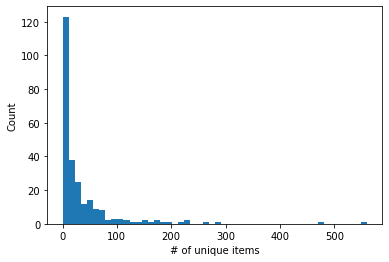

In [190]:
show_distribution(leaf_member = leaf_items)

mean: 64.46274509803922 std: 93.47264244998149


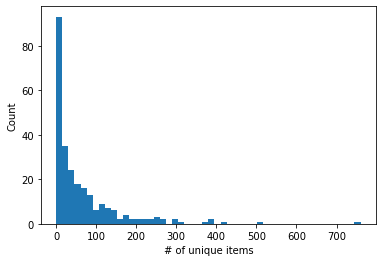

In [191]:
show_distribution(leaf_member = leaf_users)

# Same item in how many different leaf nodes?

mean:1.474891, std:4.263495


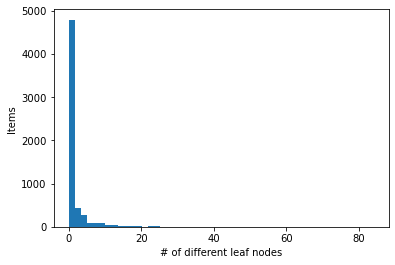

In [356]:
leaf_count_item = np.zeros(num_items)
for d in leaf_items:
    items = list(d.keys())
#     print(items)
    leaf_count_item[items] += 1
    
np.save('leaf-count-item-movie.npy', leaf_count_item)
leaf_count_item = np.sort(leaf_count_item)

plt.hist(leaf_count_item, bins = 50)
plt.xlabel('# of different leaf nodes')
plt.ylabel('Items')
plt.savefig('leaf_count_item', dpi = 400)

print("mean:%f, std:%f"%(np.mean(leaf_count_item), np.std(leaf_count_item)))

# --------------------------------------------------------

In [86]:

class Model: 
    '''wrapper class'''
    def __init__(self, tree):
        self.tree = tree
        self.left = T
        
    def ask(self, node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            left -= 1
                
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  self.ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            left -= 1
                
            if(not node.neg_node.vector is None):
                return self.ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
            
    def predict(self,reviews):
        pred = []
        for r in reviews:
#             print(r, self.tree.root)
            positive_attribute, node, n_left = self.ask(node = self.tree.root, single_review = r, left = self.left)
    
            pred.append(node.vector)
        
        pred = np.array(pred)
        return pred

In [87]:
# MRR5(model = Model(forest[0]), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [88]:
# MRR5(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [89]:
# DTCRS(model = Model(review_tree), V = V, user_interaction=val_user_interaction, reviews=val_review)

In [126]:
len(forest), len(val_user_interaction), len(test_user_interaction)

(11, 12000, 12000)

# MAIN FACT-CRS

In [372]:
def diffnegfactCRS(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            new_attr = False
            if(not node.feature in qa):
                left -= 1
                new_attr = True
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                
                if(new_attr):
#                     print("pos att")
                    return positive_attribute + 1, n, left
                else:
                    return positive_attribute, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    mrr = []

    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        success_turn = False

        identified_attribute = 0
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            identified_attribute += positive_attribute

            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
            mrr.extend(np.where(sorted_leaf_candidates == i)[0])
    
            if(i in recommend):
                success += 1
                success_turn = True
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
                    su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        
        total_turn += turn_count
        n_attribute = reviews[review_id].sum()
        if(success_turn):
            success_len.append(n_attribute)
            nk_success[(n_attribute, identified_attribute)] = 1 + nk_success.get((n_attribute, identified_attribute), 0)
        else:
            failed_len.append(n_attribute)
            nk_failed[(n_attribute, identified_attribute)] = 1 + nk_failed.get((n_attribute, identified_attribute), 0)

        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(np.mean(mrr), total_turn/count, success/count)
    
    print(total_turn/count, success/count)

In [367]:
EARLY_STOPPING = 400
ALPHA_POS = 1#1e-3
ALPHA_NEG = 1e-2#1e-3
N_MOVE_TOWARD = 30

rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()

success_len = []
failed_len = []
nk_success = {}
nk_failed = {}
diffnegfactCRS(forest = forest, V = V, user_interaction = val_user_interaction, reviews = val_review)
print("DONE!")

93.04069896040698 6.506 0.718
93.11453352607583 6.5075 0.7135
93.86087720582852 6.56 0.7083333333333334
94.01453184345242 6.575 0.70375
93.80553838000176 6.5768 0.7004
93.78664747564216 6.5685 0.7003333333333334
94.20509666635128 6.582 0.7008571428571428
94.05568477598715 6.57825 0.699375
94.0768608612534 6.572666666666667 0.6995555555555556
93.96924706038077 6.5677 0.7006
94.69925382067754 6.579909090909091 0.6982727272727273
94.9269352218592 6.587 0.69675
6.587 0.69675
Done


In [373]:
rec_made_at = dict()
ques_asked_at = dict()
rec_success_at = dict()

success_len = []
failed_len = []
nk_success = {}
nk_failed = {}

diffnegfactCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)
print("Done!")

96.45947108148785 6.55 0.7
96.74497072911123 6.5485 0.695
97.76333380742426 6.584666666666666 0.69
98.74627024157154 6.63925 0.685
98.24036940442087 6.6066 0.6914
98.55556743655546 6.5875 0.693
97.80474966336149 6.568142857142857 0.6962857142857143
98.07405015606501 6.556875 0.695
98.09894827216141 6.558111111111111 0.6943333333333334
98.27276438485669 6.5705 0.6928
97.80734626818965 6.576272727272728 0.6924545454545454
97.69189189189188 6.5755 0.6923333333333334
6.5755 0.6923333333333334
Done!


### calculate mu and sigma

In [397]:
print('success')
print(np.mean(success_len), np.std(success_len))
print('failed')
print(np.mean(failed_len), np.std(failed_len))
print('all')
print(np.mean(test_review.sum(axis = 1)), np.std(test_review.sum(axis = 1)))

success
4.375421280693308 1.0161230937898111
failed
4.022751895991332 0.9192902074825601
all
4.266916666666667 1.0006691892872934


In [412]:
def success_greater_than(k):
    print(1 - (np.array(failed_len) > k).sum() / sum(test_review.sum(axis = 1) > k))

success_greater_than(0)
success_greater_than(1)
success_greater_than(2)
success_greater_than(3)
success_greater_than(4)
success_greater_than(5)
success_greater_than(6)

0.6923333333333334
0.6923333333333334
0.6923333333333334
0.729049972542559
0.7651549169286035
0.830298616168973
0.8825910931174089


[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [0.05797101 0.41341795 0.73455882 0.90222222        nan        nan
         nan        nan        nan        nan]
 [0.15568862 0.53937947 0.76768916 0.82240437 0.94              nan
         nan        nan        nan        nan]
 [0.07142857 0.59478022 0.80193237 0.75907591 0.89795918        nan
         nan        nan        nan        nan]
 [0.41666667 0.77777778 0.86760125 0.72246696 0.96153846 1.
         nan        nan        nan        nan]
 [1.         0.75675676 0.94326241 0.79487179 0.4               nan
         nan        nan        nan        nan]
 [       nan 1.         0.95       1.                nan        nan
         nan        

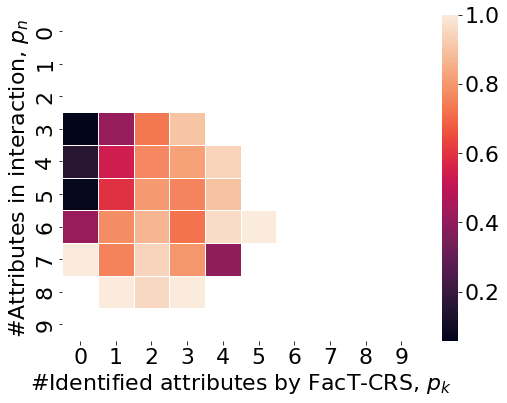

In [386]:
res = np.zeros((T, T))

for n in range(0, T):
    for k in range(0, T):
        nk_s = nk_success.get((n,k), 0)
        nk_f = nk_failed.get((n,k), 0)
        
        if((nk_s + nk_f) == 0):
            res[n,k] = np.nan
        else:
            res[n,k] = nk_s /(nk_s + nk_f)

print(res)

import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (8,6))
ax = sns.heatmap(res, linewidth=0.5)
plt.xlabel('#Identified attributes by FacT-CRS, '+r'$p_k$')
plt.ylabel('#Attributes in interaction, '+r'$p_n$')
plt.savefig('heatmap-movie.png',dpi = 400)
plt.show()

# rec success

rec_probability at turn 1 : 0.0
rec_probability at turn 2 : 0.6412010304699298
rec_probability at turn 3 : 0.13515144201761795
rec_probability at turn 4 : 0.586
rec_probability at turn 5 : 0.49512850663530994
rec_probability at turn 6 : 0.7284460769309254
rec_probability at turn 7 : 0.4725655712993669
rec_probability at turn 8 : 0.6207423247288835
rec_probability at turn 9 : 0.630718954248366
rec_probability at turn 10 : 1.0
rec_success at turn 2 : 0.13487115544472153
rec_success at turn 3 : 0.13035714285714287
rec_success at turn 4 : 0.14304356554908654
rec_success at turn 5 : 0.12111959287531807
rec_success at turn 6 : 0.15869458645563414
rec_success at turn 7 : 0.22870813397129186
rec_success at turn 8 : 0.11909448818897637
rec_success at turn 9 : 0.125
rec_success at turn 10 : 0.16332940714566158


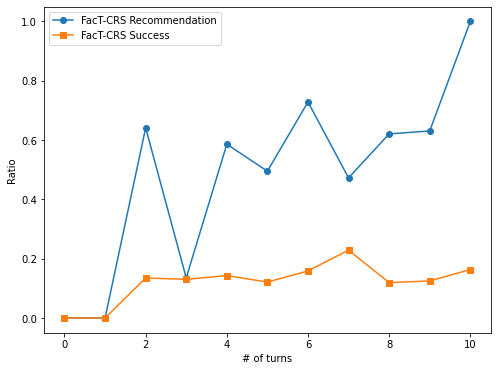

In [369]:
rec_probability = np.zeros(T+1)
for turn in range(1,T+1):
    if((rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0)) > 0):
        rec_probability[turn]  = rec_made_at.get(turn, 0)/(rec_made_at.get(turn, 0) + ques_asked_at.get(turn, 0))
        print("rec_probability at turn", turn, ":", rec_probability[turn])
        
rec_success_probability = np.zeros(T+1)
for turn in range(0,T+1):
    if((rec_made_at.get(turn, 0)) > 0):
        rec_success_probability[turn] = rec_success_at.get(turn,0)/rec_made_at.get(turn, 0)
        print("rec_success at turn", turn, ":", rec_success_probability[turn])
        
        
length = range(0,T+1)

plt.figure(figsize = (8,6))


plt.plot(length,rec_probability[0:T+1], label='FacT-CRS Recommendation', marker = 'o')
plt.plot(length,rec_success_probability[0:T+1], label='FacT-CRS Success', marker = 's')

plt.xlabel('# of turns')
plt.ylabel('Ratio')
plt.legend()
plt.savefig('rec-succ.png',dpi = 400)

In [370]:
rec_made_at, sum(rec_made_at.values())/len(test_user_interaction), rec_success_at

({2: 14436,
  10: 2547,
  3: 1120,
  9: 1544,
  4: 9962,
  5: 5895,
  7: 3135,
  8: 4064,
  6: 14279},
 4.7485,
 {3: 146, 4: 1425, 7: 717, 6: 2266, 5: 714, 2: 1947, 8: 484, 9: 193, 10: 416})

# Ablation Study

In [180]:
# previously MRR10
def FacTCRS_RankingOnly(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        sulist = []
        
        already_rec = set()
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            
#             print(left)
            
            asked_tree.add(forest[next_tree])
            left-=1
            
            sulist.append(node.vector)
            su = np.mean(sulist, axis = 0)
            
            pred = -su.dot(V.T)
            sorted_list = np.argsort(pred)
#             time.sleep(1)
            kcount = 0
            recommend = []
            while(len(recommend) < topK):
                if not sorted_list[kcount] in already_rec:
                    recommend.append(sorted_list[kcount])
                    already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                kcount += 1
        
#             print("target:", i, "recommend:", recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
#                 print('success')
                success += 1
                turn_count = T - left
                break
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (forest[tree_idx] in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
        
        

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
            
    print(total_turn/count, success/count)
            

In [364]:
# FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=val_user_interaction, reviews=val_review)
FacTCRS_RankingOnly(forest = forest, V = V, user_interaction=test_user_interaction, reviews=test_review)

8.459 0.508
8.501 0.4985
8.529666666666667 0.49766666666666665
8.57425 0.491
8.5532 0.4926
8.529 0.492
8.515285714285714 0.49257142857142855
8.497125 0.4965
8.510777777777777 0.4955555555555556
8.5136 0.4951
8.511272727272727 0.4954545454545455
8.5175 0.49333333333333335
8.5175 0.49333333333333335


In [363]:
def noEarlyRec(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= 0: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)

            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
        
        
        sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
            rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)

#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
            sulist.append(su)
            su = np.mean(sulist, axis = 0)
            
        
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
                turn_count = T - left
                break
            else:  ##Negative Feedback
                if ranked_recommend:
                    su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
                move_towards_items = []
                while(len(move_towards_items) < N_MOVE_TOWARD and cand < len(sorted_leaf_candidates)):
                    if(not sorted_leaf_candidates[cand] in already_rec):
                        move_towards_items.append(sorted_leaf_candidates[cand])
                    cand += 1
                if (move_towards_items):
#                     print("moving")
#                     su += ALPHA_POS* (np.mean(move_towards_items, axis = 0)) # move toward the latter items
#                     su = su/(1+ALPHA_POS)

                    su += ALPHA_POS*np.mean(move_towards_items, axis = 0) - ALPHA_NEG*np.mean(recommend, axis = 0) # move toward the latter items
#                     su = su/(1+ALPHA_POS-ALPHA_NEG)
                    pass
                
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
noEarlyRec(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

9.676 0.435
9.6775 0.439
9.684666666666667 0.43266666666666664
9.69425 0.42175
9.6868 0.4292
9.683166666666667 0.43183333333333335
9.681 0.4317142857142857
9.68025 0.434625
9.683222222222222 0.43377777777777776
9.6844 0.4346
9.683545454545454 0.43627272727272726
9.683833333333334 0.43625
9.683833333333334 0.43625


In [358]:
def factCRSwithoutNeg(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
#         sulist = []
        
        while(left > 0 and treecnt < len(forest)):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)


In [359]:
# factCRSwithoutNeg(forest = forest, V = V, user_interaction = val_user_interaction, reviews = val_review)

In [360]:
factCRSwithoutNeg(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

6.469 0.615
6.553 0.5955
6.550333333333334 0.5933333333333334
6.612 0.587
6.5702 0.5934
6.5601666666666665 0.593
6.5407142857142855 0.5947142857142858
6.5275 0.595
6.533888888888889 0.5942222222222222
6.5369 0.5944
6.530545454545455 0.5963636363636363
6.532 0.5955
6.532 0.5955


In [362]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()

# def varytopKCRS(forest, V, user_interaction, reviews):
    
#     topK = 50
    
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < len(forest)):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
#             left -= 1
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)

# #                 su += ALPHA_NEG* np.mean(V[idx[40:50]], axis = 0)
                    
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
    

#     print(total_turn/count, success/count)
    
# varytopKCRS(forest = forest, V = V,user_interaction = test_user_interaction[:firstr], reviews = test_review[:firstr])

In [361]:
def factCRSoneTree(forest, V, user_interaction, reviews):
    mrr = 0
    count = 0
    success = 0
    
    def ask(node, single_review, left):
        positive_attribute = 0
        if(left == 1):
            return positive_attribute, node, left
        
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node, left
    #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
#         print(len(np.unique(train_user_interaction[node.members,1])))
        if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
            return positive_attribute, node, left+1
    
    
        val = single_review[node.feature]
        
        ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
        if(val > 0):
    #         print("yes")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 1
            if(not node.pos_node.vector is None):
                positive_attribute, n, left =  ask(node.pos_node, single_review, left)
                return positive_attribute + 1, n, left
            else:
                return positive_attribute, node, left
        else:
    #         print("no")
            if(not node.feature in qa):
                left -= 1
                
            qa[node.feature] = 0
            if(not node.neg_node.vector is None):
                return ask(node.neg_node, single_review, left)
            else:
                return positive_attribute, node, left   
    
    
    
    def traverse(node, single_review):
        positive_attribute = 0
        if(node.feature is None):
    #         print("leaf node")
            return positive_attribute, node
        if(not node.feature in qa):
            return positive_attribute, node
    
        val = single_review[node.feature]
        if(val > 0):
            if(not node.pos_node.vector is None):
                positive_attribute, n =  traverse(node.pos_node, single_review)
                return positive_attribute + 1, n
            else:
                return positive_attribute, node
        else:                
            if(not node.neg_node.vector is None):
                return traverse(node.neg_node, single_review)
            else:
                return positive_attribute, node
    
    
    

    
    total_turn = 0
    
    for (review_id, interaction) in enumerate(user_interaction):
        count += 1
        u, i = interaction
        
        next_tree = 0
        asked_tree = set()
        qa = dict()
        left = T
        treecnt = 0
        turn_count = T
        
        
        already_rec = set()
#         sulist = []
        
        while(left > 0 and treecnt <= 1):
            review_tree = forest[next_tree]
            treecnt += 1
            
#             print("Now traversing: ", next_tree)
            
            positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
            asked_tree.add(next_tree)
            left-= 1
#             print("traversed the tree...")
            
            su = copy.deepcopy(node.vector)
#             sulist.append(su)
#             su = np.mean(sulist, axis = 0)
            
            leaf_candidates = np.unique(train_user_interaction[node.members,1])
#             print(leaf_candidates)
            score = -V[leaf_candidates].dot(su)
            idx = np.argsort(score)
            sorted_leaf_candidates = leaf_candidates[idx]

            recommend = []
            cand = 0
            while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
                if(not sorted_leaf_candidates[cand] in already_rec):
                    recommend.append(sorted_leaf_candidates[cand])
                    already_rec.add(sorted_leaf_candidates[cand])
                cand += 1
            
            ranked_recommend = []
            if(len(recommend) < topK):
                pred = -su.dot(V.T)
                sorted_list = np.argsort(pred)
    #             print("target:", i, "recommend:", recommend)
    #             time.sleep(1)
                kcount = 0
                while(len(recommend) < topK):
                    if not sorted_list[kcount] in already_rec:
                        recommend.append(sorted_list[kcount])
                        ranked_recommend.append(sorted_list[kcount])
                        already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
                    kcount += 1
        
#             print(recommend)
#             rank = np.where(recommend == i)[0]
#             mrr += (rank+1)
            if(i in recommend):
                success += 1
                turn_count = T - left
                break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
            best_match = -math.inf  ## CTF
            for tree_idx in range(len(forest)):
                if (tree_idx in  asked_tree):
                    continue
                _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
                probable_su = probable_node.vector
                sim = np.dot(probable_su, su)
                if( sim > best_match):
                    best_match = sim
                    next_tree = tree_idx
            
#             print("Checked all using history")

        total_turn += turn_count
        if((count) % 1000 == 0):
#             print(mrr/(count*treecnt), success/(count))
            print(total_turn/count, success/count)
    
    print(total_turn/count, success/count)
    
factCRSoneTree(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

8.671 0.243
8.7155 0.2335
8.737 0.22833333333333333
8.77325 0.222
8.756 0.2232
8.739 0.225
8.724 0.226
8.709 0.2275
8.721555555555556 0.22555555555555556
8.731 0.2239
8.725818181818182 0.22563636363636363
8.73525 0.22333333333333333
8.73525 0.22333333333333333


In [927]:
# rec_made_at = dict()
# ques_asked_at = dict()
# rec_success_at = dict()



# def factCRS(forest, V, user_interaction, reviews):
#     mrr = 0
#     count = 0
#     success = 0
    
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left+1
    
    
#         val = single_review[node.feature]
        
#         ques_asked_at[T-left] = 1 + ques_asked_at.get(T-left, 0)
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left   
    
    
    
#     def traverse(node, single_review):
#         positive_attribute = 0
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node
#         if(not node.feature in qa):
#             return positive_attribute, node
    
#         val = single_review[node.feature]
#         if(val > 0):
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n =  traverse(node.pos_node, single_review)
#                 return positive_attribute + 1, n
#             else:
#                 return positive_attribute, node
#         else:                
#             if(not node.neg_node.vector is None):
#                 return traverse(node.neg_node, single_review)
#             else:
#                 return positive_attribute, node
    
    
    
#     total_turn = 0
    
#     for (review_id, interaction) in enumerate(user_interaction):
#         count += 1
#         u, i = interaction
        
#         next_tree = 0
#         asked_tree = set()
#         qa = dict()
#         left = T
#         treecnt = 0
#         turn_count = T
        
        
#         already_rec = set()
        
#         while(left > 0 and treecnt < len(forest)):
#             review_tree = forest[next_tree]
#             treecnt += 1
            
# #             print("Now traversing: ", next_tree)
            
#             positive_attribute, node, left = ask(review_tree.root, reviews[review_id], left)
#             asked_tree.add(next_tree)
            
# #             print("traversed the tree...")
            
#             su = copy.deepcopy(node.vector)
#             leaf_candidates = np.unique(train_user_interaction[node.members,1])
# #             print(leaf_candidates)
#             score = -V[leaf_candidates].dot(su)
#             idx = np.argsort(score)
#             sorted_leaf_candidates = leaf_candidates[idx]

#             recommend = []
#             cand = 0
#             while(len(recommend) < topK and cand < len(sorted_leaf_candidates)):
#                 if(not sorted_leaf_candidates[cand] in already_rec):
#                     recommend.append(sorted_leaf_candidates[cand])
#                     already_rec.add(sorted_leaf_candidates[cand])
#                 cand += 1
            
#             ranked_recommend = []
#             if(len(recommend) < topK):
#                 pred = -su.dot(V.T)
#                 sorted_list = np.argsort(pred)
#     #             print("target:", i, "recommend:", recommend)
#     #             time.sleep(1)
#                 kcount = 0
#                 while(len(recommend) < topK):
#                     if not sorted_list[kcount] in already_rec:
#                         recommend.append(sorted_list[kcount])
#                         ranked_recommend.append(sorted_list[kcount])
#                         already_rec.add(sorted_list[kcount])  # we don't want to recommend the same item twice
#                     kcount += 1
        
# #             print(recommend)
# #             rank = np.where(recommend == i)[0]
# #             mrr += (rank+1)

#             rec_made_at[T-left] = 1 + rec_made_at.get(T-left, 0)


#             if(i in recommend):
#                 rec_success_at[T-left] = 1 + rec_success_at.get(T-left, 0)
#                 success += 1
#                 turn_count = T - left
#                 break
#             else:  ##Negative Feedback
#                 if ranked_recommend:
#                     su -= ALPHA_NEG* np.mean(V[ranked_recommend], axis = 0)
            
#             best_match = -math.inf  ## CTF
#             for tree_idx in range(len(forest)):
#                 if (tree_idx in  asked_tree):
#                     continue
#                 _, probable_node = traverse(forest[tree_idx].root, reviews[review_id])
#                 probable_su = probable_node.vector
#                 sim = np.dot(probable_su, su)
#                 if( sim > best_match):
#                     best_match = sim
#                     next_tree = tree_idx
            
# #             print("Checked all using history")

#         total_turn += turn_count
#         if((count) % 1000 == 0):
# #             print(mrr/(count*treecnt), success/(count))
#             print(total_turn/count, success/count)
    
# factCRS(forest = forest, V = V, user_interaction = test_user_interaction, reviews = test_review)

In [91]:
# # review_tree = forest[0]


# def compare(reviews, interaction):
    
#     leaf_success = 0
#     pred_success = 0
    
#     nk_success = {}
#     nk_failed = {}
    
#     qa = dict()
#     def ask(node, single_review, left):
#         positive_attribute = 0
#         if(left == 1):
#             return positive_attribute, node, left
        
#         if(node.feature is None):
#     #         print("leaf node")
#             return positive_attribute, node, left
#     #     print("Q{}: {} > 0?:".format(depth+1, node.feature))
# #         print(len(np.unique(train_user_interaction[node.members,1])))
#         if len(np.unique(train_user_interaction[node.members,1])) <= EARLY_STOPPING: ## EARLY STOPPING
#             return positive_attribute, node, left
    
    
#         val = single_review[node.feature]
        
        
#         if(val > 0):
#     #         print("yes")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 1
#             if(not node.pos_node.vector is None):
#                 positive_attribute, n, left =  ask(node.pos_node, single_review, left)
#                 return positive_attribute + 1, n, left
#             else:
#                 return positive_attribute, node, left
#         else:
#     #         print("no")
#             if(not node.feature in qa):
#                 left -= 1
                
#             qa[node.feature] = 0
#             if(not node.neg_node.vector is None):
#                 return ask(node.neg_node, single_review, left)
#             else:
#                 return positive_attribute, node, left
    
    
    
    
    
#     for r_id in range(len(reviews)):
#         r = reviews[r_id]
#         u, i = interaction[r_id]
        
#         n_attribute = r.sum()
#         identified_attribute, node, _ = ask(node = review_tree.root, single_review = r, left = 15)
        
        
#         members = node.members
#         vector = node.vector
            
#         pred = -V.dot(vector)
#         recommend = np.argsort(pred)[:topK]
        
        
#         if(i in recommend):
#             pred_success +=1
#             nk_success[(n_attribute, identified_attribute)] = 1 + nk_success.get((n_attribute, identified_attribute), 0)
#         else:
#             nk_failed[(n_attribute, identified_attribute)] = 1 + nk_failed.get((n_attribute, identified_attribute), 0)
            
        
#         all_candidates = np.unique(train_user_interaction[members,1])
#         if(len(all_candidates) > topK):
#             score = -V[all_candidates].dot(vector)
#             idx = np.argpartition(score, topK)[:topK]
#             all_candidates = all_candidates[idx]
        
#         all_candidates = set(all_candidates)
#         cand = 0
#         while(len(all_candidates) < topK):
#             all_candidates.add(recommend[cand])
#             cand += 1
        
        
#         if (i in all_candidates):
#             leaf_success += 1
#             successful_rid.append(r_id)
#         else:
#             rejected_items.append(i)
#             rejected_reviews.append(r)
            
#         global leaf_0_success, pred_0_success
#         if (identified_attribute == 0 and i in all_candidates and i not in recommend[:cand]):
#             leaf_0_success += 1
#         elif (identified_attribute == 0 and i in recommend):
#             pred_0_success +=  1
            
        
#     print("leaf_success:", leaf_success/len(reviews)), print("pred_success:", pred_success/len(reviews))
# #     print(np.mean(successN), np.std(successN))
# #     plt.hist(successN, range=(0,2000))
#     return nk_success, nk_failed

# leaf_0_success = 0
# pred_0_success = 0

# rejected_items = []
# rejected_reviews = []
# successful_rid = []






# nk_success,nk_failed = compare(reviews=val_review, interaction=val_user_interaction)

# print(leaf_0_success, pred_0_success)

leaf_success: 0.327
pred_success: 0.29
3 0


In [200]:
def count_attributes(reviews):
    reviews = np.array(reviews)
    print(reviews.sum(axis = 1).mean(), reviews.sum(axis = 1).std())
    
count_attributes(reviews = rejected_reviews)
count_attributes(reviews = train_review)
count_attributes(reviews = train_review[successful_rid])

2.1542912246865957 1.5136728406054296
4.034853751389185 2.4605978460446605
4.02036987402841 2.474173859643712


In [202]:
def greaterThanFailed(k):
    count_all = 0
    count_rej = 0
    for r in train_review:
        if(r.sum() >= k):
            count_all += 1
    for r in rejected_reviews:
        if(r.sum() >= k):
            count_rej += 1
    return count_all, count_rej
    
greaterThanFailed(4)

(21741, 449)

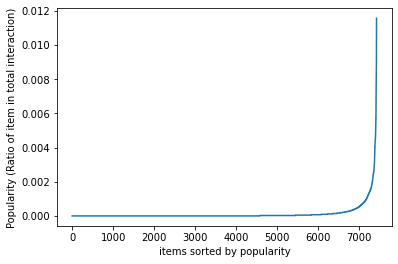

In [197]:
## item hit
rejected_uniq_items = np.unique(rejected_items)
# print(item_hit[rejected_uniq_items]).mean(), item_hit[rejected_uniq_items].std())
plt.plot(sorted(item_hit/len(train_review)))

plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
# plt.plot(sorted(item_hit[rejected_items]/len(train_review)))
# plt.show()
plt.savefig('popularity-all.png', dpi = 400)

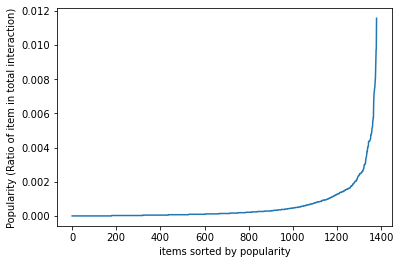

In [196]:
plt.plot(sorted(item_hit[rejected_uniq_items]/len(train_review)))
plt.ylabel('Popularity (Ratio of item in total interaction)')
plt.xlabel('items sorted by popularity')
plt.savefig('popularity-failed.png', dpi = 400)

In [118]:
print((sum(item_hit/len(train_review) > 0.001)) / len(item_hit))

print((sum(item_hit[rejected_uniq_items]/len(train_review) > 0.001)) / len(rejected_uniq_items))


0.03257942918686053
0.15797101449275364


# False positive and negative

In [ ]:
def count_fp_fn(node, single_review, depth, target):

    fp = False
    fn = False
    
    if(node.feature is None):
#         print("leaf node")
        return node.members, depth, node.vector, fp, fn
#     print("Q{}: {} > 0?:".format(depth+1, node.feature))   

    val = single_review[node.feature]

    if(val > 0):
#         print("yes")
        
        if(train_item_opinion[target, node.feature] <= 0 ):
            fp = True
            
        if(not node.pos_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        
    else:
#         print("no")
        if(train_item_opinion[target, node.feature] > 0 ):
            fn = True
            
        if(not node.neg_node is None):
            m,d,v,a,b= count_fp_fn(node.pos_node, single_review, depth+1, target)
            return m, d, v, (a or fp), (b or fn)
        else:
            return node.members, depth+1, node.vector, fp, fn
        

In [ ]:

def total_fp_fn(reviews, interaction):
    
    success_fp = 0
    success_fn = 0

    failure_fp = 0
    failure_fn = 0

    success = 0
    
#     for r_id in range(len(reviews)):
    for r_id in range(4800):
        r = reviews[r_id]
        u, i = interaction[r_id]

        members, _, vector, fp, fn = count_fp_fn(node = review_tree.root, single_review = r, depth = 0, target = i)
        
        su = review_model.predict(r.reshape(1,-1))#??????????????????????
        pred = -su.dot(V.T)[0]
#         recommend = np.argsort(pred)
        
#         pred = -vector.dot(V.T)
        recommend = np.argpartition(pred, topK)[:topK]
        if(i in recommend): #success
            success += 1
            if(fp):
                success_fp += 1
            if(fn):
                success_fn += 1
        else: #failure
            if(fp):
                failure_fp += 1
            if(fn):
                failure_fn += 1
                
        if((r_id+1)%1000 == 0):
            print(success/(r_id+1))
    
    print(success, success_fp, success_fn, failure_fp, failure_fn)
                
total_fp_fn(reviews=test_review, interaction=test_user_interaction)

## Done

In [669]:
# SU, V = loadSUV(i=0)
# MRR1(SU = SU_new, V=V, user_interaction = train_user_interaction)
# print("-----------------------")
# MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)


In [ ]:
i = 500
V[i], V_copy[i]

In [ ]:
j = 500
SU[j], SU_new[j]

In [ ]:
saveSUV(i=1)

In [ ]:
def save_tree(i):
    with open("review_tree_{}.pkl".format(i), "wb") as f:
        pickle.dump(review_tree, f)
        
def load_tree(i):
    with open("review_tree_{}.pkl".format(i), "rb") as f:
        pickle.dump(review_tree, f)

In [ ]:
save_tree(i = 1)

In [ ]:
saveSUV(i=1)

In [ ]:
SU, _ = loadSUV(i = 1)

# ----------------------------------------------------------------

# ----------------------------------------------------------------

In [ ]:
import os.path
import time

MAX_ITER = 50
SGD_ITER = 1500

for i in range(0,MAX_ITER+1):
    
    fpath = "V_{}.npy".format(i)
    while not os.path.exists(fpath):
        print("waiting for ", fpath)
        time.sleep(60)
    if os.path.isfile(fpath):
        V = np.load('V_{}.npy'.format(i))
    else:
        raise ValueError("%s isn't a file!" % fpath)
        
    create_tree(tree_type="item", node=item_tree.root, depth=0)
    print_tree(item_tree.root, 0, 0)
    
    review_model = Model(tree = item_tree)
    SU_new, V_copy = personalize(model = item_model, num_iter = SGD_ITER)
    
    print("RESULT OF ITERATION...")
    MRR1(SU = SU_new, V=V_copy, user_interaction = train_user_interaction)
    
    SU = SU_new
    np.save('SU_{}'.format(i), SU)
    save_tree(i = i)
    review_tree = Tree(tree_type = "review")


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [161]:
s = "this is a, string"
tokens = s.split(",")
for t in tokens:
    print(t)

this is a
 string


In [177]:
import re
re.split('\.\+', "This.is.working+maybe")

['This.is.working+maybe']

In [179]:
s = "this is a"

news = ""

for c in s:
    news = c+news

news

'a si siht'